# Python Football Manager scouting

In [1]:
year_month = '2032/06'  # Current YearMonth of the exports. Useful if you want to put together the data after a while to track progress.

In [2]:
import itertools
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import openpyxl
from openpyxl.utils.dataframe import dataframe_to_rows

# ID mapping files
#faces_path = pd.read_csv("D:/Documents/Sports Interactive/Football Manager 2023/graphics/all_players.csv", sep=';')
#logos_path = pd.read_csv("D:/Documents/Sports Interactive/Football Manager 2023/graphics/clubs.csv", sep=';')
#flags_path = pd.read_csv("D:/Documents/Sports Interactive/Football Manager 2023/graphics/nations.csv", sep=';')
flags_path = pd.read_csv("scouting/data/nations.csv", sep=';')

# General variables
formatted_year_month = year_month.replace('/', '.')
xlsx_path = f"scouting/exports/Report - {formatted_year_month}.xlsx"
csv_path = f"scouting/exports/Scouting - {formatted_year_month}.csv"
combined_path = f"scouting/exports/Combined - {formatted_year_month}.csv"

top_n = 15  # Number of top options to show on visualizations
int_choice = 1  # 0 shows all players, 1 shows only the ones interested in joining
filter_choice = 0 # 0 shows all players, 1 shows only the ones in the 'ft.html' file, usually to filter by higher PAs
nation = '' # If not empty, filters players from a specific nation. Useful on 1-nation saves
age = 28    # Maximum age to look for players
ask_price = 10000    # Maximum asking price to look for players
wage = 10000   # Maximum wage to look for players

clubs_list = ["Crewe Alexandra"]   # List of clubs controlled by the human manager. Useful for teams with different names from the B team
age_club = 99   # Maximum age to filter players from own club
formation = ['GK', 'RB', 'CB', 'CB', 'LB', 'DM', 'CM', 'CM', 'RW', 'LW', 'ST']  # Current formation used

# Variables that define the sorting column in the positional dataframes
role_gk = 'SK_D'    # SK_D is the only option
role_rb = 'WB_S'    # WB_S or CWB_S
role_lb = 'WB_S'    # WB_S or CWB_S
role_cb = 'BPD_D'   # BPD_D or CD_D
role_dm = 'DM_D'    # DM_D, CM_S or DLP_S
role_cm = 'CM_S'    # CM_S, DLP_S, MEZ_A or VOL_S	
role_am = 'AM_A'    # AM_A or EG_S
role_rw = 'IW_A'    # IW_A or IF_A
role_lw = 'IW_A'    # IW_A or IF_A
role_st = 'AF_A'    # AF_A is the only option

In [3]:
# Scouting data including attributes and stats
#scouting = pd.read_html("sc.html", encoding="UTF-8", thousands=".", decimal=",")[0]
#scouting = pd.read_csv("sc.csv", encoding='utf-16le', low_memory=False)
sc1 = pd.read_html("scouting/sc1.html", encoding="UTF-8", thousands=".", decimal=",")[0]
print("SC1 shape:", sc1.shape)
sc2 = pd.read_html("scouting/sc2.html", encoding="UTF-8", thousands=".", decimal=",")[0]
print("SC2 shape:", sc2.shape)
scouting = pd.concat([sc1, sc2], ignore_index=True)
print("SC1 + SC2 shape:", scouting.shape)
scouting = scouting.drop_duplicates(subset='UID', keep='first')

fm_exported_players = scouting['UID'].to_list()
scouting['Division'] = scouting['Based'].str.extract(r'\((.*?)\)')
scouting['Based'] = scouting['Based'].str.extract(r'^([^(]+)')
scouting['Based'] = scouting['Based'].str.strip()
scouting.drop_duplicates(subset='UID', inplace=True)
print("Scouting shape:", scouting.shape)

# Export of players interested in joining (only UID matters)
interest = pd.read_csv("scouting/int.csv", encoding="windows-1252", sep=';', low_memory=False)['Unique ID'].to_list()
#interest = pd.read_html("int.html", encoding="UTF-8", thousands=".", decimal=",")[0]['UID'].to_list()
print("Size of interested list:", len(interest))

# Export of filtered players - in this case 4* PA (only UID matters)
filter_list = pd.read_csv("scouting/ft.csv", encoding="windows-1252", sep=';', low_memory=False)['Unique ID'].to_list()
#filter_list = pd.read_html("ft.html", encoding="UTF-8", thousands=".", decimal=",")[0]['UID'].to_list()

# Creating binary columns using the lists above
scouting['Int'] = scouting['UID'].isin(interest).astype(int)
scouting['Flt'] = scouting['UID'].isin(filter_list).astype(int)

# Dropping NAs on Name column
scouting = scouting.dropna(subset=['Name'])

# Genie Scout - Club data
divisions = pd.read_csv("scouting/data/divisions.csv", encoding="windows-1252", sep=';', thousands='.', low_memory=False)

# Genie Scout - Players data
genie = pd.read_csv("scouting/genie.csv", encoding="windows-1252", sep=';', low_memory=False)
genie = genie[genie['Unique ID'].isin(fm_exported_players)]
genie = pd.merge(genie, divisions, on=['Based', 'Division'], how='left')
genie['Division ID'] = genie['Division ID'].fillna(0).astype(int)
genie.loc[genie['Club ID'] == -1, 'Division ID'] = -1
genie.loc[(genie['Division'] == 'Jupiler Pro League') & (genie['Based'] != 'Belgium'), 'Division ID'] = 0

# Creating a stats-only dataframe
stats_columns = [
    "UID", "Av Rat", "Apps", "Mins", "Gls", "Ast", "Clean sheets",
    "Conc", "xA", "FA", "NP-xG", "Blk", "CCC", "Clear", "Cr C",
    "Cr C/A", "Drb", "xGP", "Hdrs", "Hdr %", "Sprints/90", "Itc",
    "OP-KP", "Pas %", "Pres C", "Pr Passes", "ShT", "Conversion Rate (%)"
]

stats = scouting[stats_columns]

print("SHAPE OF THE IMPORT FILES")
print("Genie:", genie.shape)
print("Scouting:", scouting.shape)
print("Stats:", stats.shape)
print("Interested:", len(interest))
print("Filter list:", len(filter_list))

# List of countries and divisions
#quick_data = pd.read_excel("C:/Mantovani/Careers/Football Manager 2023/PythonFM/FM Quick Data.xlsx", sheet_name='Division Levels')[['Based', 'Lv', 'YR']]
#print("Quick data:", quick_data.shape)

############################################################

# Function to calculate abilities based on key, green and blue attributes
def calculate_metric(key, green, blue, denominator):
    return ((key * 5) + (green * 3) + (blue * 1)) / denominator

# Function to process attributes (gets the average value of ranges, so 6-11 becomes 8.5)
def process_attribute(attribute_value):
    if pd.isna(attribute_value) or attribute_value == '' or attribute_value == '-':
        # Case 3: Replace NaN or empty string with 0
        return 0
    elif '-' in str(attribute_value):
        # Case 2: Average between the range
        values = attribute_value.split('-')
        return (pd.to_numeric(values[0]) + pd.to_numeric(values[1])) / 2
    else:
        # Case 1: Single numeric value
        return pd.to_numeric(attribute_value)

# Function to calculate variance of unknown attributes (6-11 is a variance of 5)
def calculate_variance(attribute_value, position):
    if pd.isna(attribute_value) or attribute_value == '' or attribute_value == '-':
        # Case 1: Replace NaN, empty string, or '-' (meaning we don't know anything) with 19 (the maximum range)
        return 19
    elif '-' in str(attribute_value):
        # Case 2: Average between the range
        values = attribute_value.split('-')
        return pd.to_numeric(values[1]) - pd.to_numeric(values[0])
    else:
        # Case 3: We know the attribute so 0 variance
        return 0

# Adjusted function to consider position-specific columns when calculating variance
def calculate_variance_by_position(row):
    position = row['Position']
    if position != "GK":
        columns_to_count = ['Det', 'Prof', 'Amb', 'Acc', 'Pac', 'Agi', 'Bal',
                            'Sta', 'Ant', 'Cnt', 'Wor', 'Cro', 'Dri', 'Fin', 'Fir',
                            'Jum', 'Mar', 'Pas', 'Str', 'Tck', 'Tec', 'Vis', 'Agg',
                            'Bra', 'Cmp', 'Dec', 'Fla', 'Hea', 'Ldr',
                            'Lon', 'Nat.1', 'OtB', 'Pos', 'Tea']
    else:
        columns_to_count = ['Det', 'Prof', 'Amb', 'Acc', 'Pac', 'Agi', 'Bal',
                            'Sta', 'Ant', 'Cnt', 'Wor', 'Cro', 'Dri', 'Fin', 'Fir',
                            'Jum', 'Mar', 'Pas', 'Str', 'Tck', 'Tec', 'Vis', 'Aer',
                            'Ref', 'Han', '1v1', 'Agg', 'Bra', 'Cmd', 'Com', 'Cmp',
                            'Dec', 'Ecc', 'Fla', 'Hea', 'Kic', 'Ldr',
                            'Lon', 'Nat.1', 'OtB', 'Pos', 'Pun',
                            'TRO', 'Tea', 'Thr']
    
    variances = [calculate_variance(row[col], position) for col in columns_to_count]
    variances_positive = [variance for variance in variances if variance != 0]
    
    # Return the mean of variances_positive
    if variances_positive:
        return sum(variances_positive) / len(variances_positive)
    else:
        return 0  # Return 0 if no positive variances found

# Function to calculate known players
def known_players(row, position):
    columns_to_count = []
    if position != "GK":
        columns_to_count = ['Det', 'Prof', 'Amb', 'Acc', 'Pac', 'Agi', 'Bal',
                            'Sta', 'Ant', 'Cnt', 'Wor', 'Cro', 'Dri', 'Fin', 'Fir',
                            'Jum', 'Mar', 'Pas', 'Str', 'Tck', 'Tec', 'Vis', 'Agg',
                            'Bra', 'Cmp', 'Cor', 'Dec', 'Fla', 'Fre', 'Hea', 'Ldr',
                            'Lon', 'L Th', 'Nat.1', 'OtB', 'Pen', 'Pos', 'Tea']
    else:
        columns_to_count = ['Det', 'Prof', 'Amb', 'Acc', 'Pac', 'Agi', 'Bal',
                            'Sta', 'Ant', 'Cnt', 'Wor', 'Cro', 'Dri', 'Fin', 'Fir',
                            'Jum', 'Mar', 'Pas', 'Str', 'Tck', 'Tec', 'Vis', 'Aer',
                            'Ref', 'Han', '1v1', 'Agg', 'Bra', 'Cmd', 'Com', 'Cmp',
                            'Cor', 'Dec', 'Ecc', 'Fla', 'Fre', 'Hea', 'Kic', 'Ldr',
                            'Lon', 'L Th', 'Nat.1', 'OtB', 'Pen', 'Pos', 'Pun',
                            'TRO', 'Tea', 'Thr']

    count = sum([1 for col in columns_to_count if "-" in str(row[col])])
    
    # Returning 0 if the count is greater than or equal to 1, else returning 1
    return 0 if count >= 1 else 1

# Helper function to calculate a single role ability based on specific sets of attributes (1-20)
def calculate_single_role(df, key_attributes, green_attributes, blue_attributes, divisor, column_name):
    df[column_name + '_key'] = df[key_attributes].sum(axis=1)
    df[column_name + '_green'] = df[green_attributes].sum(axis=1)
    df[column_name + '_blue'] = df[blue_attributes].sum(axis=1)
    df[column_name] = ((df[column_name + '_key'] * 5) + (df[column_name + '_green'] * 3) + (df[column_name + '_blue'] * 1)) / divisor
    df[column_name] = df[column_name].round(2)
    df.drop(columns=column_name + '_key', inplace=True)
    df.drop(columns=column_name + '_green', inplace=True)
    df.drop(columns=column_name + '_blue', inplace=True)

# Main function to calculate multiple roles based on the previous function (1-20)
def calculate_roles(df):
    calculate_single_role(df, ['Agi', 'Ref'], ['Cmd', 'Kic', '1v1', 'Ant', 'Cnt', 'Pos'],
                                ['Aer', 'Fir', 'Han', 'Pas', 'TRO', 'Dec', 'Vis', 'Acc'], 36, 'SK_D')
    
    calculate_single_role(df, ['Acc', 'Pac', 'Sta', 'Wor'], ['Cro', 'Dri', 'Mar', 'Tck', 'OtB', 'Tea'],
                                ['Fir', 'Pas', 'Tec', 'Ant', 'Cnt', 'Dec', 'Pos', 'Agi', 'Bal'], 47, 'WB_S')
    
    calculate_single_role(df, ['Acc', 'Pac', 'Sta', 'Wor'], ['Cro', 'Dri', 'Tec', 'OtB', 'Tea'],
                                ['Fir', 'Mar', 'Pas', 'Tck', 'Ant', 'Dec', 'Fla', 'Pos', 'Agi', 'Bal'], 43, 'CWB_S')
    
    calculate_single_role(df, ['Acc', 'Pac', 'Jum', 'Cmp'], ['Hea', 'Mar', 'Tck', 'Pos', 'Str'],
                                ['Agg', 'Ant', 'Bra', 'Cnt', 'Dec'], 40, 'CD_D')
    
    calculate_single_role(df, ['Acc', 'Pac', 'Jum', 'Cmp'], ['Hea', 'Mar', 'Pas', 'Tck', 'Pos', 'Str'],
                                ['Fir', 'Tec', 'Agg', 'Ant', 'Bra', 'Cnt', 'Dec', 'Vis'], 46, 'BPD_D')
    
    calculate_single_role(df, ['Wor', 'Sta', 'Acc', 'Pac'], ['Tck', 'Ant', 'Cnt', 'Pos', 'Tea'],
                                ['Mar', 'Pas', 'Agg', 'Cmp', 'Str', 'Dec'], 41, 'DM_D')
    
    calculate_single_role(df, ['Acc', 'Pac', 'Sta', 'Wor'], ['Fir', 'Pas', 'Tec', 'Dec', 'Tea'],
                                ['Tec', 'Ant', 'Cmp', 'Cnt', 'OtB', 'Vis'], 41, 'CM_S')
    
    calculate_single_role(df, ['Wor', 'Sta', 'Acc', 'Pac'], ['Fir', 'Pas', 'Tec', 'Cmp', 'Dec', 'Tea', 'Vis'],
                                ['Ant', 'OtB', 'Pos', 'Bal'], 45, 'DLP_S')

    calculate_single_role(df, ['Acc', 'Pac', 'Sta', 'Wor'], ['Dri', 'Pas', 'Tec', 'Dec', 'OtB', 'Vis'],
                                ['Fin', 'Fir', 'Lon', 'Ant', 'Cmp', 'Fla', 'Bal'], 45, 'MEZ_A')

    calculate_single_role(df, ['Wor', 'Sta', 'Acc', 'Pac'], ['Mar', 'Pas', 'Tck', 'OtB', 'Pos'],
                                ['Fin', 'Fir', 'Lon', 'Ant', 'Cmp', 'Cnt', 'Dec', 'Bal', 'Str'], 44, 'VOL_S')
    
    calculate_single_role(df, ['Acc', 'Pac', 'Sta', 'Wor'], ['Cro', 'Dri', 'Pas', 'Tec', 'Agi'],
                               ['Fir', 'Lon', 'Ant', 'Cmp', 'Dec', 'Fla', 'OtB', 'Vis', 'Bal'], 44, 'IW_A')
    
    calculate_single_role(df, ['Acc', 'Pac', 'Sta', 'Wor'], ['Dri', 'Fin', 'Fir', 'Tec', 'Ant', 'OtB', 'Agi'],
                               ['Lon', 'Pas', 'Cmp', 'Fla', 'Bal'], 46, 'IF_A')
    
    calculate_single_role(df, ['Acc', 'Pac', 'Sta', 'Wor'], ['Dri', 'Fir', 'Lon', 'Pas', 'Tec', 'Ant', 'Dec', 'Fla', 'OtB'],
                               ['Fin', 'Cmp', 'Vis', 'Agi'], 51, 'AM_A')
    
    calculate_single_role(df, ['Acc', 'Pac', 'Sta', 'Wor'], ['Fir', 'Pas', 'Tec', 'Cmp', 'Dec', 'Vis'],
                               ['Dri', 'Ant', 'Fla', 'OtB', 'Tea', 'Agi'], 44, 'EG_S')
    
    calculate_single_role(df, ['Acc', 'Pac', 'Fin'], ['Dri', 'Fir', 'Tec', 'Cmp', 'OtB'],
                               ['Pas', 'Ant', 'Dec', 'Wor', 'Agi', 'Bal', 'Sta'], 37, 'AF_A')

# Function to determine the best role
def determine_role(row):
    if row['P1'] == 'GK':
        return 'SK_D'
    elif row['P1'] in ['RB', 'LB']:
        return max(('WB_S', row['WB_S']), ('CWB_S', row['CWB_S']), key=lambda x: x[1])[0]
    elif row['P1'] == 'CB':
        return max(('BPD_D', row['BPD_D']), ('CD_D', row['CD_D']), key=lambda x: x[1])[0]
    elif row['P1'] == 'DM':
        return max(('DM_D', row['DM_D']), ('VOL_S', row['VOL_S']), key=lambda x: x[1])[0]
    elif row['P1'] == 'CM':
        return max(('CM_S', row['CM_S']), ('DLP_S', row['DLP_S']), ('MEZ_A', row['MEZ_A']), key=lambda x: x[1])[0]
    elif row['P1'] == 'AM':
        return max(('EG_S', row['EG_S']), ('AM_A', row['AM_A']), key=lambda x: x[1])[0]
    elif row['P1'] in ['RW', 'LW']:
        return max(('IW_A', row['IW_A']), ('IF_A', row['IF_A']), key=lambda x: x[1])[0]
    elif row['P1'] == 'ST':
        return 'AF_A'
    else:
        return max(row[['SK_D', 'WB_S', 'CWB_S', 'BPD_D', 'CD_D', 'DM_D', 'VOL_S', 'CM_S', 'DLP_S', 'MEZ_A', 'EG_S', 'AM_A', 'IW_A', 'IF_A', 'AF_A']])

# Function to determine the best role ability
def determine_role_CA(row):
    if row['P1'] == 'GK':
        return row['SK_D']
    elif row['P1'] in ['RB', 'LB']:
        return max(row['WB_S'], row['CWB_S'])
    elif row['P1'] == 'CB':
        return max(row['BPD_D'], row['CD_D'])
    elif row['P1'] == 'DM':
        return max(row['DM_D'], row['VOL_S'])
    elif row['P1'] == 'CM':
        return max(row['CM_S'], row['DLP_S'], row['MEZ_A'])
    elif row['P1'] == 'AM':
        return max(row['EG_S'], row['AM_A'])
    elif row['P1'] in ['RW', 'LW']:
        return max(row['IW_A'], row['IF_A'])
    elif row['P1'] == 'ST':
        return row['AF_A']
    else:
        return max(row['SK_D'], row['WB_S'], row['CWB_S'], row['BPD_D'], row['CD_D'], row['DM_D'], row['VOL_S'], row['CM_S'], row['DLP_S'], row['MEZ_A'], row['EG_S'], row['AM_A'], row['IW_A'], row['IF_A'], row['AF_A'])

# Function to extract Starts and Subbed
def extract_starts_and_subbed(row):
    if '(' in row:
        starts, subbed = row.split(' ')
        subbed = subbed.strip('()')
        return int(starts), int(subbed)
    else:
        return int(row), 0

# Function to transform the Wage column from "$ 350.000 p/m" into "350000"
def process_wage_column(df):
    df['Wage_Aux'] = df['Wage'].str.replace('.', '', regex=False).str[2:-4]
    df['Wage_Aux'].replace('', pd.NA, inplace=True)
    df['Wage'] = df['Wage_Aux'].fillna(0).astype(int)
    df.drop(columns=['Wage_Aux'], inplace=True)
    
# Inverse function of the above (easier to visualize)
def revert_wage_column(wage):
    if wage >= 1000000:
        return f'€ {wage / 1000000:.1f}M'
    elif 1000 <= wage < 1000000:
        return f'€ {wage / 1000:.0f}k'
    else:
        return f'€ {wage}'

# Same process from the previous one but for the Asking Price column
def process_price_column(df):
    if not (df['AP'] == 0).all():
        df['Aux1'] = df['AP'].str[-1]
        possible_values_aux = [(df['Aux1'] == '0'), (df['Aux1'] == 'K'), (df['Aux1'] == 'M')]
        replacements_aux = [0, 1000, 1000000]
        df['Aux2'] = np.select(possible_values_aux, replacements_aux, default=0)
        df['Aux3'] = df['AP'].str[2:]
        df['Aux4'] = df['Aux3'].apply(lambda x: 0 if x == '0' else x[:-1])
        df['Aux4'].replace('', pd.NA, inplace=True)
        df['Aux4'] = df['Aux4'].str.replace(',', '.').fillna(0).astype(float)
        df['AP'] = df['Aux4'] * df['Aux2']
        df['AP'] = df['AP'].astype(int)
        df.drop(columns=['Aux1', 'Aux2', 'Aux3', 'Aux4'], inplace=True)
        
# Inverse function of the above (easier to visualize)
def revert_price_column(asking_price):
    if asking_price >= 1000000:
        return f'€ {asking_price / 1000000:.1f}M'
    elif 1000 <= asking_price < 1000000:
        return f'€ {asking_price / 1000:.0f}k'
    else:
        return f'€ {asking_price}'
    
# Function to calculate a player's ability as Goalkeeper (1-20)
def calculate_gk_score(row):
    gk_essential = (row['Agi'] + row['Ref']) * 5
    gk_core = (row['1v1'] + row['Ant'] + row['Cmd'] + row['Cnt'] + row['Kic'] + row['Pos']) * 3
    gk_secondary = (row['Acc'] + row['Aer'] + row['Cmp'] + row['Dec'] + row['Fir'] + row['Han'] + row['Pas'] + row['Thr'] + row['Vis']) * 1
    gk = (gk_essential + gk_core + gk_secondary) / 37
    return round(gk, 1)

# Function to calculate a player's ability as Full-back (1-20)
def calculate_fb_score(row):
    fb_essential = row['Wor'] + row['Acc'] + row['Pac'] + row['Sta']
    fb_core = row['Cro'] + row['Dri'] + row['Mar'] + row['OtB'] + row['Tck'] + row['Tea']
    fb_secondary = row['Agi'] + row['Ant'] + row['Cnt'] + row['Dec'] + row['Fir'] + row['Pas'] + row['Pos'] + row['Tec']
    fb = (fb_essential * 5 + fb_core * 3 + fb_secondary * 1) / 46
    return round(fb, 1)

# Function to calculate a player's ability as Center-back (1-20)
def calculate_cb_score(row):
    cb_core = (row['Cmp'] + row['Hea'] + row['Jum'] + row['Mar'] + row['Pas'] + row['Pos'] + row['Str'] + row['Tck'] + row['Pac']) / 9
    cb_secondary = (row['Agg'] + row['Ant'] + row['Bra'] + row['Cnt'] + row['Dec'] + row['Fir'] + row['Tec'] + row['Vis']) / 8
    cb = (cb_core * 0.75 + cb_secondary * 0.25)
    return round(cb, 1)

# Function to calculate a player's ability as Defensive Midfielder (1-20)
def calculate_dm_score(row):
    dm = ((row['Wor'] * 5) + (row['Pac'] * 5) + (row['Sta'] * 3) + (row['Pas'] * 3) + (row['Tck'] * 2) + 
          (row['Ant'] * 2) + (row['Cnt'] * 2) + (row['Pos'] * 2) + (row['Bal'] * 2) + (row['Agi'] * 2) + 
          (row['Tea'] * 1) + (row['Fir'] * 1) + (row['Mar'] * 1) + (row['Agg'] * 1) + (row['Cmp'] * 1) + 
          (row['Dec'] * 1) + (row['Str'] * 1)) / 35
    return round(dm, 1)

# Function to calculate a player's ability as Box-to-Box (1-20)
def calculate_box2box_score(row):
    box2 = ((row['Pas'] * 5) + (row['Wor'] * 5) + (row['Sta'] * 4) + (row['Tck'] * 3) + (row['OtB'] * 3) +
            (row['Tea'] * 3) + (row['Vis'] * 2) + (row['Str'] * 2) + (row['Dec'] * 2) + (row['Pos'] * 2) +
            (row['Pac'] * 2) + (row['Agg'] * 1) + (row['Ant'] * 1) + (row['Fin'] * 1) + (row['Lon'] * 1) +
            (row['Cmp'] * 1) + (row['Acc'] * 1) + (row['Bal'] * 1) + (row['Fir'] * 1) + (row['Dri'] * 1) +
            (row['Tec'] * 1)) / 43
    return round(box2, 1)

# Function to calculate a player's ability as Winger (1-20)
def calculate_winger_score(row):
    w_core = (row['Acc'] + row['Cro'] + row['Dri'] + row['OtB'] + row['Pac'] + row['Tec']) / 6
    w_secondary = (row['Agi'] + row['Fir'] + row['Pas'] + row['Sta'] + row['Wor']) / 5
    wg = (w_core * 0.75 + w_secondary * 0.25)
    return round(wg, 1)

# Function to calculate a player's ability as Wide Attacking Midfielder (1-20)
def calculate_amrl_score(row):
    amrl = ((row['Acc'] * 5) + (row['Pac'] * 5) + (row['Wor'] * 5) + (row['Dri'] * 3) + (row['Pas'] * 3) +
            (row['Tec'] * 3) + (row['OtB'] * 3) + (row['Cro'] * 1) + (row['Fir'] * 1) + (row['Cmp'] * 1) +
            (row['Dec'] * 1) + (row['Vis'] * 1) + (row['Agi'] * 1) + (row['Sta'] * 1)) / 34
    return round(amrl, 1)

# Function to calculate a player's ability as Attacking Midfielder (1-20)
def calculate_amc_score(row):
    amc = ((row['Vis'] * 4) + (row['OtB'] * 4) + (row['Pas'] * 4) + (row['Dec'] * 3) + (row['Ant'] * 3) +
           (row['Cmp'] * 3) + (row['Tec'] * 3) + (row['Dri'] * 1) + (row['Fir'] * 1) + (row['Fla'] * 1) +
           (row['Lon'] * 1) + (row['Agi'] * 1) + (row['Fin'] * 1)) / 30
    return round(amc, 1)

# Function to calculate a player's ability as Striker (1-20)
def calculate_striker_score(row):
    str_core = (row['Cmp'] + row['Fin'] + row['OtB'] + row['Pac']) / 4
    str_secondary = (row['Acc'] + row['Agi'] + row['Ant'] + row['Bal'] + row['Dec'] + row['Dri'] +
                     row['Fir'] + row['Pas'] + row['Sta'] + row['Tec'] + row['Wor']) / 11
    striker = (str_core * 0.5 + str_secondary * 0.5)
    return round(striker, 1)

# Function to create rows in a dataframe applying the positional functions above
def calculate_positions(df):
    df['GK'] = df.apply(calculate_gk_score, axis=1)
    df['FB'] = df.apply(calculate_fb_score, axis=1)
    df['CB'] = df.apply(calculate_cb_score, axis=1)
    df['DM'] = df.apply(calculate_dm_score, axis=1)
    df['CM'] = df.apply(calculate_box2box_score, axis=1)
    df['W1'] = df.apply(calculate_winger_score, axis=1)
    df['W2'] = df.apply(calculate_amrl_score, axis=1)
    df['AM'] = df.apply(calculate_amc_score, axis=1)
    df['ST'] = df.apply(calculate_striker_score, axis=1)

# Function to extract playing position from the "Position/Role/Duty" column of squad view
def map_position(position):
    position_mapping = {
        'SK - Defend': 'GK',
        'WB - Support': 'FB',
        'BPD - Defend': 'CB',
        'CM - Support': 'CM',
        'IW - Attack': 'WG',
        'EG - Support': 'AM',
        'AF - Attack': 'ST',
        # Add more mappings as needed
    }
    
    return position_mapping.get(position, position)   

# Function to define "Start" or "Bench" for Leagues Best XI
def assign_condition_league(row):
    if row['Area'] == 'MID':
        if row['LeagueAreaRank'] <= 3:
            return "Start"
        else:
            return "Sub"
    else:
        if row['P1'] == 'CB':
            if row['LeaguePosRank'] <= 2:
                return "Start"
            else:
                return "Bench"
        else:
            if row['LeaguePosRank'] == 1:
                return "Start"
            else:
                return "Bench"

# Function to define "Start" or "Bench" for Nations Best XI            
def assign_condition_nation(row):
    if row['Area'] == 'MID':
        if row['NationAreaRank'] <= 3:
            return "Start"
        else:
            return "Bench"
    else:
        if row['P1'] == 'CB':
            if row['NationPosRank'] <= 2:
                return "Start"
            else:
                return "Bench"
        else:
            if row['NationPosRank'] == 1:
                return "Start"
            else:
                return "Bench"

# Function to define "Start" or "Bench" for Clubs Best XI
def assign_condition_club(row):
    if row['Area'] == 'GK':
        if row['ClubAreaRank'] == 1:
            return "Start"
        else:
            return "Bench"
    elif row['Area'] == 'DEF':
        if row['ClubAreaRank'] <= 4:
            return "Start"
        else:
            return "Bench"
    else:
        if row['ClubAreaRank'] <= 3:
            return "Start"
        else:
            return "Bench"

# Function to create Genie-like ratings for Unknown players
# It creates a column for each position
# GK/FB/CB/DM/CM/AM/WG/ST
def calculate_genie_CA(att, threshold = 17.5, threshold_gk = 16.5, threshold_w = 18):
    att['GK_x'] = (
    0 * att['Cor'] + 0 * att['Cro'] + 0 * att['Dri'] + 0 * att['Fin'] + 0.08 * att['Fir'] + 0 * att['Fre'] +
    0 * att['Hea'] + 0 * att['Lon'] + 0 * att['L Th'] + 0 * att['Mar'] + 0 * att['Pas'] + 0 * att['Pen'] +
    0 * att['Tck'] + 0.08 * att['Tec'] + 0 * att['Agg'] + 0.66 * att['Ant'] + 6.26 * att['Bra'] + 0.44 * att['Cmp'] +
    6.26 * att['Cnt'] + 10.43 * att['Dec'] + 0 * att['Det'] + 0 * att['Fla'] + 0.44 * att['Ldr'] +
    0 * att['OtB'] + 5.21 * att['Pos'] + 0.44 * att['Tea'] + 0.08 * att['Vis'] + 0.08 * att['Wor'] +
    3.49 * att['Acc'] + 8.34 * att['Agi'] + 0.44 * att['Bal'] + 0.08 * att['Jum'] + 0 * att['Nat'] +
    0.66 * att['Pac'] + 0.08 * att['Sta'] + 2.33 * att['Str'] + 6.26 * att['Aer'] + 6.26 * att['Cmd'] +
    5.21 * att['Com'] + 0 * att['Ecc'] + 12.64 * att['Han'] + 5.21 * att['Kic'] + 4.17 * att['1v1'] +
    0 * att['Ref'] + 0 * att['TRO'] + 0 * att['Pun'] + 1.74 * att['Thr']
    ) / threshold_gk

    att['LB_x'] = (
        0.11 * att['Cor'] + 0.92 * att['Cro'] + 0.11 * att['Dri'] + 0.11 * att['Fin'] + 1.38 * att['Fir'] + 0.11 * att['Fre'] +
        0.92 * att['Hea'] + 0.11 * att['Lon'] + 0.11 * att['L Th'] + 3.13 * att['Mar'] + 0.92 * att['Pas'] + 0.11 * att['Pen'] +
        7.47 * att['Tck'] + 0.92 * att['Tec'] + 0 * att['Agg'] + 3.13 * att['Ant'] + 0.92 * att['Bra'] + 0.92 * att['Cmp'] +
        7.47 * att['Cnt'] + 13.08 * att['Dec'] + 0 * att['Det'] + 0 * att['Fla'] + 0.22 * att['Ldr'] +
        0.11 * att['OtB'] + 14.94 * att['Pos'] + 0.46 * att['Tea'] + 0.46 * att['Vis'] + 0.92 * att['Wor'] +
        13.08 * att['Acc'] + 6.26 * att['Agi'] + 0.92 * att['Bal'] + 0.92 * att['Jum'] + 0 * att['Nat'] +
        9.34 * att['Pac'] + 6.26 * att['Sta'] + 4.17 * att['Str'] + 0 * att['Aer'] + 0 * att['Cmd'] +
        0 * att['Com'] + 0 * att['Ecc'] + 0 * att['Han'] + 0 * att['Kic'] + 0 * att['1v1'] +
        0 * att['Pun'] + 0 * att['Ref'] + 0 * att['TRO'] + 0 * att['Thr']
    ) / threshold
    
    att['RB_x'] = att['LB_x']

    att['CB_x'] = (
        0.09 * att['Cor'] + 0.09 * att['Cro'] + 0.09 * att['Dri'] + 0.09 * att['Fin'] + 0.59 * att['Fir'] + 0.09 * att['Fre'] +
        6.70 * att['Hea'] + 0.09 * att['Lon'] + 0.09 * att['L Th'] + 10.72 * att['Mar'] + 0.59 * att['Pas'] + 0.09 * att['Pen'] +
        6.70 * att['Tck'] + 0.09 * att['Tec'] + 0 * att['Agg'] + 3.70 * att['Ant'] + 0.59 * att['Bra'] + 0.59 * att['Cmp'] +
        5.36 * att['Cnt'] + 13.40 * att['Dec'] + 0 * att['Det'] + 0 * att['Fla'] + 0.59 * att['Ldr'] +
        0.09 * att['OtB'] + 10.72 * att['Pos'] + 0.09 * att['Tea'] + 0.09 * att['Vis'] + 0.59 * att['Wor'] +
        8.04 * att['Acc'] + 4.44 * att['Agi'] + 0.59 * att['Bal'] + 8.04 * att['Jum'] + 0 * att['Nat'] +
        6.70 * att['Pac'] + 2.22 * att['Sta'] + 8.04 * att['Str'] + 0 * att['Aer'] + 0 * att['Cmd'] +
        0 * att['Com'] + 0 * att['Ecc'] + 0 * att['Han'] + 0 * att['Kic'] + 0 * att['1v1'] +
        0 * att['Pun'] + 0 * att['Ref'] + 0 * att['TRO'] + 0 * att['Thr']
    ) / threshold

    att['DM_x'] = (
        0.12 * att['Cor'] + 0.12 * att['Cro'] + 0.56 * att['Dri'] + 0.56 * att['Fin'] + 2.95 * att['Fir'] + 0.12 * att['Fre'] +
        0.95 * att['Hea'] + 1.80 * att['Lon'] + 0.12 * att['L Th'] + 3.34 * att['Mar'] + 4.55 * att['Pas'] + 0.12 * att['Pen'] +
        10.03 * att['Tck'] + 1.80 * att['Tec'] + 0 * att['Agg'] + 5.17 * att['Ant'] + 0.26 * att['Bra'] + 1.47 * att['Cmp'] +
        3.34 * att['Cnt'] + 11.46 * att['Dec'] + 0 * att['Det'] + 0 * att['Fla'] + 0.26 * att['Ldr'] + 0.28 * att['OtB'] +
        5.57 * att['Pos'] + 0.56 * att['Tea'] + 3.99 * att['Vis'] + 2.95 * att['Wor'] + 10.99 * att['Acc'] + 6.20 * att['Agi'] +
        0.84 * att['Bal'] + 0.95 * att['Jum'] + 0 * att['Nat'] + 7.33 * att['Pac'] + 4.13 * att['Sta'] + 7.16 * att['Str'] +
        0 * att['Aer'] + 0 * att['Cmd'] + 0 * att['Com'] + 0 * att['Ecc'] + 0 * att['Han'] + 0 * att['Kic'] + 0 * att['1v1'] +
        0 * att['Pun'] + 0 * att['Ref'] + 0 * att['TRO'] + 0 * att['Thr']
    ) / threshold

    att['CM_x'] = (
        0.11 * att['Cor'] + 0.11 * att['Cro'] + 0.84 * att['Dri'] + 0.84 * att['Fin'] + 6.20 * att['Fir'] + 0.11 * att['Fre'] +
        0.11 * att['Hea'] + 3.10 * att['Lon'] + 0.11 * att['L Th'] + 1.27 * att['Mar'] + 10.79 * att['Pas'] + 0.11 * att['Pen'] +
        3.10 * att['Tck'] + 4.13 * att['Tec'] + 0 * att['Agg'] + 3.10 * att['Ant'] + 0.11 * att['Bra'] + 3.10 * att['Cmp'] +
        0.84 * att['Cnt'] + 7.24 * att['Dec'] + 0 * att['Det'] + 0 * att['Fla'] + 0.11 * att['Ldr'] + 1.27 * att['OtB'] +
        1.27 * att['Pos'] + 0.84 * att['Tea'] + 10.79 * att['Vis'] + 3.10 * att['Wor'] + 10.79 * att['Acc'] + 6.20 * att['Agi'] +
        0.84 * att['Bal'] + 0.11 * att['Jum'] + 0 * att['Nat'] + 8.99 * att['Pac'] + 6.20 * att['Sta'] + 4.13 * att['Str'] +
        0 * att['Aer'] + 0 * att['Cmd'] + 0 * att['Com'] + 0 * att['Ecc'] + 0 * att['Han'] + 0 * att['Kic'] + 0 * att['1v1'] +
        0 * att['Pun'] + 0 * att['Ref'] + 0 * att['TRO'] + 0 * att['Thr']
    ) / threshold

    att['AM_x'] = (
        0.11 * att['Cor'] + 0.11 * att['Cro'] + 2.64 * att['Dri'] + 2.64 * att['Fin'] + 4.40 * att['Fir'] + 0.11 * att['Fre'] +
        0.11 * att['Hea'] + 2.64 * att['Lon'] + 0.11 * att['L Th'] + 0.11 * att['Mar'] + 6.33 * att['Pas'] + 0.11 * att['Pen'] +
        0.65 * att['Tck'] + 4.40 * att['Tec'] + 0 * att['Agg'] + 2.64 * att['Ant'] + 0.11 * att['Bra'] + 2.64 * att['Cmp'] +
        0.65 * att['Cnt'] + 5.27 * att['Dec'] + 0 * att['Det'] + 0 * att['Fla'] + 0.11 * att['Ldr'] + 2.64 * att['OtB'] +
        0.65 * att['Pos'] + 0.65 * att['Tea'] + 9.49 * att['Vis'] + 2.64 * att['Wor'] + 21.36 * att['Acc'] + 5.27 * att['Agi'] +
        0.65 * att['Bal'] + 0.11 * att['Jum'] + 0 * att['Nat'] + 11.87 * att['Pac'] + 6.15 * att['Sta'] + 2.64 * att['Str'] +
        0 * att['Aer'] + 0 * att['Cmd'] + 0 * att['Com'] + 0 * att['Ecc'] + 0 * att['Han'] + 0 * att['Kic'] + 0 * att['1v1'] +
        0 * att['Pun'] + 0 * att['Ref'] + 0 * att['TRO'] + 0 * att['Thr']
    ) / threshold

    att['LW_x'] = (
        0.09 * att['Cor'] + 6.62 * att['Cro'] + 6.62 * att['Dri'] + 0.62 * att['Fin'] + 3.86 * att['Fir'] + 0.09 * att['Fre'] +
        0.09 * att['Hea'] + 0.62 * att['Lon'] + 0.09 * att['L Th'] + 0.09 * att['Mar'] + 0.62 * att['Pas'] + 0.09 * att['Pen'] +
        0.62 * att['Tck'] + 3.09 * att['Tec'] + 0 * att['Agg'] + 2.32 * att['Ant'] + 0.09 * att['Bra'] + 2.32 * att['Cmp'] +
        0.62 * att['Cnt'] + 1.54 * att['Dec'] + 0 * att['Det'] + 0 * att['Fla'] + 0.09 * att['Ldr'] + 0.62 * att['OtB'] +
        0.09 * att['Pos'] + 0.62 * att['Tea'] + 2.32 * att['Vis'] + 2.32 * att['Wor'] + 26.10 * att['Acc'] + 4.63 * att['Agi'] +
        0.62 * att['Bal'] + 0.09 * att['Jum'] + 0 * att['Nat'] + 26.10 * att['Pac'] + 5.40 * att['Sta'] + 0.93 * att['Str'] +
        0 * att['Aer'] + 0 * att['Cmd'] + 0 * att['Com'] + 0 * att['Ecc'] + 0 * att['Han'] + 0 * att['Kic'] + 0 * att['1v1'] +
        0 * att['Pun'] + 0 * att['Ref'] + 0 * att['TRO'] + 0 * att['Thr']
    ) / threshold_w
    
    att['RW_x'] = att['LW_x']

    att['FS_x'] = (
        0.08 * att['Cor'] + 0.43 * att['Cro'] + 2.88 * att['Dri'] + 8.39 * att['Fin'] + 6.29 * att['Fir'] + 0.08 * att['Fre'] +
        6.29 * att['Hea'] + 0.43 * att['Lon'] + 0.08 * att['L Th'] + 0.08 * att['Mar'] + 0.43 * att['Pas'] + 0.08 * att['Pen'] +
        0.08 * att['Tck'] + 2.30 * att['Tec'] + 0 * att['Agg'] + 2.88 * att['Ant'] + 0.08 * att['Bra'] + 6.29 * att['Cmp'] +
        0.43 * att['Cnt'] + 1.08 * att['Dec'] + 0 * att['Det'] + 0 * att['Fla'] + 0.08 * att['Ldr'] + 6.29 * att['OtB'] +
        0.43 * att['Pos'] + 0.08 * att['Tea'] + 0.43 * att['Vis'] + 0.43 * att['Wor'] + 21.65 * att['Acc'] + 3.45 * att['Agi'] +
        0.43 * att['Bal'] + 5.24 * att['Jum'] + 0 * att['Nat'] + 15.15 * att['Pac'] + 1.30 * att['Sta'] + 6.29 * att['Str'] +
        0 * att['Aer'] + 0 * att['Cmd'] + 0 * att['Com'] + 0 * att['Ecc'] + 0 * att['Han'] + 0 * att['Kic'] + 0 * att['1v1'] +
        0 * att['Pun'] + 0 * att['Ref'] + 0 * att['TRO'] + 0 * att['Thr']
    ) / threshold

    att['TS_x'] = (
        0.08 * att['Cor'] + 0.43 * att['Cro'] + 2.88 * att['Dri'] + 8.39 * att['Fin'] + 6.29 * att['Fir'] + 0.08 * att['Fre'] +
        13.29 * att['Hea'] + 0.43 * att['Lon'] + 0.08 * att['L Th'] + 0.08 * att['Mar'] + 0.43 * att['Pas'] + 0.08 * att['Pen'] +
        0.08 * att['Tck'] + 2.30 * att['Tec'] + 0 * att['Agg'] + 2.88 * att['Ant'] + 0.08 * att['Bra'] + 6.29 * att['Cmp'] +
        0.43 * att['Cnt'] + 1.08 * att['Dec'] + 0 * att['Det'] + 0 * att['Fla'] + 0.08 * att['Ldr'] + 6.29 * att['OtB'] +
        0.43 * att['Pos'] + 0.08 * att['Tea'] + 0.43 * att['Vis'] + 0.43 * att['Wor'] + 14.65 * att['Acc'] + 3.45 * att['Agi'] +
        0.43 * att['Bal'] + 12.24 * att['Jum'] + 0 * att['Nat'] + 8.15 * att['Pac'] + 1.30 * att['Sta'] + 6.29 * att['Str'] +
        0 * att['Aer'] + 0 * att['Cmd'] + 0 * att['Com'] + 0 * att['Ecc'] + 0 * att['Han'] + 0 * att['Kic'] + 0 * att['1v1'] +
        0 * att['Pun'] + 0 * att['Ref'] + 0 * att['TRO'] + 0 * att['Thr']
    ) / threshold

    att['GK_y'] = ((0 * att['Cor'] + 0 * att['Cro'] + 0 * att['Dri'] + 0 * att['Fin'] + 30 * att['Fir'] + 0 * att['Fre'] +
                0 * att['Hea'] + 0 * att['Lon'] + 0 * att['L Th'] + 0 * att['Mar'] + 45 * att['Pas'] + 0 * att['Pen'] +
                0 * att['Tck'] + 0 * att['Tec'] + 40 * att['Agg'] + 40 * att['Ant'] + 30 * att['Bra'] + 40 * att['Cmp'] +
                65 * att['Cnt'] + 40 * att['Vis'] + 50 * att['Dec'] + 20 * att['Det'] + 20 * att['Fla'] + 10 * att['Ldr'] +
                0 * att['OtB'] + 40 * att['Pos'] + 20 * att['Tea'] + 10 * att['Wor'] + 70 * att['Acc'] + 100 * att['Agi'] +
                20 * att['Bal'] + 45 * att['Jum'] + 10 * att['Nat'] + 50 * att['Pac'] + 10 * att['Sta'] + 70 * att['Str'] +
                60 * att['Aer'] + 40 * att['Cmd'] + 30 * att['Com'] + 0 * att['Ecc'] + 50 * att['Han'] + 35 * att['Kic'] +
                45 * att['1v1'] + 80 * att['Ref'] + 40 * att['TRO'] + 0 * att['Pun'] + 30 * att['Thr']) / 1285) * (100/threshold_gk)

    att['LB_y'] = ((30 * att['Cor'] + 25 * att['Cro'] + 50 * att['Dri'] + 10 * att['Fin'] + 30 * att['Fir'] +
                10 * att['Fre'] + 20 * att['Hea'] + 10 * att['Lon'] + 30 * att['L Th'] + 45 * att['Mar'] +
                45 * att['Pas'] + 10 * att['Pen'] + 50 * att['Tck'] + 45 * att['Tec'] + 45 * att['Agg'] +
                45 * att['Ant'] + 20 * att['Bra'] + 30 * att['Cmp'] + 45 * att['Cnt'] + 25 * att['Vis'] +
                45 * att['Dec'] + 20 * att['Det'] + 20 * att['Fla'] + 10 * att['Ldr'] + 70 * att['OtB'] +
                30 * att['Pos'] + 45 * att['Tea'] + 90 * att['Wor'] + 100 * att['Acc'] + 60 * att['Agi'] +
                25 * att['Bal'] + 40 * att['Jum'] + 10 * att['Nat'] + 90 * att['Pac'] + 100 * att['Sta'] +
                25 * att['Str'] + 0 * att['Aer'] + 0 * att['Cmd'] + 0 * att['Com'] + 0 * att['Ecc'] +
                0 * att['Han'] + 0 * att['Kic'] + 0 * att['1v1'] + 0 * att['Ref'] + 0 * att['TRO'] +
                0 * att['Pun'] + 0 * att['Thr']) / 1400) * (100/threshold)
    
    att['RB_y'] = att['LB_y']

    att['CB_y'] = ((5 * att['Cor'] + 1 * att['Cro'] + 40 * att['Dri'] + 10 * att['Fin'] + 35 * att['Fir'] + 10 * att['Fre'] +
                55 * att['Hea'] + 10 * att['Lon'] + 5 * att['L Th'] + 55 * att['Mar'] + 55 * att['Pas'] + 10 * att['Pen'] +
                40 * att['Tck'] + 35 * att['Tec'] + 40 * att['Agg'] + 50 * att['Ant'] + 30 * att['Bra'] + 80 * att['Cmp'] +
                50 * att['Cnt'] + 50 * att['Vis'] + 50 * att['Dec'] + 20 * att['Det'] + 10 * att['Fla'] + 10 * att['Ldr'] +
                10 * att['OtB'] + 55 * att['Pos'] + 20 * att['Tea'] + 55 * att['Wor'] + 90 * att['Acc'] + 60 * att['Agi'] +
                35 * att['Bal'] + 65 * att['Jum'] + 10 * att['Nat'] + 90 * att['Pac'] + 30 * att['Sta'] + 50 * att['Str'] +
                0 * att['Aer'] + 0 * att['Cmd'] + 0 * att['Com'] + 0 * att['Ecc'] + 0 * att['Han'] + 0 * att['Kic'] +
                0 * att['1v1'] + 0 * att['Ref'] + 0 * att['TRO'] + 0 * att['Pun'] + 0 * att['Thr']) / 1326) * (100/threshold)

    att['DM_y'] = ((10 * att['Cor'] + 10 * att['Cro'] + 45 * att['Dri'] + 20 * att['Fin'] + 50 * att['Fir'] +
                30 * att['Fre'] + 10 * att['Hea'] + 40 * att['Lon'] + 5 * att['L Th'] + 20 * att['Mar'] +
                65 * att['Pas'] + 10 * att['Pen'] + 35 * att['Tck'] + 50 * att['Tec'] + 50 * att['Agg'] +
                55 * att['Ant'] + 30 * att['Bra'] + 60 * att['Cmp'] + 50 * att['Cnt'] + 55 * att['Vis'] +
                65 * att['Dec'] + 20 * att['Det'] + 50 * att['Fla'] + 10 * att['Ldr'] + 40 * att['OtB'] +
                65 * att['Pos'] + 65 * att['Tea'] + 90 * att['Wor'] + 65 * att['Acc'] + 45 * att['Agi'] +
                35 * att['Bal'] + 15 * att['Jum'] + 0 * att['Nat'] + 70 * att['Pac'] + 70 * att['Sta'] +
                35 * att['Str'] + 0 * att['Aer'] + 0 * att['Cmd'] + 0 * att['Com'] + 0 * att['Ecc'] +
                0 * att['Han'] + 0 * att['Kic'] + 0 * att['1v1'] + 0 * att['Ref'] + 0 * att['TRO'] +
                0 * att['Pun'] + 0 * att['Thr']) / 1440) * (100/threshold)

    att['CM_y'] = ((5 * att['Cor'] + 5 * att['Cro'] + 55 * att['Dri'] + 40 * att['Fin'] + 50 * att['Fir'] +
                30 * att['Fre'] + 10 * att['Hea'] + 30 * att['Lon'] + 5 * att['L Th'] + 10 * att['Mar'] +
                65 * att['Pas'] + 15 * att['Pen'] + 20 * att['Tck'] + 50 * att['Tec'] + 50 * att['Agg'] +
                50 * att['Ant'] + 25 * att['Bra'] + 40 * att['Cmp'] + 35 * att['Cnt'] + 40 * att['Vis'] +
                50 * att['Dec'] + 20 * att['Det'] + 35 * att['Fla'] + 10 * att['Ldr'] + 40 * att['OtB'] +
                40 * att['Pos'] + 50 * att['Tea'] + 80 * att['Wor'] + 100 * att['Acc'] + 40 * att['Agi'] +
                40 * att['Bal'] + 10 * att['Jum'] + 0 * att['Nat'] + 75 * att['Pac'] + 75 * att['Sta'] +
                30 * att['Str'] + 0 * att['Aer'] + 0 * att['Cmd'] + 0 * att['Com'] + 0 * att['Ecc'] +
                0 * att['Han'] + 0 * att['Kic'] + 0 * att['1v1'] + 0 * att['Ref'] + 0 * att['TRO'] +
                0 * att['Pun'] + 0 * att['Thr']) / 1325) * (100/threshold)

    att['AM_y'] = ((5 * att['Cor'] + 5 * att['Cro'] + 65 * att['Dri'] + 65 * att['Fin'] + 40 * att['Fir'] +
                30 * att['Fre'] + 10 * att['Hea'] + 20 * att['Lon'] + 1 * att['L Th'] + 5 * att['Mar'] +
                50 * att['Pas'] + 15 * att['Pen'] + 15 * att['Tck'] + 65 * att['Tec'] + 50 * att['Agg'] +
                70 * att['Ant'] + 20 * att['Bra'] + 35 * att['Cmp'] + 25 * att['Cnt'] + 30 * att['Vis'] +
                40 * att['Dec'] + 20 * att['Det'] + 20 * att['Fla'] + 10 * att['Ldr'] + 35 * att['OtB'] +
                10 * att['Pos'] + 35 * att['Tea'] + 80 * att['Wor'] + 100 * att['Acc'] + 30 * att['Agi'] +
                50 * att['Bal'] + 10 * att['Jum'] + 10 * att['Nat'] + 80 * att['Pac'] + 80 * att['Sta'] +
                30 * att['Str'] + 0 * att['Aer'] + 0 * att['Cmd'] + 0 * att['Com'] + 0 * att['Ecc'] +
                0 * att['Han'] + 0 * att['Kic'] + 0 * att['1v1'] + 0 * att['Ref'] + 0 * att['TRO'] +
                0 * att['Pun'] + 0 * att['Thr']) / 1261) * (100/threshold)

    att['LW_y'] = ((30 * att['Cor'] + 65 * att['Cro'] + 55 * att['Dri'] + 15 * att['Fin'] + 30 * att['Fir'] +
                10 * att['Fre'] + 10 * att['Hea'] + 10 * att['Lon'] + 30 * att['L Th'] + 35 * att['Mar'] +
                50 * att['Pas'] + 15 * att['Pen'] + 35 * att['Tck'] + 50 * att['Tec'] + 35 * att['Agg'] +
                45 * att['Ant'] + 15 * att['Bra'] + 30 * att['Cmp'] + 35 * att['Cnt'] + 35 * att['Vis'] +
                35 * att['Dec'] + 20 * att['Det'] + 20 * att['Fla'] + 10 * att['Ldr'] + 40 * att['OtB'] +
                35 * att['Pos'] + 40 * att['Tea'] + 75 * att['Wor'] + 100 * att['Acc'] + 50 * att['Agi'] +
                15 * att['Bal'] + 10 * att['Jum'] + 10 * att['Nat'] + 100 * att['Pac'] + 75 * att['Sta'] +
                30 * att['Str'] + 0 * att['Aer'] + 0 * att['Cmd'] + 0 * att['Com'] + 0 * att['Ecc'] +
                0 * att['Han'] + 0 * att['Kic'] + 0 * att['1v1'] + 0 * att['Ref'] + 0 * att['TRO'] +
                0 * att['Pun'] + 0 * att['Thr']) / 1300) * (100/threshold_w)
    
    att['RW_y'] = att['LW_y']

    att['FS_y'] = ((5 * att['Cor'] + 5 * att['Cro'] + 75 * att['Dri'] + 80 * att['Fin'] + 50 * att['Fir'] +
                5 * att['Fre'] + 25 * att['Hea'] + 25 * att['Lon'] + 1 * att['L Th'] + 1 * att['Mar'] +
                40 * att['Pas'] + 20 * att['Pen'] + 5 * att['Tck'] + 65 * att['Tec'] + 50 * att['Agg'] +
                50 * att['Ant'] + 20 * att['Bra'] + 35 * att['Cmp'] + 5 * att['Cnt'] + 20 * att['Vis'] +
                45 * att['Dec'] + 20 * att['Det'] + 25 * att['Fla'] + 10 * att['Ldr'] + 45 * att['OtB'] +
                5 * att['Pos'] + 35 * att['Tea'] + 60 * att['Wor'] + 100 * att['Acc'] + 30 * att['Agi'] +
                50 * att['Bal'] + 20 * att['Jum'] + 10 * att['Nat'] + 70 * att['Pac'] + 65 * att['Sta'] +
                25 * att['Str'] + 0 * att['Aer'] + 0 * att['Cmd'] + 0 * att['Com'] + 0 * att['Ecc'] +
                0 * att['Han'] + 0 * att['Kic'] + 0 * att['1v1'] + 0 * att['Ref'] + 0 * att['TRO'] +
                0 * att['Pun'] + 0 * att['Thr']) / 1197) * (100/threshold)

    att['TS_y'] = ((5 * att['Cor'] + 5 * att['Cro'] + 50 * att['Dri'] + 80 * att['Fin'] + 50 * att['Fir'] +
                5 * att['Fre'] + 40 * att['Hea'] + 25 * att['Lon'] + 1 * att['L Th'] + 1 * att['Mar'] +
                40 * att['Pas'] + 20 * att['Pen'] + 5 * att['Tck'] + 50 * att['Tec'] + 50 * att['Agg'] +
                50 * att['Ant'] + 20 * att['Bra'] + 35 * att['Cmp'] + 5 * att['Cnt'] + 20 * att['Vis'] +
                45 * att['Dec'] + 20 * att['Det'] + 25 * att['Fla'] + 10 * att['Ldr'] + 50 * att['OtB'] +
                5 * att['Pos'] + 35 * att['Tea'] + 50 * att['Wor'] + 100 * att['Acc'] + 30 * att['Agi'] +
                50 * att['Bal'] + 50 * att['Jum'] + 10 * att['Nat'] + 70 * att['Pac'] + 50 * att['Sta'] +
                50 * att['Str'] + 0 * att['Aer'] + 0 * att['Cmd'] + 0 * att['Com'] + 0 * att['Ecc'] +
                0 * att['Han'] + 0 * att['Kic'] + 0 * att['1v1'] + 0 * att['Ref'] + 0 * att['TRO'] +
                0 * att['Pun'] + 0 * att['Thr']) / 1207) * (100/threshold)

    att['ST_x'] = att[['TS_x', 'FS_x']].max(axis=1)
    att['ST_y'] = att[['TS_y', 'FS_y']].max(axis=1)

    positions = ['GK', 'CB', 'RB', 'LB', 'DM', 'CM', 'AM', 'RW', 'LW', 'ST']

    for position in positions:
        att[position] = att[[f'{position}_x', f'{position}_y']].max(axis=1)
        att = att.drop(columns=[f'{position}_x', f'{position}_y'])

    att[positions] = att[positions].round(1)
    att = att[['UID', 'GK', 'CB', 'RB', 'LB', 'DM', 'CM', 'AM', 'RW', 'LW', 'ST']]

    return att

# THE END

SC1 shape: (4966, 95)
SC2 shape: (31949, 95)
SC1 + SC2 shape: (36915, 95)
Scouting shape: (36718, 96)
Size of interested list: 71907
SHAPE OF THE IMPORT FILES
Genie: (36718, 38)
Scouting: (36717, 98)
Stats: (36717, 28)
Interested: 71907
Filter list: 296


In [4]:
# Transforming the data can take up to a minute

# SCOUTING FILE

# There are three types of attributes in a player when it comes to scouting
# 1 - The numeric, when we are 100% sure about it
# 2 - The unknown, when we have no idea about it (could be 1 or 20)
# 3 - The range, when we know a range where it sits (5-9 for example)
# I consider a player to known when the average variance in his range attributes is <= 2
# This means that, on the non-numeric attributes, the average range must be <= 2
# 5-7, 9-11, 14-16...
# We then create a column indicating if a player is known (1) or not (0)
scouting['Variance'] = scouting.apply(calculate_variance_by_position, axis=1)
variance_less_than_2 = scouting[scouting['Variance'] <= 2]['UID'].to_list()
scouting['Known'] = scouting['UID'].isin(variance_less_than_2).astype(int)

# Processing attributes
# This works for the non-numeric we spoke earlier
# Always considers the average of the range (9-13 becomes 11)
# Unknown stays 0. Too optimistic to consider 10
attribute_columns = ['Amb', 'Prof', 'Acc', 'Aer', 'Agg', 'Agi', 'Ant', 'Bal', 'Bra', 'Cmd',
                    'Com', 'Cmp', 'Cnt', 'Cor', 'Cro', 'Dec', 'Det', 'Dri', 'Ecc', 'Fin',
                    'Fir', 'Fla', 'Fre', 'Han', 'Hea', 'Jum', 'Kic', 'Ldr', 'Lon', 'L Th',
                    'Mar', 'Nat.1', 'OtB', '1v1', 'Pac', 'Pas', 'Pen', 'Pos', 'Pun', 'Ref',
                    'TRO', 'Sta', 'Str', 'Tck', 'Tea', 'Tec', 'Thr', 'Vis', 'Wor']

for column in attribute_columns:
    scouting[column] = scouting[column].apply(process_attribute)

# Now we add the column UID to the list to make sure everything is numeric
attribute_columns.append('UID')
scouting[attribute_columns] = scouting[attribute_columns].apply(pd.to_numeric, errors='coerce')

# Applying the functions
calculate_roles(scouting)
process_wage_column(scouting)
process_price_column(scouting)

# Fixing Height column
scouting['Height'] = scouting['Height'].astype(str).str.replace(' cm', '').astype(int)

# Transforming Contract Expiry date into date format
scouting['Expires'] = pd.to_datetime(scouting['Expires'], format='%d/%m/%Y', errors='coerce').dt.date

# Creating MIND and DNA columns
scouting['MIND'] = scouting[['Det', 'Prof', 'Amb']].mean(axis=1).round(1)
scouting['DNA'] = scouting[['Dec', 'Tea', 'Wor', 'Ant', 'Cnt']].mean(axis=1).round(1)

# Replacing the nations abbreviations
nat_replace = flags_path[['Nat', 'Nation']]
nob_replace = flags_path[['Nat', 'Nation']].copy()
nob_replace.rename(columns={'Nat': 'NoB'}, inplace=True)
sec_replace = flags_path[['Nat', 'Nation']].copy()
sec_replace.rename(columns={'Nat': '2nd Nat'}, inplace=True)

scouting = scouting.merge(nat_replace, on='Nat', how='left')
scouting['Nat'] = scouting['Nation']
scouting.drop(columns=['Nation'], inplace=True)

scouting = scouting.merge(nob_replace, on='NoB', how='left')
scouting['NoB'] = scouting['Nation']
scouting.drop(columns=['Nation'], inplace=True)

scouting = scouting.merge(sec_replace, on='2nd Nat', how='left')
scouting['2nd Nat'] = scouting['Nation']
scouting.drop(columns=['Nation'], inplace=True)

# Rearranging columns
scouting_columns = [
    'UID', 'Int', 'Flt', 'Variance', 'Known', 'Position', 'NoB', '2nd Nat', 'Nat', 'Age',
    'Name', 'Club', 'On Loan From', 'Division', 'Based', 'AP', 'Wage', 'Expires', 'Det',
    'Amb', 'Prof', 'SK_D', 'WB_S', 'CWB_S', 'CD_D', 'BPD_D', 'DM_D', 'CM_S', 'DLP_S',
    'MEZ_A', 'VOL_S', 'IW_A', 'IF_A', 'AM_A', 'EG_S', 'AF_A', 'Height', 'Acc', 'Agg',
    'Agi', 'Ant', 'Bal', 'Bra', 'Cmp', 'Cnt', 'Cor', 'Cro', 'Dec', 'Dri', 'Fin', 'Fir',
    'Fla', 'Fre', 'Hea', 'Jum', 'Ldr', 'Lon', 'L Th', 'Mar', 'Nat.1', 'OtB', 'Pac',
    'Pas', 'Pen', 'Pos', 'Sta', 'Str', 'Tck', 'Tea', 'Tec', 'Vis', 'Wor', 'Aer', 'Cmd',
    'Com', 'Ecc', 'Han', 'Kic', '1v1', 'Pun', 'Ref', 'TRO', 'Thr', 'MIND', 'DNA'
]

scouting = scouting[scouting_columns]
scouting[attribute_columns] = scouting[attribute_columns].astype(int)

####################

# CREATING METRICS FROM STATS

stats = stats.rename(columns={"Clean sheets": "CS", "Pres C": "Press", "Pr Passes": "PrgPas", "OP-KP": "OPKP", "NP-xG": "NPxG"})

# Extract 'Starts' and 'Subbed' values using regular expressions
stats[['Starts', 'Subbed']] = stats['Apps'].str.extract(r'(\d+)\s*\((\d+)\)')
stats[['Starts', 'Subbed']] = stats[['Starts', 'Subbed']].fillna(0).astype(int)

for col in ["Pas %", "Hdr %", "Cr C/A"]:
    stats[col] = stats[col].replace("-", "0")
    stats[col] = stats[col].str.rstrip('%').astype('int')
    
for col in ["xA", "NPxG", "Sprints/90", "xGP", "Conversion Rate (%)"]:
    stats[col] = stats[col].replace("-", "0")  # Replacing "-" with "0"
    stats[col] = stats[col].astype(str).str.replace(',', '.')  # Converting to string and then replacing commas
    stats[col] = stats[col].astype(float)  # Converting to float
    
for col in ["Av Rat", "Mins", "Gls", "Ast", "CS", "Conc", "FA", "Blk", "CCC", "Clear", "Cr C", "Drb", "Hdrs", "Itc", "OPKP", "Press", "PrgPas", "ShT"]:
    stats[col] = stats[col].replace("-", "0")
    stats[col] = stats[col].astype('float')
    stats[col] = stats[col].astype('int')

stats['Av Rat'] = stats['Av Rat'] / 100

create_per_90 = ['Gls', 'Ast', 'CS', 'Conc', 'xA', 'FA', 'NPxG', 'Blk', 'CCC', 'Clear', 'Cr C', 'Drb', 'xGP', 'Hdrs', 'Itc', 'OPKP', 'Press', 'PrgPas', 'ShT']

for col in create_per_90:
    stats[col + "_90"] = (stats[col] / stats['Mins'] * 90).round(3)

stats['GK%'] = (stats['xGP_90'] + stats['CS_90'] - stats['Conc_90'] + (stats['Av Rat'] / 10)).round(2)
stats['DFg%'] = (stats['Blk_90'] + stats['Itc_90'] + stats['Clear_90'] + stats['Press_90']).round(2)
stats['DFa%'] = (stats['Blk_90'] + stats['Itc_90'] + stats['Clear_90'] + stats['Press_90'] + stats['Hdrs_90'] + (stats['Hdr %'] / 100)).round(2)
stats['PAS%'] = (stats['OPKP_90'] + stats['CCC_90'] + stats['PrgPas_90'] + stats['xA_90'] + (stats['Pas %']) / 100).round(2)
stats['DRB%'] = (stats['Drb_90'] + stats['Cr C_90'] + (stats['Cr C/A'] / 100) + stats['FA_90'] + (stats['Sprints/90'] / 9)).round(2)
stats['ST%'] = (stats['NPxG_90'] + stats['Gls_90'] + stats['ShT_90'] + (stats['Conversion Rate (%)'] / 100)).round(2)

stats = stats.fillna(0)

####################

# GENIE FILE

# Renaming and removing columns
genie_renames = {
    'Unique ID': 'UID',
    'EU Member': 'EU',
    'GK Rating': 'GK',
    'DR Rating': 'RB',
    'DC Rating': 'CB',
    'DL Rating': 'LB',
    'DM Rating': 'DM',
    'MC Rating': 'CM',
    'AMR Rating': 'RW',
    'AMC Rating': 'AM',
    'AML Rating': 'LW',
    'FS Rating': 'ST',
    'TS Rating': 'ST2',
    'GK Pot Rating': 'pGK',
    'DR Pot Rating': 'pRB',
    'DC Pot Rating': 'pCB',
    'DL Pot Rating': 'pLB',
    'DM Pot Rating': 'pDM',
    'MC Pot Rating': 'pCM',
    'AMR Pot Rating': 'pRW',
    'AMC Pot Rating': 'pAM',
    'AML Pot Rating': 'pLW',
    'FS Pot Rating': 'pST',
    'TS Pot Rating': 'pST2',}
genie.rename(columns=genie_renames, inplace=True)
genie_remove = ['Best Rating', 'Best Pot Rating', 'PoD', 'Value', 'Wage']
genie = genie.drop(columns=genie_remove)

# Remove percentage signs (%) from the rating columns
genie_positions = ['GK', 'RB', 'CB', 'LB', 'DM', 'CM', 'RW', 'AM', 'LW', 'ST', 'ST2']

for column in genie_positions:
    genie[column] = genie[column].str.replace(',', '.')
    genie[column] = genie[column].str.replace('%', '')
    genie[column] = genie[column].astype(float)

genie_positions_pot = ['pGK', 'pRB', 'pCB', 'pLB', 'pDM', 'pCM', 'pRW', 'pAM', 'pLW', 'pST', 'pST2']

for column in genie_positions_pot:
    genie[column] = genie[column].str.replace(',', '.')
    genie[column] = genie[column].str.replace('%', '')
    genie[column] = genie[column].astype(float)
    
# Getting the highest value between TS and FS and removing the other
genie['ST'] = genie[['ST', 'ST2']].max(axis=1)
genie['pST'] = genie[['pST', 'pST2']].max(axis=1)
genie.drop(columns=['ST2'], inplace=True)
genie.drop(columns=['pST2'], inplace=True)
genie_positions.remove('ST2')
genie_positions_pot.remove('pST2')

# Creating rating and preferred positions columns
genie['RtG'] = genie[genie_positions].max(axis=1)
genie['P1'] = genie[genie_positions].idxmax(axis=1)
genie['P2'] = genie[genie_positions].apply(lambda row: row.drop(row.idxmax()).idxmax(), axis=1)

# Creating potential column
# Looking at this is pretty much cheating, but depending on the save it might be fun
# We'll remove this from visualizations so it exists but we don't see
genie['PtG'] = genie[genie_positions_pot].max(axis=1)

# Rounding the ratings to N decimal places
ratings_to_round = ['GK', 'RB', 'CB', 'LB', 'DM', 'CM', 'RW', 'AM', 'LW', 'ST', 'RtG']
potentials_to_round = ['pGK', 'pRB', 'pCB', 'pLB', 'pDM', 'pCM', 'pRW', 'pAM', 'pLW', 'pST', 'PtG']
genie[ratings_to_round] = genie[ratings_to_round].round(1)
genie[potentials_to_round] = genie[potentials_to_round].round(1)

# Reducing to only the needed columns
selected_columns = ['UID', 'EU', 'Club ID', 'Division ID', 'GK', 'CB', 'RB', 'LB', 'DM', 'CM', 'AM', 'RW', 'LW', 'ST', 'RtG', 'PtG', 'P1', 'P2']
genie = genie[selected_columns]

# Setting the 'Area' a player plays in
# GK / DEF / MID / ATT
genie['Area1'] = genie['P1'].replace({
        'GK': 'GK',
        'RB': 'DEF',
        'CB': 'DEF',
        'LB': 'DEF',
        'DM': 'MID',
        'CM': 'MID',
        'AM': 'MID',
        'LW': 'ATT',
        'RW': 'ATT',
        'ST': 'ATT'
    })

genie['Area2'] = genie['P2'].replace({
        'GK': 'GK',
        'RB': 'DEF',
        'CB': 'DEF',
        'LB': 'DEF',
        'DM': 'MID',
        'CM': 'MID',
        'AM': 'MID',
        'LW': 'ATT',
        'RW': 'ATT',
        'ST': 'ATT'
    })

genie['Area'] = np.where((genie['Area1'] == 'GK'), 'GK', genie['Area1'])
genie = genie.drop(['Area1', 'Area2'], axis=1)

####################

# MERGING EVERYTHING

# Creating a dataframe with only UID and attributes
# This will be used to calculate Genie-like ratings for players we don't know 100%
genie_att = scouting[attribute_columns].rename(columns={'Nat.1': 'Nat'})
genie_ratings = calculate_genie_CA(genie_att).add_prefix('my').rename(columns={'myUID': 'UID'})

# Now we will merge everything into a single dataframe
# We know have two columns of Ratings for each position
# One from Genie, one from Python
scouting = pd.merge(scouting, genie, on='UID', how='left')
scouting = pd.merge(scouting, genie_ratings, on='UID', how='left')

# We also have to add stats and metrics
scouting = pd.merge(scouting, stats, on='UID', how='left')

# Now we use boolean mask to decide which column to use
# For players we don't know, we will use our calculations
# This is because our calculations are made with what we know of the attributes
# If we know all attributes we can use the Genie ones (but not the Potential)
# The Genie one is more precise and takes into account the capacity of a player to play in a position
# If Known = 0, GK receives myGK (our calculation)
# If Known = 1, GK does not change (stays the Genie one)
# Same for other positions
mask = scouting['Known'] == 0
scouting.loc[mask, 'GK'] = scouting.loc[mask, 'myGK']
scouting.loc[mask, 'CB'] = scouting.loc[mask, 'myCB']
scouting.loc[mask, 'RB'] = scouting.loc[mask, 'myRB']
scouting.loc[mask, 'LB'] = scouting.loc[mask, 'myLB']
scouting.loc[mask, 'DM'] = scouting.loc[mask, 'myDM']
scouting.loc[mask, 'CM'] = scouting.loc[mask, 'myCM']
scouting.loc[mask, 'AM'] = scouting.loc[mask, 'myAM']
scouting.loc[mask, 'RW'] = scouting.loc[mask, 'myRW']
scouting.loc[mask, 'LW'] = scouting.loc[mask, 'myLW']
scouting.loc[mask, 'ST'] = scouting.loc[mask, 'myST']

# Now we can drop our "homemade" positional columns
scouting = scouting.filter(regex=r'^(?!my)')

# Now we add a column indicating the Rating
# This should be the same as the Genie for players we know
# For players we don't, it's the best we can do with the attributes we know
positions = ['GK', 'CB', 'RB', 'LB', 'DM', 'CM', 'AM', 'RW', 'LW', 'ST']
scouting['OVR'] = scouting[positions].max(axis=1)

# All GKs have a field position as P2 and this would mess our filters
scouting.loc[scouting['P1'] == 'GK', 'P2'] = 'GK'

# Set GK% to 0 for non-GKs
scouting.loc[scouting['P1'] != 'GK', 'GK%'] = 0

# Make metrics = 0 for players with less than 500 minutes
columns_to_reset = ['GK%', 'DFg%', 'DFa%', 'PAS%', 'DRB%', 'ST%']
scouting.loc[scouting['Mins'] < 500, columns_to_reset] = 0

# Apply the function to the 'Apps' column and expand into separate columns
scouting['Apps'] = scouting['Apps'].replace('-', '0')
scouting[['Starts', 'Subbed']] = scouting['Apps'].apply(extract_starts_and_subbed).apply(pd.Series)

# Determining the Role Ability using functions
scouting['RoleCA'] = scouting.apply(determine_role_CA, axis=1)
scouting['Role'] = scouting.apply(determine_role, axis=1)

######################################################################################################################################################

# Deriving additional dataframes

##################################################
########## CREATING BEST XI BY CRITERIA ##########
##################################################

# Filter the scouting dataframe using a minimum amount of minutes
best_11 = scouting.copy()
best_11.dropna(subset=['Club', 'Division'], inplace=True)

# Creating lists that will be iterated over
league_list = best_11['Division'].unique()
country_list = best_11['Based'].unique()
existing_combinations_divisions = best_11[['Division', 'Based']].drop_duplicates()
club_list = best_11['Club ID'].unique()
existing_combinations_clubs = best_11[['Division', 'Based', 'Club']].drop_duplicates()
nationality_list = best_11['Nat'].unique()

# Ranking players by Area (GK, DEF, MID, ATT) and sorting them in the way we want
# This is important because we will use 'head' further on, so it will always take the top N rows
best_11['AreaRank'] = best_11.groupby('Area')['RoleCA'].rank(method='dense', ascending=False)
best_11 = best_11.sort_values(by=['AreaRank', 'RoleCA', 'OVR', 'Age', 'AP', 'Wage', 'Det', 'Amb', 'Prof'], ascending=[True, False, False, True, True, True, False, False, False])
best_11['AreaRank'] = range(1, len(best_11) + 1)
best_11 = best_11.reset_index(drop=True)

best_11['PosRank'] = best_11.groupby('P1')['RoleCA'].rank(method='dense', ascending=False)
best_11 = best_11.sort_values(by=['PosRank', 'RoleCA', 'OVR', 'Age', 'AP', 'Wage', 'Det', 'Amb', 'Prof'], ascending=[True, False, False, True, True, True, False, False, False])
best_11['PosRank'] = range(1, len(best_11) + 1)
best_11 = best_11.reset_index(drop=True)

# Custom column to sort by position
custom_order = {'GK': 1, 'RB': 2, 'LB': 3, 'CB': 4, 'DM': 5, 'CM': 6, 'AM': 7, 'RW': 8, 'LW': 9, 'ST': 10}
best_11['PosOrder'] = best_11['P1'].map(custom_order)

# Reducing the dataframe
best_11_columns = [
    'UID', 'Club ID', 'Division ID', 'Flt', 'Int', 'Known', 'EU', 'Nat', 'Position',
    'P1', 'P2', 'Area', 'Age', 'Name', 'OVR', 'Role', 'RoleCA', 'MIND', 'DNA', 'Club',
    'On Loan From', 'Division', 'Based', 'AP', 'Wage', 'Expires', 'Det', 'Amb', 'Prof',
    'SK_D', 'WB_S', 'CWB_S', 'CD_D', 'BPD_D', 'DM_D', 'CM_S', 'DLP_S', 'MEZ_A', 'VOL_S',
    'IW_A', 'IF_A', 'AM_A', 'EG_S', 'AF_A', 'Height', 'GK', 'CB', 'RB', 'LB', 'DM', 'CM',
    'AM', 'RW', 'LW', 'ST', 'Av Rat', 'Apps', 'Mins', 'Gls', 'Ast', 'GK%', 'DFg%', 'DFa%',
    'PAS%', 'DRB%', 'ST%', 'RtG', 'PtG', 'Dec', 'Tea', 'Wor', 'Ant', 'Cnt',
    'PosRank', 'AreaRank', 'PosOrder'
]

best_11 = best_11[best_11_columns]

################################################################################################################################################

################################################
########## CREATING BEST XI BY LEAGUE ##########
################################################

# Creating an empty dataframe to store info
best_11_by_league = pd.DataFrame()

# Iterating over the leagues
for index, row in existing_combinations_divisions.iterrows():
    league = row['Division']
    country = row['Based']
    league_df = best_11[(best_11['Division'] == league) & (best_11['Based'] == country)]
    best_11_league = pd.DataFrame()
    
    league_df = league_df.sort_values(by='PosRank')
    league_df = league_df.reset_index(drop=True)
    positions = ['GK', 'RB', 'CB', 'LB', 'RW', 'ST', 'LW']
    for position in positions:
        if position == 'CB':
            best_players_position = league_df[league_df['P1'] == position].copy().head(4)
            best_11_league = pd.concat([best_11_league, best_players_position])
        else:
            best_players_position = league_df[league_df['P1'] == position].copy().head(2)
            best_11_league = pd.concat([best_11_league, best_players_position])
    
    league_df = league_df.sort_values(by='AreaRank')
    league_df = league_df.reset_index(drop=True)
    best_players_MID = league_df[league_df['Area'] == 'MID'].copy().head(6)
    best_11_league = pd.concat([best_11_league, best_players_MID])
    best_11_league['LeaguePosRank'] = best_11_league.groupby('P1')['PosRank'].rank(method='dense', ascending=True)
    best_11_league['LeagueAreaRank'] = best_11_league.groupby('Area')['PosRank'].rank(method='dense', ascending=True)
    best_11_by_league = pd.concat([best_11_by_league, best_11_league])

# Creating starter and subs for each position
best_11_by_league = best_11_by_league.drop_duplicates(subset='UID')
GKs = best_11_by_league[(best_11_by_league['P1'] == 'GK') & (best_11_by_league['LeaguePosRank'] <= 2)]
RBs = best_11_by_league[(best_11_by_league['P1'] == 'RB') & (best_11_by_league['LeaguePosRank'] <= 2)]
LBs = best_11_by_league[(best_11_by_league['P1'] == 'LB') & (best_11_by_league['LeaguePosRank'] <= 2)]
CBs = best_11_by_league[(best_11_by_league['P1'] == 'CB') & (best_11_by_league['LeaguePosRank'] <= 4)]
RWs = best_11_by_league[(best_11_by_league['P1'] == 'RW') & (best_11_by_league['LeaguePosRank'] <= 2)]
LWs = best_11_by_league[(best_11_by_league['P1'] == 'LW') & (best_11_by_league['LeaguePosRank'] <= 2)]
STs = best_11_by_league[(best_11_by_league['P1'] == 'ST') & (best_11_by_league['LeaguePosRank'] <= 2)]

# Creating starter and subs for MID area to allow for more formations
custom_order_MID = ['DM', 'CM', 'AM']
MIDs = best_11_by_league[(best_11_by_league['Area'] == 'MID') & (best_11_by_league['LeagueAreaRank'] <= 6)].copy()
MIDs['AUX'] = pd.Categorical(MIDs['P1'], categories=custom_order_MID, ordered=True)
MID_starter = MIDs.sort_values(by='AUX')
MIDs = MIDs.drop(columns=['AUX'])

# Concatenate everything
best_11_by_league = pd.concat([GKs, RBs, LBs, CBs, MIDs, RWs, LWs, STs]).reset_index(drop=True)
best_11_by_league = best_11_by_league.sort_values(by=['Based', 'Division', 'PosOrder', 'PosRank'], ascending=[True, True, True, True])
best_11_by_league['Condition'] = best_11_by_league.apply(assign_condition_league, axis=1)

# Calculating averages for each division
best_11_by_league_starters = best_11_by_league[best_11_by_league['Condition'] == 'Start']
avg_stats_by_division = best_11_by_league_starters.groupby(['Based', 'Division'])\
    .agg({'OVR': 'mean', 'RoleCA': 'mean', 'Av Rat': 'mean', 'Age': 'mean', 'MIND': 'mean', 'DNA': 'mean'})\
    .reset_index().round({'RoleCA': 2, 'Av Rat': 2, 'OVR': 1, 'Age': 1, 'MIND': 1, 'DNA': 1})
avg_stats_by_division.columns = ['Nation', 'League', 'OVR', 'Role', 'AvRat', 'Age', 'MIND', 'DNA']
avg_stats_by_division = avg_stats_by_division.sort_values(by='Role', ascending=False).reset_index(drop=True)

# Group by division to find the most frequent club
club_counts = best_11_by_league_starters.groupby(['Based', 'Division', 'Club']).size()
most_frequent_club = club_counts.groupby(level=[0, 1]).idxmax().reset_index()
most_frequent_club.columns = ['Nation', 'League', 'Best Club Index']
most_frequent_club['Best Club'] = most_frequent_club['Best Club Index'].str[2]
most_frequent_club['Players'] = club_counts.groupby(level=[0, 1]).max().values

# Drop the 'Best Club Index' column
most_frequent_club.drop(columns=['Best Club Index'], inplace=True)

avg_stats_by_division = avg_stats_by_division.merge(most_frequent_club, on=['Nation', 'League'], how='left').sort_values(by='Role', ascending=False)

# Count the number of players in each division
division_player_counts = best_11_by_league_starters.groupby(['Based', 'Division']).size().reset_index()
division_player_counts.columns = ['Nation', 'League', 'Count']
avg_stats_by_division = avg_stats_by_division.merge(division_player_counts, on=['Nation', 'League'], how='left')

################################################################################################################################################

#####################################################
########## CREATING BEST XI BY NATIONALITY ##########
#####################################################

# Creating an empty dataframe to store info
best_11_by_nation = pd.DataFrame()

# Iterating over the leagues
for nationality in nationality_list:
    nation_df = best_11[best_11['Nat'] == nationality]
    best_11_nation = pd.DataFrame()
    
    nation_df = nation_df.sort_values(by='PosRank')
    nation_df = nation_df.reset_index(drop=True)
    positions = ['GK', 'RB', 'CB', 'LB', 'RW', 'ST', 'LW']
    for position in positions:
        if position == 'CB':
            best_players_position = nation_df[nation_df['P1'] == position].copy().head(4)
            best_11_nation = pd.concat([best_11_nation, best_players_position])
        else:
            best_players_position = nation_df[nation_df['P1'] == position].copy().head(2)
            best_11_nation = pd.concat([best_11_nation, best_players_position])
        
    nation_df = nation_df.sort_values(by='AreaRank')
    nation_df = nation_df.reset_index(drop=True)
    best_players_MID = nation_df[nation_df['Area'] == 'MID'].copy().head(6)
    best_11_nation = pd.concat([best_11_nation, best_players_MID])
    best_11_nation['NationPosRank'] = best_11_nation.groupby('P1')['PosRank'].rank(method='dense', ascending=True)
    best_11_nation['NationAreaRank'] = best_11_nation.groupby('Area')['PosRank'].rank(method='dense', ascending=True)
    best_11_by_nation = pd.concat([best_11_by_nation, best_11_nation])
    
# Creating starter and subs for each position
best_11_by_nation = best_11_by_nation.drop_duplicates(subset='UID')
GKs = best_11_by_nation[(best_11_by_nation['P1'] == 'GK') & (best_11_by_nation['NationPosRank'] <= 2)]
RBs = best_11_by_nation[(best_11_by_nation['P1'] == 'RB') & (best_11_by_nation['NationPosRank'] <= 2)]
LBs = best_11_by_nation[(best_11_by_nation['P1'] == 'LB') & (best_11_by_nation['NationPosRank'] <= 2)]
CBs = best_11_by_nation[(best_11_by_nation['P1'] == 'CB') & (best_11_by_nation['NationPosRank'] <= 4)]
RWs = best_11_by_nation[(best_11_by_nation['P1'] == 'RW') & (best_11_by_nation['NationPosRank'] <= 2)]
LWs = best_11_by_nation[(best_11_by_nation['P1'] == 'LW') & (best_11_by_nation['NationPosRank'] <= 2)]
STs = best_11_by_nation[(best_11_by_nation['P1'] == 'ST') & (best_11_by_nation['NationPosRank'] <= 2)]

# Creating starter and subs for MID area to allow for more formations
custom_order_MID = ['DM', 'CM', 'AM']
MIDs = best_11_by_nation[(best_11_by_nation['Area'] == 'MID') & (best_11_by_nation['NationAreaRank'] <= 6)].copy()
MIDs['AUX'] = pd.Categorical(MIDs['P1'], categories=custom_order_MID, ordered=True)
MID_starter = MIDs.sort_values(by='AUX')
MIDs = MIDs.drop(columns=['AUX'])

# Concatenate everything
best_11_by_nation = pd.concat([GKs, RBs, LBs, CBs, MIDs, RWs, LWs, STs]).reset_index(drop=True)
best_11_by_nation = best_11_by_nation.sort_values(by=['Nat', 'PosOrder', 'PosRank'], ascending=[True, True, True])
best_11_by_nation['Condition'] = best_11_by_nation.apply(assign_condition_nation, axis=1)

best_11_by_nation_starters = best_11_by_nation[best_11_by_nation['Condition'] == 'Start']

# Calculate averages for each nation
avg_stats_by_nation = best_11_by_nation_starters.groupby('Nat') \
    .agg({'OVR': 'mean', 'RoleCA': 'mean', 'Av Rat': 'mean', 'Age': 'mean', 'MIND': 'mean', 'DNA': 'mean'}) \
    .reset_index().round({'RoleCA': 2, 'Av Rat': 2, 'OVR': 1, 'Age': 1, 'MIND': 1, 'DNA': 1})
avg_stats_by_nation.columns = ['Nation', 'OVR', 'Role', 'AvRat', 'Age', 'MIND', 'DNA']
avg_stats_by_nation = avg_stats_by_nation.sort_values(by='Role', ascending=False).reset_index(drop=True)

# Group by nation to find the most frequent club
club_counts = best_11_by_nation_starters.groupby(['Nat', 'Club ID', 'Club']).size()
most_frequent_club = club_counts.groupby(level=0).idxmax().reset_index()
most_frequent_club.columns = ['Nation', 'Best Club Index']
most_frequent_club['Best Club'] = most_frequent_club['Best Club Index'].str[2]
most_frequent_club['Players'] = club_counts.groupby(level=0).max().values

# Drop the 'Best Club Index' column
most_frequent_club.drop(columns=['Best Club Index'], inplace=True)

avg_stats_by_nation = avg_stats_by_nation.merge(most_frequent_club, on='Nation', how='left').sort_values(by='Role', ascending=False)

# Count the number of players in each nation
nation_player_counts = best_11_by_nation_starters.groupby(['Nat']).size().reset_index()
nation_player_counts.columns = ['Nation', 'Count']
avg_stats_by_nation = avg_stats_by_nation.merge(nation_player_counts, on='Nation', how='left')

################################################################################################################################################

##############################################
########## CREATING BEST XI BY CLUB ##########
##############################################

# Creating an empty dataframe to store info
best_11_by_club = pd.DataFrame()

# Iterating over the clubs
for index, row in existing_combinations_clubs.iterrows():
    league = row['Division']
    country = row['Based']
    club = row['Club']

    club_df = best_11[
        (best_11['Club'] == club) &
        (best_11['Division'] == league) &
        (best_11['Based'] == country)]
    
    best_11_club = pd.DataFrame()
    
    club_df = club_df.sort_values(by='PosRank')
    club_df = club_df.reset_index(drop=True)
    club_df['ClubAreaRank'] = club_df.groupby('Area')['PosRank'].rank(method='dense', ascending=True)
    
    best_players_GK = club_df[(club_df['Area'] == 'GK') & (club_df['ClubAreaRank'] <= 2)]
    best_11_club = pd.concat([best_11_club, best_players_GK])
    
    best_players_DEF = club_df[(club_df['Area'] == 'DEF') & (club_df['ClubAreaRank'] <= 8)]
    best_11_club = pd.concat([best_11_club, best_players_DEF])
    
    best_players_MID = club_df[(club_df['Area'] == 'MID') & (club_df['ClubAreaRank'] <= 6)]
    best_11_club = pd.concat([best_11_club, best_players_MID])    

    best_players_ATT = club_df[(club_df['Area'] == 'ATT') & (club_df['ClubAreaRank'] <= 6)]
    best_11_club = pd.concat([best_11_club, best_players_ATT])
    
    best_11_by_club = pd.concat([best_11_by_club, best_11_club])

best_11_by_club = best_11_by_club.sort_values(by=['Based', 'Division', 'Club', 'PosOrder', 'PosRank'], ascending=[True, True, True, True, True])
best_11_by_club['Condition'] = best_11_by_club.apply(assign_condition_club, axis=1)

# Calculate averages for each club considering only starters
best_11_by_club_starters = best_11_by_club[best_11_by_club['Condition'] == 'Start']
avg_stats_by_club = best_11_by_club_starters.groupby(['Club ID', 'Based', 'Division', 'Club'])\
    .agg({'OVR': 'mean', 'RoleCA': 'mean', 'Av Rat': 'mean', 'Age': 'mean', 'MIND': 'mean', 'DNA': 'mean'})\
    .reset_index().round({'RoleCA': 2, 'Av Rat': 2, 'OVR': 1, 'Age': 1, 'MIND': 1, 'DNA': 1})
avg_stats_by_club.columns = ['Club ID', 'Nation', 'League', 'Club', 'OVR', 'Role', 'AvRat', 'Age', 'MIND', 'DNA']
avg_stats_by_club = avg_stats_by_club.sort_values(by='Role', ascending=False).reset_index(drop=True)

# Group by club to find the most frequent nation
nation_counts = best_11_by_club_starters.groupby(['Club ID', 'Based', 'Division', 'Club', 'Nat']).size()
most_frequent_nation = nation_counts.groupby(level=[0, 1, 2, 3]).idxmax().reset_index()
most_frequent_nation.columns = ['Club ID', 'Nation', 'League', 'Club', 'Best Nation']
most_frequent_nation['Best Nation'] = most_frequent_nation['Best Nation'].str[4]
most_frequent_nation['Players'] = nation_counts.groupby(level=[0, 1, 2, 3]).max().values
avg_stats_by_club = avg_stats_by_club.merge(most_frequent_nation, on=['Club ID', 'Nation', 'League', 'Club'], how='left').sort_values(by='Role', ascending=False)

# Count the number of players in each club
club_player_counts = best_11_by_club_starters.groupby(['Based', 'Division', 'Club']).size().reset_index()
club_player_counts.columns = ['Nation', 'League', 'Club', 'Count']
avg_stats_by_club = avg_stats_by_club.merge(club_player_counts, on=['Nation', 'League', 'Club'], how='left')

################################################################################################################################################

####################################################################
########## CREATING DATAFRAMES TO COMPARE CLUB x SCOUTING ##########
####################################################################

# Filtering the scouting dataframe to look for players from a list of clubs
club = scouting[(scouting['Age'] <= age_club) & ((scouting['Club'].isin(clubs_list)) | (scouting['On Loan From'].isin(clubs_list)))].copy()

# Changing the Wage and AP columns to make it easier to see (less zeros)
club['Wage'] = club['Wage'].apply(revert_wage_column)
club['AP'] = club['AP'].apply(revert_price_column)

# Lists to organize the views
club_columns = ['Flt', 'Position', 'P1', 'P2', 'RtG', 'PtG', 'Nat', 'Age', 'Name', 'Av Rat', 'Apps', 'Gls', 'Ast', 'Club', 'AP', 'Wage', 'Det', 'Amb', 'Prof', 'Expires']
scout_columns = ['Int', 'Flt', 'Known', 'Variance', 'Position', 'P1', 'P2', 'OVR', 'Nat', 'Age', 'Name', 'Av Rat', 'Apps', 'Gls', 'Ast', 'Club', 'Division', 'AP', 'Wage', 'Det', 'Amb', 'Prof', 'Expires']
position_columns = ['GK', 'CB', 'RB', 'LB', 'DM', 'CM', 'AM', 'RW', 'LW', 'ST']
roles_columns = ['SK_D', 'WB_S', 'CWB_S', 'BPD_D', 'CD_D', 'DM_D', 'CM_S', 'DLP_S', 'MEZ_A', 'VOL_S', 'AM_A', 'EG_S', 'IW_A', 'IF_A', 'AF_A']
metrics_columns = ['GK%', 'DFg%', 'DFa%', 'PAS%', 'DRB%', 'ST%']

# General columns for each position
gk_columns = ['GK%', 'GK', 'SK_D', 'Height', 'Agi', 'Ref', '1v1', 'Ant', 'Pos']
rb_columns = ['DFg%', 'PAS%', 'RB', 'WB_S', 'CWB_S', 'Acc', 'Pac', 'Wor', 'Tea', 'Sta', 'Mar', 'Tck']
lb_columns = ['DFg%', 'PAS%', 'LB', 'WB_S', 'CWB_S', 'Acc', 'Pac', 'Wor', 'Tea', 'Sta', 'Mar', 'Tck']
cb_columns = ['DFa%', 'PAS%', 'CB', 'BPD_D', 'CD_D', 'Height', 'Acc', 'Pac', 'Mar', 'Tck', 'Hea', 'Jum', 'Pos', 'Pas']
dm_columns = ['DFg%', 'PAS%', 'DM', 'DM_D', 'CM_S', 'DLP_S', 'Acc', 'Pac', 'Wor', 'Tea', 'Mar', 'Tck', 'Pas', 'Pos']
cm_columns = ['DFg%', 'PAS%', 'CM', 'CM_S', 'DLP_S', 'MEZ_A', 'VOL_S', 'Acc', 'Pac', 'Wor', 'Tea', 'Sta', 'Pas', 'Tck', 'Mar']
am_columns = ['PAS%', 'DRB%', 'AM', 'AM_A', 'EG_S', 'Acc', 'Pac', 'Pas', 'Vis', 'Dec', 'Tec', 'Ant']
rw_columns = ['DRB%', 'ST%', 'RW', 'IW_A', 'IF_A', 'Acc', 'Pac', 'Fin', 'Dri', 'Tec', 'Agi', 'Pas']
lw_columns = ['DRB%', 'ST%', 'LW', 'IW_A', 'IF_A', 'Acc', 'Pac', 'Fin', 'Dri', 'Tec', 'Agi', 'Pas']
st_columns = ['ST%', 'DRB%', 'ST', 'AF_A', 'Acc', 'Pac', 'Fin', 'Cmp', 'OtB', 'Agi', 'Ant', 'Dri']

# Stats columns for each position
gk_stats = ['CS', 'Conc', 'xGP_90']
rb_stats = ['Blk_90', 'Itc_90', 'Clear_90', 'Press_90', 'Cr C_90', 'PrgPas_90', 'Pas %', 'Sprints/90']
lb_stats = ['Blk_90', 'Itc_90', 'Clear_90', 'Press_90', 'Cr C_90', 'PrgPas_90', 'Pas %', 'Sprints/90']
cb_stats = ['Blk_90', 'Itc_90', 'Clear_90', 'Press_90', 'Hdrs_90', 'Hdr %', 'Pas %']
dm_stats = ['Blk_90', 'Itc_90', 'Clear_90', 'Press_90', 'PrgPas_90', 'Pas %']
cm_stats = ['Itc_90', 'Press_90', 'xA_90', 'Ast_90', 'PrgPas_90', 'Pas %', 'OPKP_90', 'CCC_90']
am_stats = ['xA_90', 'Ast_90', 'PrgPas_90', 'Pas %', 'OPKP_90', 'CCC_90']
rw_stats = ['NPxG_90', 'Gls_90', 'xA_90', 'Ast_90', 'Drb_90', 'Sprints/90', 'OPKP_90', 'CCC_90', 'Cr C_90', 'FA_90']
lw_stats = ['NPxG_90', 'Gls_90', 'xA_90', 'Ast_90', 'Drb_90', 'Sprints/90', 'OPKP_90', 'CCC_90', 'Cr C_90', 'FA_90']
st_stats = ['NPxG_90', 'Gls_90', 'xA_90', 'Ast_90', 'Drb_90', 'Sprints/90', 'OPKP_90', 'CCC_90', 'ShT_90', 'FA_90']

# A dataframe showing all the players in the club
club_all = club[club_columns + roles_columns + metrics_columns + ['UID', "MIND", "DNA"]].sort_values(by='RtG', ascending=False)

# Players out on loan
club_loan = club[club['On Loan From'].isin(clubs_list)][club_columns + position_columns + metrics_columns].sort_values(by='RtG', ascending=False)

# A dataframe for each position in the club
club_gk = club[club['P1'] == 'GK'][club_columns + gk_columns + gk_stats].sort_values(by="SK_D", ascending=False)
club_rb = club[((club['P1'] == 'RB') | (club['P2'] == 'RB') & ((club['P1'] != 'GK')))][club_columns + rb_columns + rb_stats].sort_values(by="WB_S", ascending=False)
club_lb = club[((club['P1'] == 'LB') | (club['P2'] == 'LB') & ((club['P1'] != 'GK')))][club_columns + lb_columns + lb_stats].sort_values(by="WB_S", ascending=False)
club_cb = club[((club['P1'] == 'CB') | (club['P2'] == 'CB') & ((club['P1'] != 'GK')))][club_columns + cb_columns + cb_stats].sort_values(by="BPD_D", ascending=False)
club_dm = club[((club['P1'] == 'DM') | (club['P2'] == 'DM') & ((club['P1'] != 'GK')))][club_columns + dm_columns + dm_stats].sort_values(by="DM_D", ascending=False)
club_cm = club[((club['P1'] == 'CM') | (club['P2'] == 'CM') & ((club['P1'] != 'GK')))][club_columns + cm_columns + cm_stats].sort_values(by="CM_S", ascending=False)
club_am = club[((club['P1'] == 'AM') | (club['P2'] == 'AM') & ((club['P1'] != 'GK')))][club_columns + am_columns + am_stats].sort_values(by="AM_A", ascending=False)
club_rw = club[((club['P1'] == 'RW') | (club['P2'] == 'RW') & ((club['P1'] != 'GK')))][club_columns + rw_columns + rw_stats].sort_values(by="IW_A", ascending=False)
club_lw = club[((club['P1'] == 'LW') | (club['P2'] == 'LW') & ((club['P1'] != 'GK')))][club_columns + lw_columns + lw_stats].sort_values(by="IW_A", ascending=False)
club_st = club[((club['P1'] == 'ST') | (club['P2'] == 'ST') & ((club['P1'] != 'GK')))][club_columns + st_columns + st_stats].sort_values(by="AF_A", ascending=False)

# Filtering the Scouting knowledge
# This uses variables defined in the first cell of the notebook
scouting_mask = (
    ((scouting["Age"] <= age) &
    (scouting["Wage"] <= wage) &
    (scouting["AP"] <= ask_price) &
    (scouting["Int"] >= int_choice) &
    (scouting["Flt"] >= filter_choice)) |
    ((scouting['Club'].isin(clubs_list)) |
    (scouting['On Loan From'].isin(clubs_list)))
)

if nation:
    scouting_mask &= (scouting["Nat"] == nation)

scout_columns = [
    'Int', 'Flt', 'Known', 'Variance', 'Position', 'P1', 'P2', 'OVR', 'Nat',
    'Age', 'Name', 'Av Rat', 'Apps', 'Gls', 'Ast', 'Club',
    'Division', 'AP', 'Wage', 'Det', 'Amb', 'Prof', 'Expires'
]

scout_filter = scouting[scouting_mask].copy()

# Changing the Wage and AP columns to make it easier to see (less zeros)
scout_filter['Wage'] = scout_filter['Wage'].apply(revert_wage_column)
scout_filter['AP'] = scout_filter['AP'].apply(revert_price_column)

# A dataframe for each position inside the filtered scouting
scout_gk_compare = scout_filter[scout_filter['P1'] == 'GK'][scout_columns + gk_columns].sort_values(by="GK", ascending=False)
scout_rb_compare = scout_filter[((scout_filter['P1'] == 'RB')) & ((scout_filter['P1'] != 'GK'))][scout_columns + rb_columns].sort_values(by="RB", ascending=False)
scout_lb_compare = scout_filter[((scout_filter['P1'] == 'LB')) & ((scout_filter['P1'] != 'GK'))][scout_columns + lb_columns].sort_values(by="LB", ascending=False)
scout_cb_compare = scout_filter[((scout_filter['P1'] == 'CB')) & ((scout_filter['P1'] != 'GK'))][scout_columns + cb_columns].sort_values(by="CB", ascending=False)
scout_dm_compare = scout_filter[((scout_filter['P1'] == 'DM')) & ((scout_filter['P1'] != 'GK'))][scout_columns + dm_columns].sort_values(by="DM", ascending=False)
scout_cm_compare = scout_filter[((scout_filter['P1'] == 'CM')) & ((scout_filter['P1'] != 'GK'))][scout_columns + cm_columns].sort_values(by="CM", ascending=False)
scout_am_compare = scout_filter[((scout_filter['P1'] == 'AM')) & ((scout_filter['P1'] != 'GK'))][scout_columns + am_columns].sort_values(by="AM", ascending=False)
scout_rw_compare = scout_filter[((scout_filter['P1'] == 'RW')) & ((scout_filter['P1'] != 'GK'))][scout_columns + rw_columns].sort_values(by="RW", ascending=False)
scout_lw_compare = scout_filter[((scout_filter['P1'] == 'LW')) & ((scout_filter['P1'] != 'GK'))][scout_columns + lw_columns].sort_values(by="LW", ascending=False)
scout_st_compare = scout_filter[((scout_filter['P1'] == 'ST')) & ((scout_filter['P1'] != 'GK'))][scout_columns + st_columns].sort_values(by="ST", ascending=False)
scout_gk_compare.drop(columns=['GK'], inplace=True)
scout_rb_compare.drop(columns=['RB'], inplace=True)
scout_lb_compare.drop(columns=['LB'], inplace=True)
scout_cb_compare.drop(columns=['CB'], inplace=True)
scout_dm_compare.drop(columns=['DM'], inplace=True)
scout_cm_compare.drop(columns=['CM'], inplace=True)
scout_am_compare.drop(columns=['AM'], inplace=True)
scout_rw_compare.drop(columns=['RW'], inplace=True)
scout_lw_compare.drop(columns=['LW'], inplace=True)
scout_st_compare.drop(columns=['ST'], inplace=True)

############################################################################################################################################

########## CREATING DATAFRAMES TO USE IN DASHBOARD SEARCH ##########

# A dataframe for each position inside the filtered scouting
scout_gk = scouting[scouting['P1'] == 'GK'][scout_columns + gk_columns + gk_stats + ['Based'] + ['Mins']].sort_values(by="SK_D", ascending=False)
scout_rb = scouting[((scouting['P1'] == 'RB')) & ((scouting['P1'] != 'GK'))][scout_columns + rb_columns + rb_stats + ['Based'] + ['Mins']].sort_values(by="WB_S", ascending=False)
scout_lb = scouting[((scouting['P1'] == 'LB')) & ((scouting['P1'] != 'GK'))][scout_columns + lb_columns + lb_stats + ['Based'] + ['Mins']].sort_values(by="WB_S", ascending=False)
scout_cb = scouting[((scouting['P1'] == 'CB')) & ((scouting['P1'] != 'GK'))][scout_columns + cb_columns + cb_stats + ['Based'] + ['Mins']].sort_values(by="BPD_D", ascending=False)
scout_dm = scouting[((scouting['P1'] == 'DM')) & ((scouting['P1'] != 'GK'))][scout_columns + dm_columns + dm_stats + ['Based'] + ['Mins']].sort_values(by="DM_D", ascending=False)
scout_cm = scouting[((scouting['P1'] == 'CM')) & ((scouting['P1'] != 'GK'))][scout_columns + cm_columns + cm_stats + ['Based'] + ['Mins']].sort_values(by="CM_S", ascending=False)
scout_am = scouting[((scouting['P1'] == 'AM')) & ((scouting['P1'] != 'GK'))][scout_columns + am_columns + am_stats + ['Based'] + ['Mins']].sort_values(by="AM_A", ascending=False)
scout_rw = scouting[((scouting['P1'] == 'RW')) & ((scouting['P1'] != 'GK'))][scout_columns + rw_columns + rw_stats + ['Based'] + ['Mins']].sort_values(by="IW_A", ascending=False)
scout_lw = scouting[((scouting['P1'] == 'LW')) & ((scouting['P1'] != 'GK'))][scout_columns + lw_columns + lw_stats + ['Based'] + ['Mins']].sort_values(by="IW_A", ascending=False)
scout_st = scouting[((scouting['P1'] == 'ST')) & ((scouting['P1'] != 'GK'))][scout_columns + st_columns + st_stats + ['Based'] + ['Mins']].sort_values(by="AF_A", ascending=False)
scout_gk.drop(columns=['GK'], inplace=True)
scout_rb.drop(columns=['RB'], inplace=True)
scout_lb.drop(columns=['LB'], inplace=True)
scout_cb.drop(columns=['CB'], inplace=True)
scout_dm.drop(columns=['DM'], inplace=True)
scout_cm.drop(columns=['CM'], inplace=True)
scout_am.drop(columns=['AM'], inplace=True)
scout_rw.drop(columns=['RW'], inplace=True)
scout_lw.drop(columns=['LW'], inplace=True)
scout_st.drop(columns=['ST'], inplace=True)

############################################################################################################################################

#######################################################
########## CREATING LINEUPS FOR OUR OWN CLUB ##########
#######################################################

lineups = club_all[[
    'UID', 'Nat', 'P1', 'P2', 'Age', 'Name', 'RtG', 'PtG', 'Det', 'Amb', 'Prof',
    'MIND', 'DNA', 'SK_D', 'WB_S', 'CWB_S', 'BPD_D', 'CD_D', 'DM_D', 'CM_S',
    'DLP_S', 'MEZ_A', 'VOL_S', 'AM_A', 'EG_S', 'IW_A', 'IF_A', 'AF_A']].copy()

lineups['Pos_Rank'] = lineups.groupby('P1')['RtG'].rank(method='dense', ascending=False)
lineups = lineups.sort_values(by=['Pos_Rank', 'RtG', 'PtG', 'Age', 'Det', 'Amb', 'Prof'], ascending=[True, False, False, True, True, True, True])
lineups['Pos_Rank'] = range(1, len(lineups) + 1)
lineups = lineups.sort_values(by='Pos_Rank')

################################################################################################################################################

# Starting lineup (Best Ratings)
starting_lineup = pd.DataFrame()
for position in formation:
    if formation.count(position) == 3:
        pos = lineups[lineups['P1'] == position].head(3)
        starting_lineup = pd.concat([starting_lineup, pos])
    elif formation.count(position) == 2:
        pos = lineups[lineups['P1'] == position].head(2)
        starting_lineup = pd.concat([starting_lineup, pos])
    else:
        pos = lineups[lineups['P1'] == position].head(1)
        starting_lineup = pd.concat([starting_lineup, pos])

starting_lineup.drop_duplicates(inplace=True)

# Fixing the Starting lineup
rest = lineups[~lineups['UID'].isin(starting_lineup['UID'])].sort_values(by='RtG', ascending=False)

for index, row in starting_lineup.iterrows():
    pos = row['P1']
    rat = row['RtG']
    
    better_players = rest[(rest['RtG'] > rat) & ((rest['P1'] == pos) | (rest['P2'] == pos))]
    
    if not better_players.empty:
        player = better_players.iloc[0].copy()
        player['P1'] = player['P2']
        rest = rest[rest['UID'] != player['UID']]
        starting_lineup.loc[index] = player

rest = lineups[~lineups['UID'].isin(starting_lineup['UID'])].sort_values(by='RtG', ascending=False)

##########################################################################################

rest['Pos_Rank'] = rest.groupby('P1')['RtG'].rank(method='dense', ascending=False)
rest = rest.sort_values(by=['Pos_Rank', 'RtG', 'PtG', 'Age', 'Det', 'Amb', 'Prof'], ascending=[True, False, False, True, True, True, True])
rest['Pos_Rank'] = range(1, len(rest) + 1)

# Bench lineup (2nd Best Ratings)
bench_lineup = pd.DataFrame()
for position in formation:
    if formation.count(position) == 3:
        pos = rest[rest['P1'] == position].head(3)
        bench_lineup = pd.concat([bench_lineup, pos])
    elif formation.count(position) == 2:
        pos = rest[rest['P1'] == position].head(2)
        bench_lineup = pd.concat([bench_lineup, pos])
    else:
        pos = rest[rest['P1'] == position].head(1)
        bench_lineup = pd.concat([bench_lineup, pos])

bench_lineup.drop_duplicates(inplace=True)

# Fixing the Bench lineup
rest2 = rest[~rest['UID'].isin(bench_lineup['UID'])].sort_values(by='RtG', ascending=False)

for index, row in bench_lineup.iterrows():
    pos = row['P1']
    rat = row['RtG']
    
    better_players = rest2[(rest2['RtG'] > rat) & ((rest2['P1'] == pos) | (rest2['P2'] == pos))]
    
    if not better_players.empty:
        player = better_players.iloc[0].copy()
        player['P1'] = player['P2']
        rest2 = rest2[rest2['UID'] != player['UID']]
        bench_lineup.loc[index] = player

rest2 = lineups[~lineups['UID'].isin(starting_lineup['UID'])].sort_values(by='RtG', ascending=False)
rest3 = rest2[~rest2['UID'].isin(bench_lineup['UID'])].sort_values(by='RtG', ascending=False)

##########################################################################################

rest3['Pos_Rank'] = rest3.groupby('P1')['RtG'].rank(method='dense', ascending=False)
rest3 = rest3.sort_values(by=['Pos_Rank', 'RtG', 'PtG', 'Age', 'Det', 'Amb', 'Prof'], ascending=[True, False, False, True, True, True, True])
rest3['Pos_Rank'] = range(1, len(rest3) + 1)

# Third lineup (3rd Best Ratings)
third_lineup = pd.DataFrame()
for position in formation:
    if formation.count(position) == 3:
        pos = rest3[rest3['P1'] == position].head(3)
        third_lineup = pd.concat([third_lineup, pos])
    elif formation.count(position) == 2:
        pos = rest3[rest3['P1'] == position].head(2)
        third_lineup = pd.concat([third_lineup, pos])
    else:
        pos = rest3[rest3['P1'] == position].head(1)
        third_lineup = pd.concat([third_lineup, pos])

third_lineup.drop_duplicates(inplace=True)

# Fixing the Bench lineup
rest4 = rest3[~rest3['UID'].isin(third_lineup['UID'])].sort_values(by='RtG', ascending=False)

for index, row in third_lineup.iterrows():
    pos = row['P1']
    rat = row['RtG']
    
    better_players = rest4[(rest4['RtG'] > rat) & ((rest4['P1'] == pos) | (rest4['P2'] == pos))]
    
    if not better_players.empty:
        player = better_players.iloc[0].copy()
        player['P1'] = player['P2']
        rest4 = rest4[rest4['UID'] != player['UID']]
        third_lineup.loc[index] = player

rest2 = lineups[~lineups['UID'].isin(starting_lineup['UID'])].sort_values(by='RtG', ascending=False)
rest3 = rest2[~rest2['UID'].isin(bench_lineup['UID'])].sort_values(by='RtG', ascending=False)
rest4 = rest3[~rest3['UID'].isin(third_lineup['UID'])].sort_values(by='RtG', ascending=False)

##########################################################################################

u21_lineups = lineups[lineups['Age'] <= 21].copy()
u21_lineups['Pos_Rank'] = u21_lineups.groupby('P1')['PtG'].rank(method='dense', ascending=False)
u21_lineups = u21_lineups.sort_values(by=['Pos_Rank', 'PtG', 'RtG', 'Age', 'Det', 'Amb', 'Prof'], ascending=[True, False, False, True, True, True, True])
u21_lineups['Pos_Rank'] = range(1, len(u21_lineups) + 1)

for index, row in u21_lineups.iterrows():
    if row['P1'] not in formation:
        u21_lineups.at[index, 'P1'] = row['P2']

# Potential 22-man lineup (Best Potentials)
potential_lineup = pd.DataFrame()

for position in formation:
    if formation.count(position) == 3:
        pos = u21_lineups[u21_lineups['P1'] == position].head(6)
        potential_lineup = pd.concat([potential_lineup, pos])
    elif formation.count(position) == 2:
        pos = u21_lineups[u21_lineups['P1'] == position].head(4)
        potential_lineup = pd.concat([potential_lineup, pos])
    else:
        pos = u21_lineups[u21_lineups['P1'] == position].head(2)
        potential_lineup = pd.concat([potential_lineup, pos])

potential_lineup.drop_duplicates(inplace=True)

starting_lineup.drop(columns=['Pos_Rank', 'P2'], inplace=True)
starting_lineup['Date'] = year_month
starting_lineup['Type'] = 'Start'

bench_lineup.drop(columns=['Pos_Rank', 'P2'], inplace=True)
bench_lineup['Date'] = year_month
bench_lineup['Type'] = 'Bench'

third_lineup.drop(columns=['Pos_Rank', 'P2'], inplace=True)
third_lineup['Date'] = year_month
third_lineup['Type'] = 'Third'

potential_lineup.drop(columns=['Pos_Rank', 'P2'], inplace=True)
potential_lineup['Date'] = year_month
potential_lineup['Type'] = 'Future'

# Putting together all clubs lineup
clubs_lineup = pd.concat([starting_lineup, bench_lineup, third_lineup, potential_lineup])
UID_list = clubs_lineup['UID'].unique().tolist()
other_lineups = lineups[~lineups['UID'].isin(UID_list)].copy()
other_lineups.drop(columns=['Pos_Rank', 'P2'], inplace=True)
other_lineups['Date'] = year_month
other_lineups['Type'] = 'Others'
clubs_lineup = pd.concat([clubs_lineup, other_lineups])

############################################################################################################################

##############################################################
########## CREATING LINEUPS USING THE ROLECA COLUMN ##########
##############################################################

# Creating an additional dataframe focusing on scouting lineups
lineups_world = scouting[[
    'UID', 'Flt', 'Int', 'Known', 'EU', 'Nat', 'P1', 'P2', 'Area', 'Age',
    'Name', 'OVR', 'Role', 'RoleCA', 'MIND', 'DNA', 'Club', 'Division',
    'AP', 'Wage', 'Expires', 'Det', 'Amb', 'Prof', 'SK_D', 'WB_S',
    'CWB_S', 'BPD_D', 'CD_D', 'DM_D', 'CM_S', 'DLP_S', 'MEZ_A',
    'VOL_S', 'AM_A', 'EG_S', 'IW_A', 'IF_A', 'AF_A', 'On Loan From'
    ]].copy()

# Ranking players by Area (GK, DEF, MID, ATT) and sorting them in the way we want
# This is important because we will use 'head' further on, so it will always take the top N rows
lineups_world['Rank'] = lineups_world.groupby('Area')[['RoleCA', 'OVR']].rank(method='min', ascending=False).min(axis=1)
lineups_world = lineups_world.sort_values(by=['Rank', 'RoleCA', 'OVR', 'Age', 'AP', 'Wage'], ascending=[True, False, False, True, True, True])
lineups_world['Rank'] = range(1, len(lineups_world) + 1)
lineups_world = lineups_world.reset_index(drop=True)

# Deriving  additional versions for young players scouting
world_interested = lineups_world[lineups_world['Int'] == 1]
u18 = lineups_world[lineups_world['Age'] <= 18]
u18_interested = lineups_world[(lineups_world['Age'] <= 18) & (lineups_world['Int'] == 1)]
u18_4PA = lineups_world[(lineups_world['Age'] <= 18) & (lineups_world['Int'] == 1) & (lineups_world['Flt'] == 1)]
u21 = lineups_world[lineups_world['Age'] <= 21]
u21_interested = lineups_world[(lineups_world['Age'] <= 21) & (lineups_world['Int'] == 1)]
u21_4PA = lineups_world[(lineups_world['Age'] <= 21) & (lineups_world['Int'] == 1) & (lineups_world['Flt'] == 1)]
u23 = lineups_world[lineups_world['Age'] <= 23]
u23_interested = lineups_world[(lineups_world['Age'] <= 23) & (lineups_world['Int'] == 1)]
u23_4PA = lineups_world[(lineups_world['Age'] <= 23) & (lineups_world['Int'] == 1) & (lineups_world['Flt'] == 1)]

# Creating a "purchase XI"
XI_mask = (
    (lineups_world["Age"] <= age) &
    (lineups_world["Wage"] <= wage) &
    (lineups_world["AP"] <= ask_price) &
    (lineups_world["Int"] >= int_choice) &
    (lineups_world["Flt"] >= filter_choice) &
    (~lineups_world["Club"].isin(clubs_list)) &
    (~lineups_world["On Loan From"].isin(clubs_list))
)

purchase = lineups_world[XI_mask].copy()

####################################################
########## BEST PLAYERS USING THE FILTERS ##########
####################################################

world_filtered_best_players = pd.DataFrame()
for position in formation:
    players = purchase[purchase['P1'] == position].head(top_n)
    world_filtered_best_players = pd.concat([world_filtered_best_players, players])

world_filtered_best_players.drop_duplicates(subset=['UID'], inplace=True)

###############################################
########## BEST PLAYERS IN THE WORLD ##########
###############################################

world_best_players = pd.DataFrame()
for area in ['GK', 'DEF', 'MID', 'ATT']:
    if area == 'GK':
        players = lineups_world[lineups_world['Area'] == area].head(3)
        world_best_players = pd.concat([world_best_players, players])
    else:
        players = lineups_world[lineups_world['Area'] == area].head(9)
        world_best_players = pd.concat([world_best_players, players])

# Best interested players in the world
world_best_players_int = pd.DataFrame()
for area in ['GK', 'DEF', 'MID', 'ATT']:
    if area == 'GK':
        players = world_interested[world_interested['Area'] == area].head(3)
        world_best_players_int = pd.concat([world_best_players_int, players])
    else:
        players = world_interested[world_interested['Area'] == area].head(9)
        world_best_players_int = pd.concat([world_best_players_int, players])

###################################################
########## BEST U23 PLAYERS IN THE WORLD ##########
###################################################

# Best U23 players in the world
world_best_u23 = pd.DataFrame()
for area in ['GK', 'DEF', 'MID', 'ATT']:
    if area == 'GK':
        players = u23[u23['Area'] == area].head(3)
        world_best_u23 = pd.concat([world_best_u23, players])
    else:
        players = u23[u23['Area'] == area].head(9)
        world_best_u23 = pd.concat([world_best_u23, players])

# Best U23 interested players in the world
world_best_u23_int = pd.DataFrame()
for area in ['GK', 'DEF', 'MID', 'ATT']:
    if area == 'GK':
        players = u23_interested[u23_interested['Area'] == area].head(3)
        world_best_u23_int = pd.concat([world_best_u23_int, players])
    else:
        players = u23_interested[u23_interested['Area'] == area].head(9)
        world_best_u23_int = pd.concat([world_best_u23_int, players])

# Best U23 4* PA players in the world
world_best_u23_4PA = pd.DataFrame()
for area in ['GK', 'DEF', 'MID', 'ATT']:
    if area == 'GK':
        players = u23_4PA[u23_4PA['Area'] == area].head(3)
        world_best_u23_4PA = pd.concat([world_best_u23_4PA, players])
    else:
        players = u23_4PA[u23_4PA['Area'] == area].head(9)
        world_best_u23_4PA = pd.concat([world_best_u23_4PA, players])

###################################################
########## BEST U21 PLAYERS IN THE WORLD ##########
###################################################

# Best U21 players in the world
world_best_u21 = pd.DataFrame()
for area in ['GK', 'DEF', 'MID', 'ATT']:
    if area == 'GK':
        players = u21[u21['Area'] == area].head(3)
        world_best_u21 = pd.concat([world_best_u21, players])
    else:
        players = u21[u21['Area'] == area].head(9)
        world_best_u21 = pd.concat([world_best_u21, players])

# Best U21 interested players in the world
world_best_u21_int = pd.DataFrame()
for area in ['GK', 'DEF', 'MID', 'ATT']:
    if area == 'GK':
        players = u21_interested[u21_interested['Area'] == area].head(3)
        world_best_u21_int = pd.concat([world_best_u21_int, players])
    else:
        players = u21_interested[u21_interested['Area'] == area].head(9)
        world_best_u21_int = pd.concat([world_best_u21_int, players])

# Best U21 4* PA players in the world
world_best_u21_4PA = pd.DataFrame()
for area in ['GK', 'DEF', 'MID', 'ATT']:
    if area == 'GK':
        players = u21_4PA[u21_4PA['Area'] == area].head(3)
        world_best_u21_4PA = pd.concat([world_best_u21_4PA, players])
    else:
        players = u21_4PA[u21_4PA['Area'] == area].head(9)
        world_best_u21_4PA = pd.concat([world_best_u21_4PA, players])

###################################################
########## BEST U18 PLAYERS IN THE WORLD ##########
###################################################

# Best U18 players in the world
world_best_u18 = pd.DataFrame()
for area in ['GK', 'DEF', 'MID', 'ATT']:
    if area == 'GK':
        players = u18[u18['Area'] == area].head(3)
        world_best_u18 = pd.concat([world_best_u18, players])
    else:
        players = u18[u18['Area'] == area].head(9)
        world_best_u18 = pd.concat([world_best_u18, players])

# Best U18 interested players in the world
world_best_u18_int = pd.DataFrame()
for area in ['GK', 'DEF', 'MID', 'ATT']:
    if area == 'GK':
        players = u18_interested[u18_interested['Area'] == area].head(3)
        world_best_u18_int = pd.concat([world_best_u18_int, players])
    else:
        players = u18_interested[u18_interested['Area'] == area].head(9)
        world_best_u18_int = pd.concat([world_best_u18_int, players])

# Best U18 4* PA players in the world
world_best_u18_4PA = pd.DataFrame()
for area in ['GK', 'DEF', 'MID', 'ATT']:
    if area == 'GK':
        players = u18_4PA[u18_4PA['Area'] == area].head(3)
        world_best_u18_4PA = pd.concat([world_best_u18_4PA, players])
    else:
        players = u18_4PA[u18_4PA['Area'] == area].head(9)
        world_best_u18_4PA = pd.concat([world_best_u18_4PA, players])

###################################################
########## REDUCING NUMBER OF DATAFRAMES ##########
###################################################

custom_order = {'GK': 1, 'RB': 2, 'LB': 3, 'CB': 4, 'DM': 5, 'CM': 6, 'AM': 7, 'RW': 8, 'LW': 9, 'ST': 10}

world_best_players = pd.concat([world_best_players, world_best_players_int])
world_best_players = world_best_players.drop_duplicates(subset='UID')
world_best_players['P_Rank'] = world_best_players['P1'].map(custom_order)
world_best_players = world_best_players.sort_values(by=['P_Rank', 'Rank'], ascending=[True, True])
world_best_players.drop(columns=['P_Rank', 'Area', 'Rank'], inplace=True)
world_best_players = world_best_players.reset_index(drop=True)
world_best_players['Date'] = year_month

world_best_u23 = pd.concat([world_best_u23, world_best_u23_int, world_best_u23_4PA])
world_best_u23 = world_best_u23.drop_duplicates(subset='UID')
world_best_u23['P_Rank'] = world_best_u23['P1'].map(custom_order)
world_best_u23 = world_best_u23.sort_values(by=['P_Rank', 'Rank'], ascending=[True, True])
world_best_u23.drop(columns=['P_Rank', 'Area', 'Rank'], inplace=True)
world_best_u23 = world_best_u23.reset_index(drop=True)
world_best_u23['Date'] = year_month

world_best_u21 = pd.concat([world_best_u21, world_best_u21_int, world_best_u21_4PA])
world_best_u21 = world_best_u21.drop_duplicates(subset='UID')
world_best_u21['P_Rank'] = world_best_u21['P1'].map(custom_order)
world_best_u21 = world_best_u21.sort_values(by=['P_Rank', 'Rank'], ascending=[True, True])
world_best_u21.drop(columns=['P_Rank', 'Area', 'Rank'], inplace=True)
world_best_u21 = world_best_u21.reset_index(drop=True)
world_best_u21['Date'] = year_month

world_best_u18 = pd.concat([world_best_u18, world_best_u18_int, world_best_u18_4PA])
world_best_u18 = world_best_u18.drop_duplicates(subset='UID')
world_best_u18['P_Rank'] = world_best_u18['P1'].map(custom_order)
world_best_u18 = world_best_u18.sort_values(by=['P_Rank', 'Rank'], ascending=[True, True])
world_best_u18.drop(columns=['P_Rank', 'Area', 'Rank'], inplace=True)
world_best_u18 = world_best_u18.reset_index(drop=True)
world_best_u18['Date'] = year_month

########################################################
########## EXPORTING DATA TO FURTHER TRACKING ##########
########################################################

excel_column_order = [
    "UID", "Club ID", "Division ID", "Int", "Flt", "Variance", "Known",
    "Position", "EU", "NoB", "2nd Nat", "Nat", "Age", "Name", "OVR",
    "P1", "P2", "RoleCA", "MIND", "DNA", "Role", "Club", "On Loan From",
    "Division", "Based", "AP", "Wage", "Expires", "Height", "Det", "Amb",
    "Prof", "SK_D", "WB_S", "CWB_S", "CD_D", "BPD_D", "DM_D", "CM_S", "DLP_S",
    "MEZ_A", "VOL_S", "IW_A", "IF_A", "AM_A", "EG_S", "AF_A", "Acc",
    "Agg", "Agi", "Ant", "Bal", "Bra", "Cmp", "Cnt", "Cor", "Cro", "Dec",
    "Dri", "Fin", "Fir", "Fla", "Fre", "Hea", "Jum", "Ldr", "Lon", "L Th",
    "Mar", "Nat.1", "OtB", "Pac", "Pas", "Pen", "Pos", "Sta", "Str", "Tck",
    "Tea", "Tec", "Vis", "Wor", "Aer", "Cmd", "Com", "Ecc", "Han", "Kic",
    "1v1", "Pun", "Ref", "TRO", "Thr", "GK", "CB", "RB", "LB", "DM", "CM",
    "AM", "RW", "LW", "ST", "RtG", "PtG", "Area", "GK%", "DFg%", "DFa%",
    "PAS%", "DRB%", "ST%", "Av Rat", "Apps", "Starts", "Subbed", "Mins",
    "Gls", "Ast", "CS", "Conc", "xA", "FA", "NPxG", "Blk", "CCC", "Clear",
    "Cr C", "Cr C/A", "Drb", "xGP", "Hdrs", "Hdr %", "Sprints/90", "Itc",
    "OPKP", "Pas %", "Press", "PrgPas", "ShT", "Conversion Rate (%)",
    "Gls_90", "Ast_90", "CS_90", "Conc_90", "xA_90", "FA_90", "NPxG_90",
    "Blk_90", "CCC_90", "Clear_90", "Cr C_90", "Drb_90", "xGP_90",
    "Hdrs_90", "Itc_90", "OPKP_90", "Press_90", "PrgPas_90", "ShT_90"
]

scouting = scouting[excel_column_order]

# Final transformations on dataframes
best_11_by_league = best_11_by_league.rename(columns={'PosRank': 'WorldRank'})
best_11_by_league = best_11_by_league.drop(columns=['AreaRank', 'PosOrder', 'LeaguePosRank', 'LeagueAreaRank'])
best_11_by_league['Date'] = year_month
best_11_by_nation = best_11_by_nation.rename(columns={'PosRank': 'WorldRank'})
best_11_by_nation = best_11_by_nation.drop(columns=['AreaRank', 'PosOrder', 'NationPosRank', 'NationAreaRank'])
best_11_by_nation['Date'] = year_month
best_11_by_club = best_11_by_club.rename(columns={'PosRank': 'WorldRank'})
best_11_by_club = best_11_by_club.drop(columns=['AreaRank', 'PosOrder', 'ClubAreaRank'])
best_11_by_club['Date'] = year_month
avg_stats_by_division['Date'] = year_month
avg_stats_by_nation['Date'] = year_month
avg_stats_by_club['Date'] = year_month

# Exporting to Excel
scouting['Date'] = year_month
scouting.to_csv(csv_path, encoding='utf-8-sig', sep=';', decimal=',')

sheets = [
    'Scouting', 'My Club XIs', 'Purchase XI',
    'World XI', 'World U23 XI', 'World U21 XI', 'World U18 XI',
    'XI - League', 'AVG - League',
    'XI - Nation', 'AVG - Nation',
    'XI - Club', 'AVG - Club']

dataframes = [
    scouting, clubs_lineup, world_filtered_best_players,
    world_best_players, world_best_u23, world_best_u21, world_best_u18,
    best_11_by_league, avg_stats_by_division,
    best_11_by_nation, avg_stats_by_nation,
    best_11_by_club, avg_stats_by_club]

writer = pd.ExcelWriter(xlsx_path, engine='xlsxwriter')

for sheet, dataframe in zip(sheets, dataframes):
    dataframe.to_excel(writer, sheet_name=sheet, index=False)
    # Get the maximum width of data in each column
    for i, col in enumerate(dataframe.columns):
        column_len = max(dataframe[col].astype(str).map(len).max(), len(col))
        # Set the width of the column based on the maximum length of data in it
        writer.sheets[sheet].set_column(i, i, column_len + 1)  # Adding 1 for padding

# Close the Pandas Excel writer to save the file
writer.close()

######

import glob
import os

exports_folder = "scouting/exports/"
countries_data = pd.read_excel("../FM Quick Data.xlsx", sheet_name='Countries')
countries = countries_data[['Based', 'Rgn']]
csv_files = glob.glob(os.path.join(exports_folder, "Scouting*.csv"))
dfs = []
for csv_file in csv_files:
    df = pd.read_csv(csv_file, sep=';', encoding='utf-8-sig', decimal=',', low_memory=False)
    df['Date'] = df['Date'].str.split('/').apply(lambda x: f"01/{x[1]}/{x[0]}")
    dfs.append(df)

exports = pd.concat(dfs, ignore_index=True)
exports = pd.merge(exports, countries, on='Based', how='left')
exports['Expires'] = pd.to_datetime(exports['Expires'])
exports['Expires'] = exports['Expires'].dt.strftime('%d/%m/%Y')
exports['Date'] = pd.to_datetime(exports['Date'])
exports['Date'] = exports['Date'].dt.strftime('%d/%m/%Y')
exports['Half2'] = exports['Date'].str[:2]
exports['Half'] = exports['Date'].str[:2]
exports['Half'] = np.where((exports['Half'] == '06') & (exports['Rgn'] == 'EU'), 'End', exports['Half'])
exports['Half'] = np.where((exports['Half'] == '12') & (exports['Rgn'] == 'EU'), 'Mid', exports['Half'])
exports['Half'] = np.where((exports['Half'] == '06') & (exports['Rgn'] == 'RW'), 'Mid', exports['Half'])
exports['Half'] = np.where((exports['Half'] == '12') & (exports['Rgn'] == 'RW'), 'End', exports['Half'])
exports['Date'] = pd.to_datetime(exports['Date'])

exports['Av Rat Total'] = exports['Av Rat'] * (exports['Starts'] + exports['Subbed'])

print("Exports\n", exports.shape)

season_ends = exports[exports['Half'] == 'End']
last_date_eu = season_ends[season_ends['Rgn'] == 'EU']['Date'].max()
last_date_rw = season_ends[season_ends['Rgn'] == 'RW']['Date'].max()

def check_date(row):
    date = pd.Timestamp(row['Date'])  # Convert 'Date' to Timestamp object
    if row['Rgn'] == 'EU':
        return date > last_date_eu
    elif row['Rgn'] == 'RW':
        return date > last_date_rw
    else:
        return False
    
if pd.isnull(last_date_eu) or last_date_eu is None:
    last_date_eu = pd.Timestamp('2000-01-01')

if pd.isnull(last_date_rw) or last_date_rw is None:
    last_date_rw = pd.Timestamp('2000-01-01')

season_mids = exports[exports['Half'] == 'Mid'].copy()
season_mids['Dummy'] = season_mids.apply(check_date, axis=1)
season_mids = season_mids[season_mids['Dummy']]
season_mids.drop(columns=['Dummy'], inplace=True)

all_seasons = pd.concat([season_ends, season_mids])
all_seasons['Av Rat Total'] = all_seasons['Av Rat'] * all_seasons['Mins']
all_seasons['GK%total'] = all_seasons['GK%'] * all_seasons['Mins']
all_seasons['DFg%total'] = all_seasons['DFg%'] * all_seasons['Mins']
all_seasons['DFa%total'] = all_seasons['DFa%'] * all_seasons['Mins']
all_seasons['PAS%total'] = all_seasons['PAS%'] * all_seasons['Mins']
all_seasons['DRB%total'] = all_seasons['DRB%'] * all_seasons['Mins']
all_seasons['ST%total'] = all_seasons['ST%'] * all_seasons['Mins']

agg_scheme = {
    'Club ID' : 'last',
    'Division ID' : 'last',
    'Int' : 'last',
    'Flt' : 'last',
    'Variance' : 'last',
    'Known' : 'last',
    'Position' : 'last',
    'EU' : 'last',
    'NoB' : 'last',
    '2nd Nat' : 'last',
    'Nat' : 'last',
    'Age' : 'last',
    'Name' : 'last',
    'OVR' : 'last',
    'P1' : 'last',
    'P2' : 'last',
    'RoleCA' : 'last',
    'MIND' : 'last',
    'DNA' : 'last',
    'Role' : 'last',
    'Club' : 'last',
    'On Loan From' : 'last',
    'Division' : 'last',
    'Based' : 'last',
    'AP' : 'last',
    'Wage' : 'last',
    'Expires' : 'last',
    'Height' : 'last',
    'Det' : 'last',
    'Amb' : 'last',
    'Prof' : 'last',
    'SK_D' : 'last',
    'WB_S' : 'last',
    'CWB_S' : 'last',
    'CD_D' : 'last',
    'BPD_D' : 'last',
    'DM_D' : 'last',
    'CM_S' : 'last',
    'DLP_S' : 'last',
    'MEZ_A' : 'last',
    'VOL_S' : 'last',
    'IW_A' : 'last',
    'IF_A' : 'last',
    'AM_A' : 'last',
    'EG_S' : 'last',
    'AF_A' : 'last',
    'Acc' : 'last',
    'Agg' : 'last',
    'Agi' : 'last',
    'Ant' : 'last',
    'Bal' : 'last',
    'Bra' : 'last',
    'Cmp' : 'last',
    'Cnt' : 'last',
    'Cor' : 'last',
    'Cro' : 'last',
    'Dec' : 'last',
    'Dri' : 'last',
    'Fin' : 'last',
    'Fir' : 'last',
    'Fla' : 'last',
    'Fre' : 'last',
    'Hea' : 'last',
    'Jum' : 'last',
    'Ldr' : 'last',
    'Lon' : 'last',
    'L Th' : 'last',
    'Mar' : 'last',
    'Nat.1' : 'last',
    'OtB' : 'last',
    'Pac' : 'last',
    'Pas' : 'last',
    'Pen' : 'last',
    'Pos' : 'last',
    'Sta' : 'last',
    'Str' : 'last',
    'Tck' : 'last',
    'Tea' : 'last',
    'Tec' : 'last',
    'Vis' : 'last',
    'Wor' : 'last',
    'Aer' : 'last',
    'Cmd' : 'last',
    'Com' : 'last',
    'Ecc' : 'last',
    'Han' : 'last',
    'Kic' : 'last',
    '1v1' : 'last',
    'Pun' : 'last',
    'Ref' : 'last',
    'TRO' : 'last',
    'Thr' : 'last',
    'GK' : 'last',
    'CB' : 'last',
    'RB' : 'last',
    'LB' : 'last',
    'DM' : 'last',
    'CM' : 'last',
    'AM' : 'last',
    'RW' : 'last',
    'LW' : 'last',
    'ST' : 'last',
    'RtG' : 'last',
    'PtG' : 'last',
    'Area' : 'last',
    'GK%' : 'last',
    'DFg%' : 'last',
    'DFa%' : 'last',
    'PAS%' : 'last',
    'DRB%' : 'last',
    'ST%' : 'last',
    'Av Rat' : 'last',
    'Starts' : 'sum',
    'Subbed' : 'sum',
    'Mins' : 'sum',
    'Gls' : 'sum',
    'Ast' : 'sum',
    'CS' : 'sum',
    'Conc' : 'sum',
    'xA' : 'sum',
    'FA' : 'sum',
    'NPxG' : 'sum',
    'Blk' : 'sum',
    'CCC' : 'sum',
    'Clear' : 'sum',
    'Cr C' : 'sum',
    'Cr C/A' : 'mean',
    'Drb' : 'sum',
    'xGP' : 'sum',
    'Hdrs' : 'sum',
    'Hdr %' : 'mean',
    'Sprints/90' : 'mean',
    'Itc' : 'sum',
    'OPKP' : 'sum',
    'Pas %' : 'mean',
    'Press' : 'sum',
    'PrgPas' : 'sum',
    'ShT' : 'sum',
    'Date' : 'last',
    'Rgn' : 'last',
    'Half' : 'last',
    'Av Rat Total' : 'sum',
    'GK%total' : 'sum',
    'DFg%total' : 'sum',
    'DFa%total' : 'sum',
    'PAS%total' : 'sum',
    'DRB%total' : 'sum',
    'ST%total' : 'sum',
}

agg = all_seasons.groupby('UID').agg(agg_scheme).reset_index()
agg['Av Rat'] = (agg['Av Rat Total'] / agg['Mins']).round(2)
agg['GK%'] = (agg['GK%total'] / agg['Mins']).round(2)
agg['DFg%'] = (agg['DFg%total'] / agg['Mins']).round(2)
agg['DFa%'] = (agg['DFa%total'] / agg['Mins']).round(2)
agg['PAS%'] = (agg['PAS%total'] / agg['Mins']).round(2)
agg['DRB%'] = (agg['DRB%total'] / agg['Mins']).round(2)
agg['ST%'] = (agg['ST%total'] / agg['Mins']).round(2)

columns_to_drop = ['Av Rat Total', 'GK%total', 'DFg%total', 'DFa%total', 'PAS%total', 'DRB%total', 'ST%total']
agg.drop(columns=columns_to_drop, inplace=True)
agg.to_csv(combined_path, encoding='utf-8-sig', sep=';', decimal=',')

# Visualizations

## Best XIs by club

In [229]:
club_counts = best_11_by_club['Club'].value_counts()
clubs_with_22_counts = club_counts[club_counts == 22].index.tolist()
best_11_by_club_22x = best_11_by_club[best_11_by_club['Club'].isin(clubs_with_22_counts)]

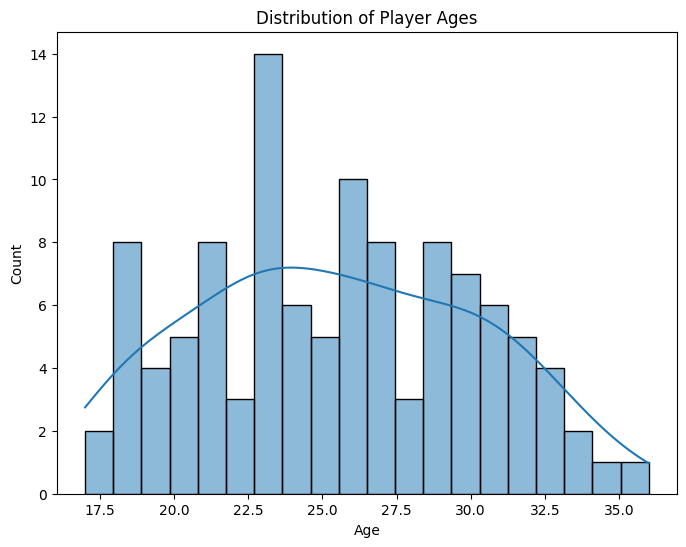

In [230]:
# 1. Distribution of player ages
plt.figure(figsize=(8, 6))
sns.histplot(best_11_by_club_22x['Age'], bins=20, kde=True)
plt.title('Distribution of Player Ages')
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()

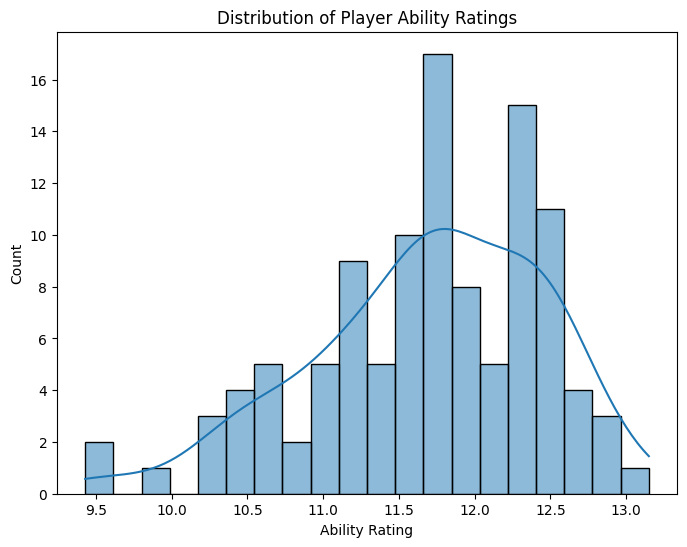

In [231]:
# 2. Distribution of player ability ratings (RoleCA)
plt.figure(figsize=(8, 6))
sns.histplot(best_11_by_club_22x['RoleCA'], bins=20, kde=True)
plt.title('Distribution of Player Ability Ratings')
plt.xlabel('Ability Rating')
plt.ylabel('Count')
plt.show()

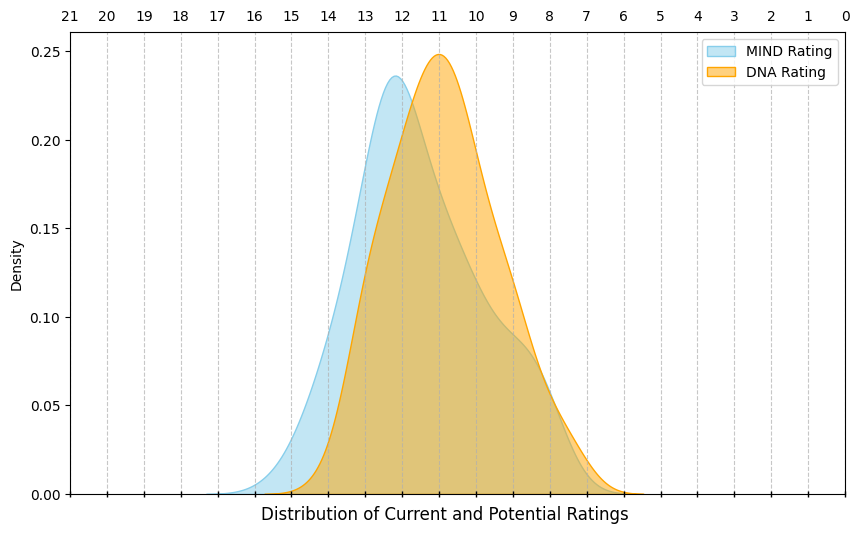

In [232]:
# 3. Distribution of player mental attributes (MIND) and player DNA attributes (DNA)

plt.figure(figsize=(10, 6))
sns.kdeplot(best_11_by_club_22x['MIND'], color='skyblue', label='MIND Rating', fill=True, alpha=0.5)
sns.kdeplot(best_11_by_club_22x['DNA'], color='orange', label='DNA Rating', fill=True, alpha=0.5)
plt.gca().invert_xaxis()

# Add title and labels
#plt.title('Distribution of Current and Potential Ratings', loc='center')
plt.suptitle('Distribution of Current and Potential Ratings', y=0.09)
plt.xlabel('')
plt.ylabel('Density')

# Add grid lines on every integer value along the x-axis
plt.grid(True, axis='x', linestyle='--', alpha=0.7)

# Set the x-ticks from 0 to 100 with a step of 5
plt.xticks(range(0, 22, 1))

# Move x-axis labels to the top
plt.tick_params(axis='x', direction='inout', length=5, width=1, labeltop=True, labelbottom=False)

# Add legend
plt.legend()

# Show the plot
plt.show()

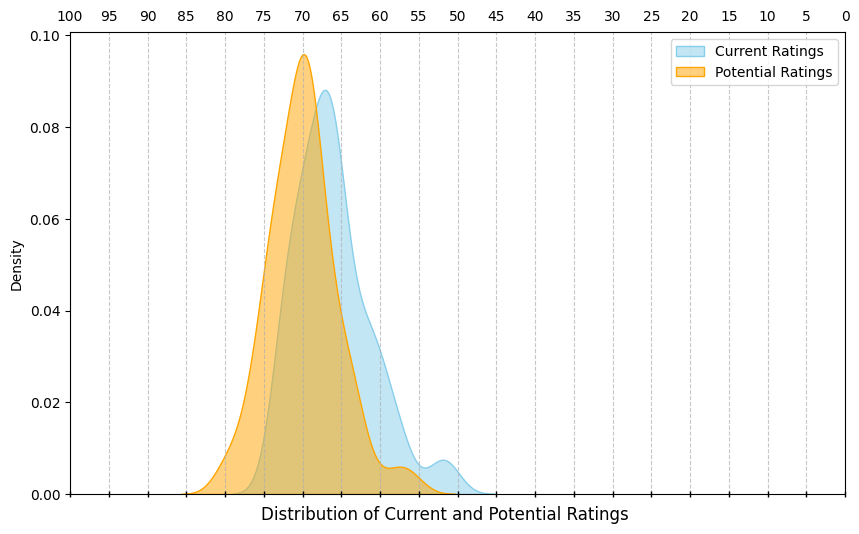

In [233]:
# 4. Distribution of Current and Potential Rating

# Set up the figure and axes
plt.figure(figsize=(10, 6))

# Plot the distribution of current ratings (RtG) using KDE plot with filled area and transparency
sns.kdeplot(best_11_by_club_22x['RtG'], color='skyblue', label='Current Ratings', fill=True, alpha=0.5)

# Plot the distribution of potential ratings (PtG) using KDE plot with filled area and transparency
sns.kdeplot(best_11_by_club_22x['PtG'], color='orange', label='Potential Ratings', fill=True, alpha=0.5)

# Invert the x-axis
plt.gca().invert_xaxis()

# Add title and labels
#plt.title('Distribution of Current and Potential Ratings', loc='center')
plt.suptitle('Distribution of Current and Potential Ratings', y=0.09)
plt.xlabel('')
plt.ylabel('Density')

# Add grid lines on every integer value along the x-axis
plt.grid(True, axis='x', linestyle='--', alpha=0.7)

# Set the x-ticks from 0 to 100 with a step of 5
plt.xticks(range(0, 101, 5))

# Move x-axis labels to the top
plt.tick_params(axis='x', direction='inout', length=5, width=1, labeltop=True, labelbottom=False)

# Add legend
plt.legend()

# Show the plot
plt.show()

## League study

In [234]:
league_counts = best_11_by_league['Division'].value_counts()
league_with_22_counts = league_counts[league_counts == 22].index.tolist()
best_11_by_league_22x = best_11_by_league[best_11_by_league['Division'].isin(league_with_22_counts)]

# List of desired combinations of Based and Division
desired_combinations = [
    ('England', 'Premier League'),
    ('Spain', 'LaLiga'),
    ('France', 'Ligue 1'),
    ('Portugal', 'Liga Portugal Bwin'),
    ('Italy', 'Serie A'),
    ('Germany', 'Bundesliga'),
    ('Netherlands', 'Eredivisie'),
    ('Brazil', 'Série A'),
    ('Belgium', 'Jupiler Pro League'),
    ('Argentina', 'Liga Profesional de Fútbol'),
    #('Turkey', 'Spor Toto Süper Lig'),
    #('Scotland', 'Premiership'),
    #('Denmark', '3F Superliga'),
    #('Austria', 'Tipico Bundesliga'),
    #('Switzerland', 'Raiffeisen Super League'),
    #('Paraguay', 'Primera División'),
    #('Colombia', 'Liga BetPlay'),
    #('Sweden', 'Allsvenskan'),
    #('Czech Republic', 'Fortuna liga'),
    #('Greece', 'Super League 1'),
    #('Ecuador', 'LigaPro Serie A'),
    #('Chile', 'Campeonato AFP PlanVital'),
    #('Uruguay', 'Liga Profesional de Primera División'),
]

mask = best_11_by_league_22x[['Based', 'Division']].apply(tuple, axis=1).isin(desired_combinations)

# Apply the mask to filter the DataFrame
best_11_by_league_22x = best_11_by_league_22x[mask]
best_11_by_league_22x['Division'] = best_11_by_league_22x['Based']

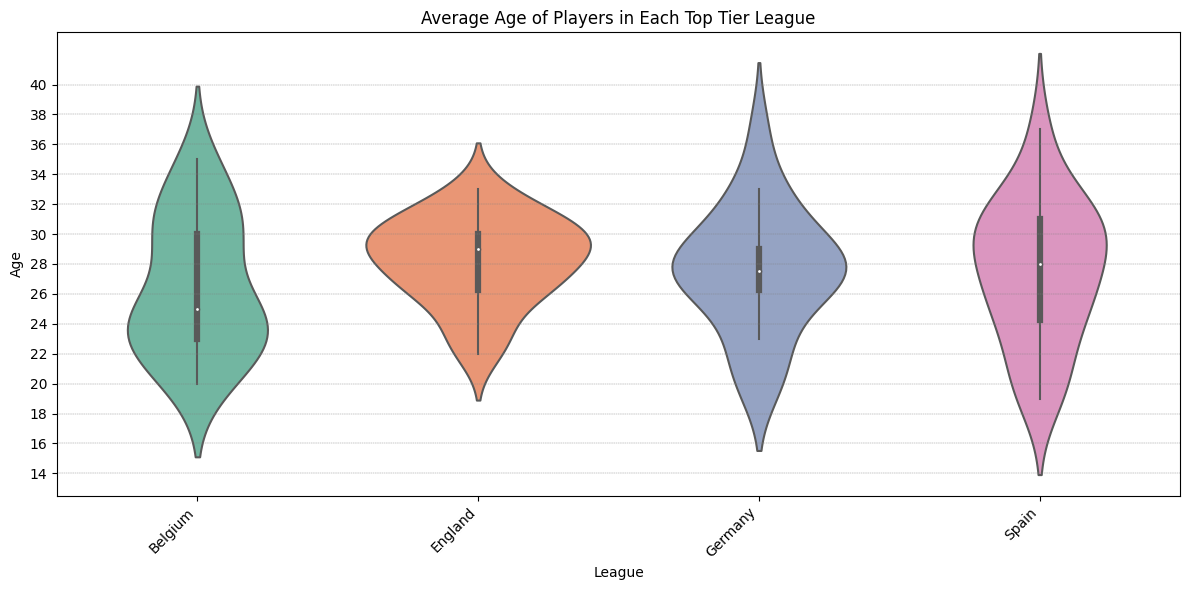

In [235]:
# 1. Age Analysis
# Compare the average age of players in each division
plt.figure(figsize=(12, 6))
sns.violinplot(x='Division', y='Age', data=best_11_by_league_22x, palette='Set2')
plt.title('Average Age of Players in Each Top Tier League')
plt.xlabel('League')
plt.ylabel('Age')
plt.xticks(rotation=45, ha='right')

# Draw lines for even numbers from 14 to 40 on Age column
even_numbers = range(14, 41, 2)
for num in even_numbers:
    plt.axhline(y=num, color='gray', linestyle='--', linewidth=0.3)

# Set y-axis ticks to even numbers from 14 to 40
plt.yticks(range(14, 41, 2))

plt.tight_layout()
plt.show()

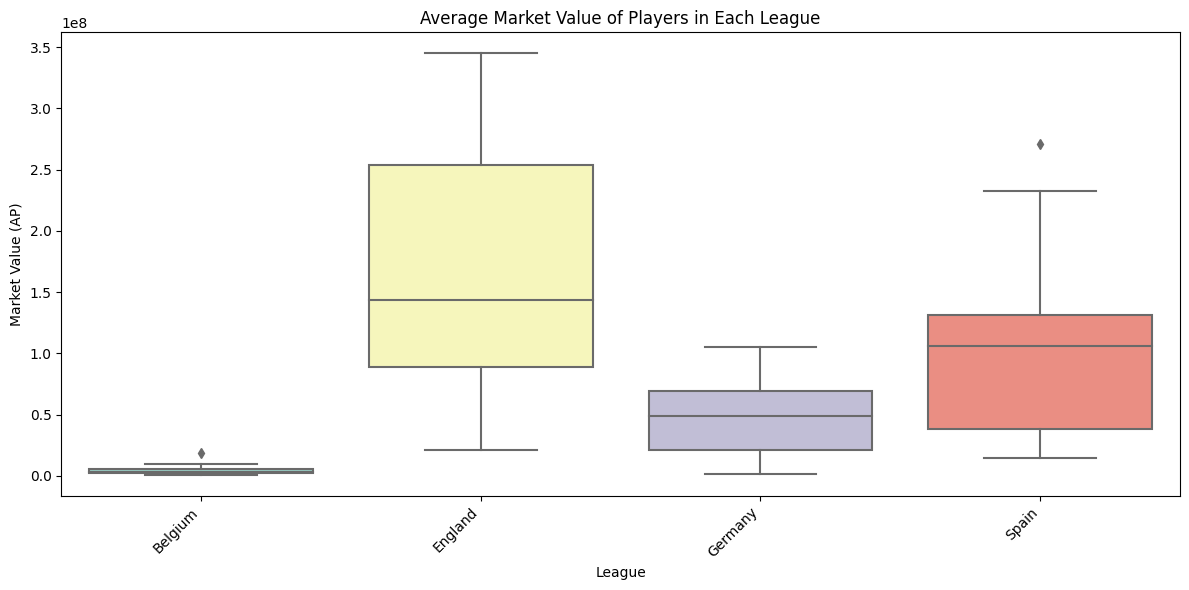

In [236]:
# 2. Market Value Analysis
# Compare the average market value of players in each division
filtered_data = best_11_by_league_22x[best_11_by_league_22x['AP'] <= 347_000_000]  # Exclude values above 347 million

# Plot the boxplot
plt.figure(figsize=(12, 6))
sns.boxplot(x='Division', y='AP', data=filtered_data, palette='Set3')
plt.title('Average Market Value of Players in Each League')
plt.xlabel('League')
plt.ylabel('Market Value (AP)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

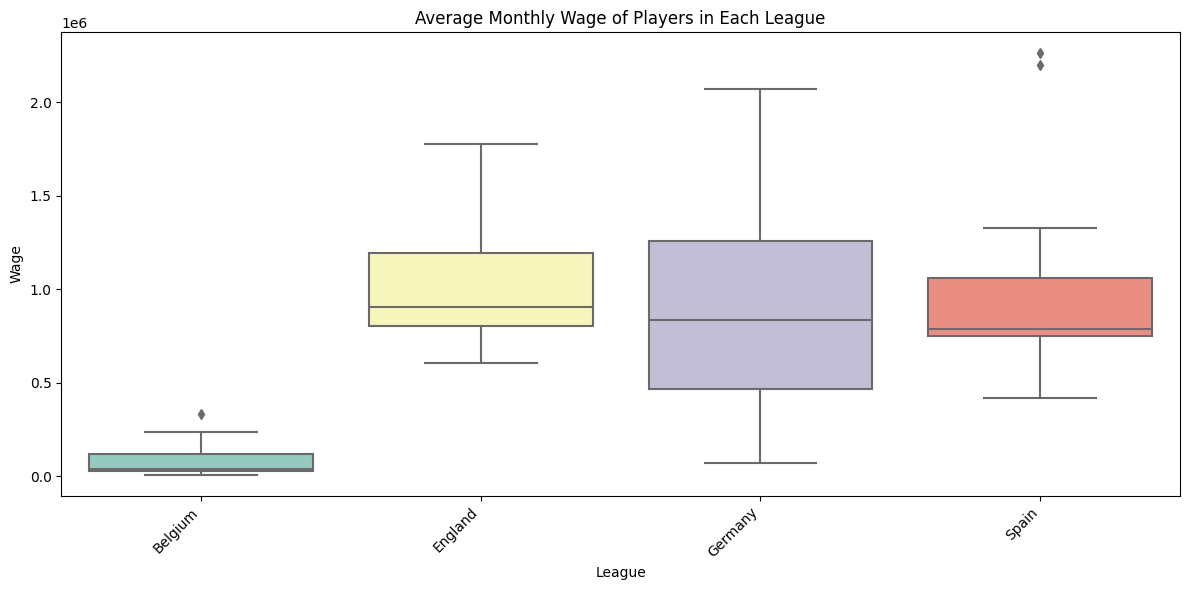

In [237]:
# 3. Wage Analysis
# Compare the average monthly wage of players in each division
plt.figure(figsize=(12, 6))
sns.boxplot(x='Division', y='Wage', data=filtered_data, palette='Set3')
plt.title('Average Monthly Wage of Players in Each League')
plt.xlabel('League')
plt.ylabel('Wage')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

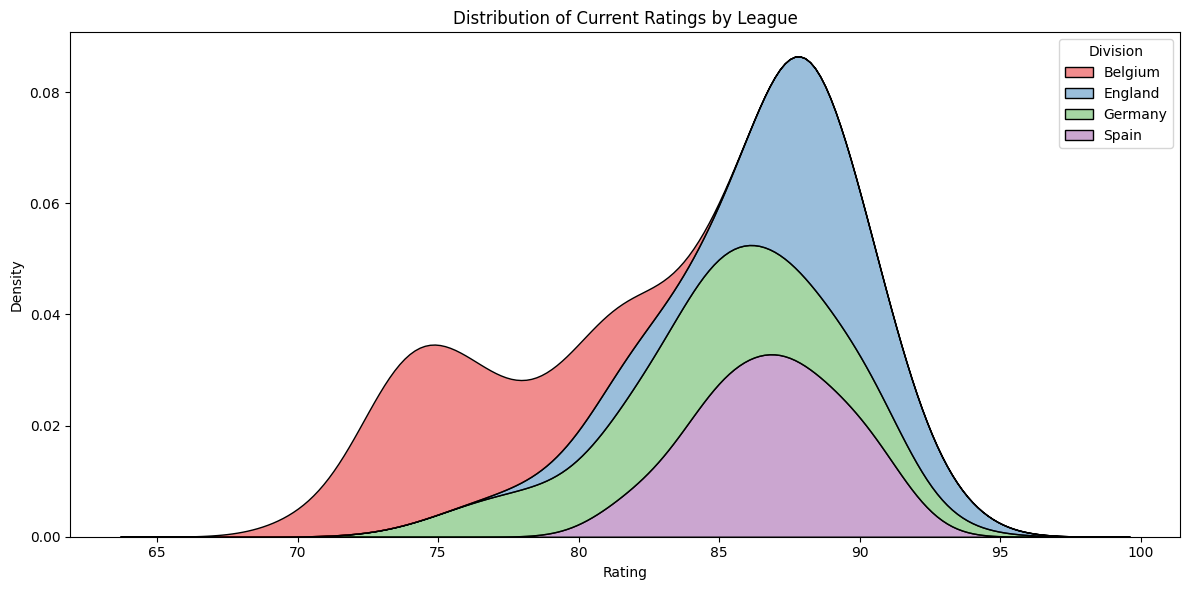

In [238]:
# 5. Player Current Rating Analysis
# Compare the distribution of current ratings of players in each division
plt.figure(figsize=(12, 6))
sns.kdeplot(data=best_11_by_league_22x, x='RtG', hue='Division', fill=True, alpha=0.5, palette='Set1', multiple='stack')
plt.title('Distribution of Current Ratings by League')
plt.xlabel('Rating')
plt.ylabel('Density')
plt.tight_layout()
plt.show()

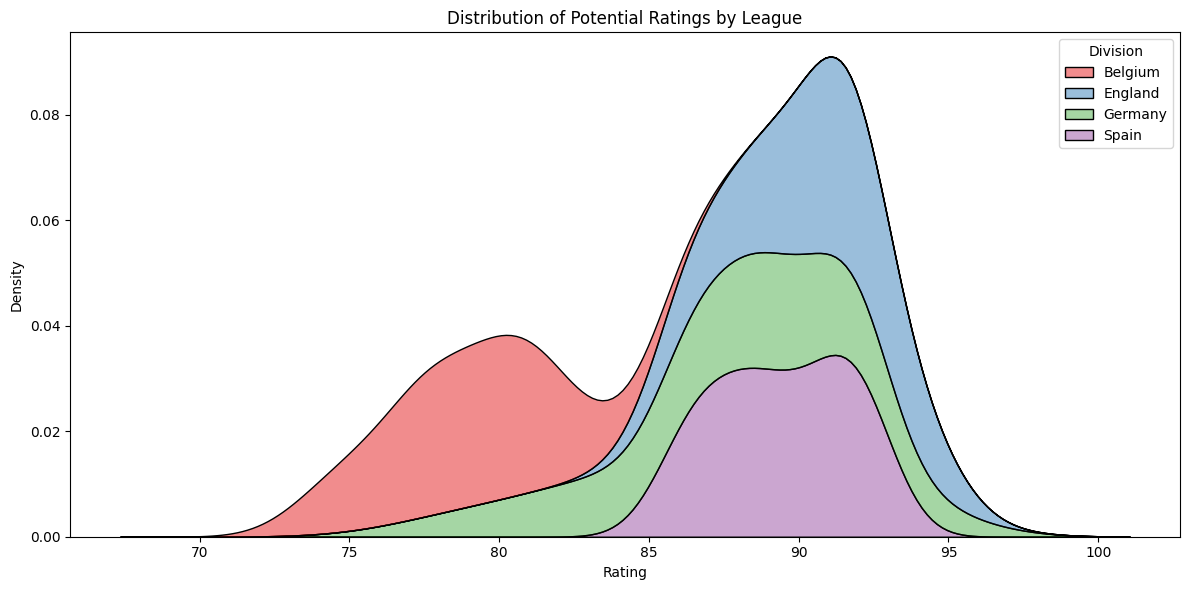

In [239]:
# 6. Player Potential Rating Analysis
# Compare the distribution of Ptential Ratings of players in each division
plt.figure(figsize=(12, 6))
sns.kdeplot(data=best_11_by_league_22x, x='PtG', hue='Division', fill=True, alpha=0.5, palette='Set1', multiple='stack')
plt.title('Distribution of Potential Ratings by League')
plt.xlabel('Rating')
plt.ylabel('Density')
plt.tight_layout()
plt.show()

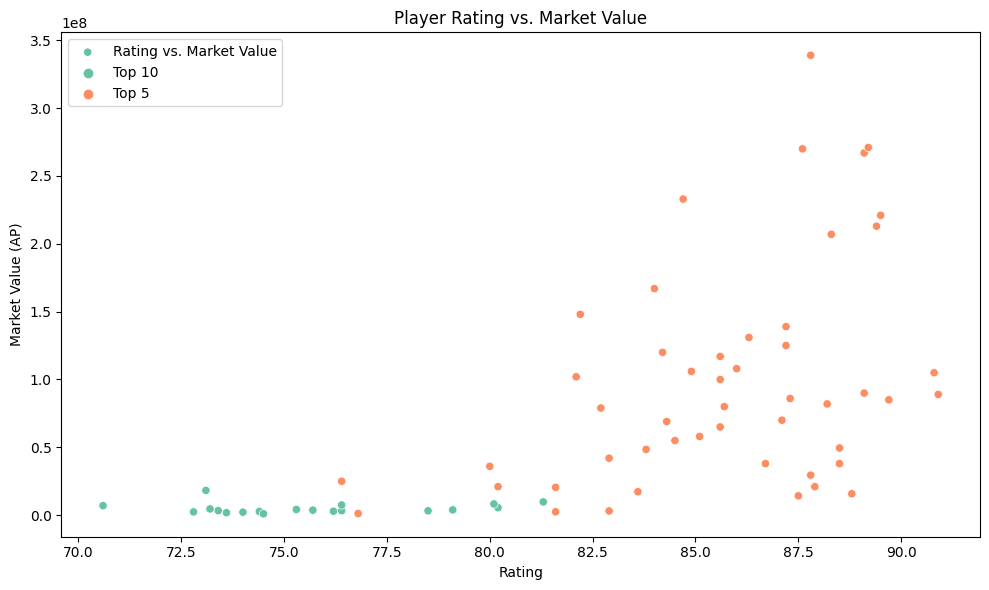

In [240]:
# 6. Market Value Distribution by Age Group:
# Define the groups based on division
top_5_divisions = ['England', 'Germany', 'Italy', 'Spain', 'France']
top_10_divisions = ['Belgium', 'Portugal', 'Netherlands', 'Brazil', 'Argentina']

# Function to assign group labels
def assign_group(division):
    if division in top_5_divisions:
        return 'Top 5'
    elif division in top_10_divisions:
        return 'Top 10'
    else:
        return 'Others'

# Apply the function to create a new column for the group
best_11_by_league_22x['Group'] = best_11_by_league_22x['Division'].apply(assign_group)
best_11_by_league_22x = best_11_by_league_22x[best_11_by_league_22x['AP'] <= 340000000].copy()

# Plot the scatter plot with grouped colors
plt.figure(figsize=(10, 6))
sns.scatterplot(x='RtG', y='AP', data=best_11_by_league_22x, hue='Group', palette='Set2', label='Rating vs. Market Value')
plt.title('Player Rating vs. Market Value')
plt.xlabel('Rating')
plt.ylabel('Market Value (AP)')
plt.legend()
plt.tight_layout()
plt.show()


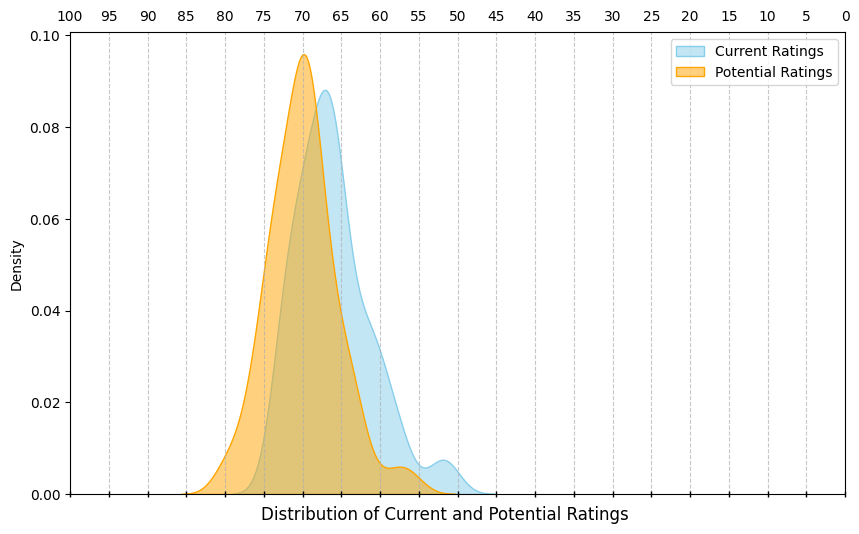

In [241]:
# 5. Distribution of Current and Potential Rating

# Set up the figure and axes
plt.figure(figsize=(10, 6))

# Plot the distribution of current ratings (RtG) using KDE plot with filled area and transparency
sns.kdeplot(best_11_by_club_22x['RtG'], color='skyblue', label='Current Ratings', fill=True, alpha=0.5)

# Plot the distribution of potential ratings (PtG) using KDE plot with filled area and transparency
sns.kdeplot(best_11_by_club_22x['PtG'], color='orange', label='Potential Ratings', fill=True, alpha=0.5)

# Invert the x-axis
plt.gca().invert_xaxis()

# Add title and labels
#plt.title('Distribution of Current and Potential Ratings', loc='center')
plt.suptitle('Distribution of Current and Potential Ratings', y=0.09)
plt.xlabel('')
plt.ylabel('Density')

# Add grid lines on every integer value along the x-axis
plt.grid(True, axis='x', linestyle='--', alpha=0.7)

# Set the x-ticks from 0 to 100 with a step of 5
plt.xticks(range(0, 101, 5))

# Move x-axis labels to the top
plt.tick_params(axis='x', direction='inout', length=5, width=1, labeltop=True, labelbottom=False)

# Add legend
plt.legend()

# Show the plot
plt.show()

# Club overview

## Starting lineup

In [243]:
style = (
    starting_lineup.drop(columns=['Date', 'Type', 'UID'])
    .style
    .background_gradient(cmap='RdYlGn', vmin=0)
    .set_properties(**{'font-size': '14px'})
    .format(precision=1)
    .set_table_styles([{
        'selector': 'thead th',  # Selects the header cells
        'props': [('background-color', 'darkred'), ('color', 'white')]
    }])
)

style

,Nat,P1,Age,Name,RtG,PtG,Det,Amb,Prof,MIND,DNA,SK_D,WB_S,CWB_S,BPD_D,CD_D,DM_D,CM_S,DLP_S,MEZ_A,VOL_S,AM_A,EG_S,IW_A,IF_A,AF_A
8,Germany,GK,26,Marco Hiller,68.9,71.3,15,14,14,14.3,11.4,11.7,7.5,8.3,8.5,8.6,9.3,9.2,9.5,8.2,7.8,8.0,9.1,8.1,8.0,7.1
1,Germany,RB,27,Morris Schröter,72.5,74.8,9,9,8,8.7,11.0,6.1,11.8,12.4,11.0,11.1,11.8,11.7,11.6,11.5,11.5,11.3,11.6,11.6,11.4,11.0
9,Netherlands,CB,27,Jesper Verlaat,67.8,70.1,12,13,12,12.3,12.2,6.3,10.1,10.2,12.1,12.5,11.6,10.7,10.9,9.5,10.7,9.3,10.3,9.3,9.4,9.4
43,Germany,CB,26,Leroy Kwadwo,67.2,71.8,14,13,13,13.3,10.4,6.4,10.7,10.9,11.3,11.8,11.8,10.8,10.6,10.0,11.1,9.8,10.4,10.2,10.1,9.5
18,Germany,LB,23,Kilian Ludewig,72.2,80.4,13,13,11,12.3,11.4,7.0,12.0,12.6,11.1,11.2,11.9,11.9,11.8,11.5,11.5,11.3,11.8,11.8,11.6,11.5
17,Germany,DM,27,Marlon Frey,68.9,71.5,14,12,11,12.3,12.2,6.5,11.0,11.8,10.5,10.2,11.1,11.9,12.0,11.4,10.7,11.4,11.9,11.5,11.1,10.7
26,Germany,CM,25,Niklas Tarnat,67.7,70.4,11,10,13,11.3,12.8,7.1,11.6,11.9,11.6,11.6,12.3,12.2,12.1,11.3,11.8,11.2,11.8,11.4,11.1,10.7
35,Italy,CM,18,Vasco Walz,66.2,74.3,8,11,11,10.0,11.8,7.5,11.4,12.3,10.3,9.9,11.5,12.4,12.1,11.8,11.1,11.6,12.0,11.7,11.7,11.6
47,Kosovo,RW,29,Albion Vrenezi,71.8,76.2,15,17,14,15.3,10.6,6.5,11.5,12.7,10.3,10.1,11.3,12.3,11.9,12.0,11.0,12.1,12.1,12.6,12.3,12.0
10,Germany,LW,23,Julian Guttau,72.2,76.2,8,12,11,10.3,11.6,7.3,11.8,12.9,11.7,11.4,11.5,12.8,12.6,13.0,11.7,13.0,13.0,12.8,13.2,14.1


## Bench lineup

In [244]:
style = (
    bench_lineup.drop(columns=['Date', 'Type', 'UID'])
    .style
    .background_gradient(cmap='RdYlGn', vmin=0)
    .set_properties(**{'font-size': '14px'})
    .format(precision=1)
    .set_table_styles([{
        'selector': 'thead th',  # Selects the header cells
        'props': [('background-color', 'darkred'), ('color', 'white')]
    }])
)

style

,Nat,P1,Age,Name,RtG,PtG,Det,Amb,Prof,MIND,DNA,SK_D,WB_S,CWB_S,BPD_D,CD_D,DM_D,CM_S,DLP_S,MEZ_A,VOL_S,AM_A,EG_S,IW_A,IF_A,AF_A
49,Germany,GK,24,David Richter,60.5,65.3,17,12,9,12.7,8.2,11.2,6.4,6.8,8.5,8.8,7.9,7.6,7.8,6.7,7.0,6.3,7.5,7.0,6.7,6.8
62,Germany,RB,21,Kaan Kurt,68.9,76.4,10,11,10,10.3,9.4,6.4,11.6,12.3,10.0,9.7,11.1,11.4,11.3,11.4,11.1,11.2,11.5,11.7,11.3,10.9
7,Germany,CB,29,Tim Rieder,66.7,69.2,11,13,13,12.3,12.2,6.3,10.7,10.8,11.3,11.6,11.6,10.7,10.6,9.7,10.8,9.4,10.1,9.8,9.5,8.9
38,Spain,CB,19,Carlos Gallego,66.6,73.3,15,13,10,12.8,9.8,6.8,10.3,10.6,11.4,11.4,11.3,10.8,10.9,9.7,10.7,9.4,10.4,10.0,9.8,9.7
18,Germany,LB,30,Phillipp Steinhart,68.4,70.3,12,13,13,12.7,10.6,6.5,10.5,10.8,10.9,11.0,11.0,10.7,10.6,10.0,10.6,9.8,10.4,10.4,9.8,9.2
69,Austria,DM,20,Michael Glück,61.6,71.5,4,10,11,8.3,11.2,7.4,10.7,10.8,11.5,11.8,11.9,11.2,11.1,10.3,11.5,10.2,10.9,10.3,10.2,9.9
26,Germany,CM,23,Fynn Lakenmacher,66.7,72.1,18,11,11,13.3,11.6,6.2,10.8,11.5,11.2,11.3,10.7,11.2,11.2,11.2,10.8,10.8,11.0,10.8,11.3,11.6
84,Germany,CM,24,Noah Feil,60.3,63.8,13,13,11,12.3,8.6,6.2,9.8,10.7,9.6,9.3,10.4,11.2,10.8,10.8,10.4,10.8,10.9,10.5,10.5,10.7
47,Kosovo,RW,27,Valmir Sulejmani,65.9,70.8,9,14,10,11.0,10.4,6.2,10.2,11.3,8.9,8.7,9.8,10.9,10.7,11.0,9.6,11.2,11.0,11.1,11.1,10.8
12,Namibia,LW,32,Manfred Starke,71.4,71.8,14,11,11,12.0,12.0,6.8,12.0,12.9,11.0,11.1,12.0,12.3,12.2,12.5,11.8,12.3,12.2,12.3,12.5,11.8


## Third lineup

In [245]:
style = (
    third_lineup.drop(columns=['Date', 'Type', 'UID'])
    .style
    .background_gradient(cmap='RdYlGn', vmin=0)
    .set_properties(**{'font-size': '14px'})
    .format(precision=1)
    .set_table_styles([{
        'selector': 'thead th',  # Selects the header cells
        'props': [('background-color', 'darkred'), ('color', 'white')]
    }])
)

style

,Nat,P1,Age,Name,RtG,PtG,Det,Amb,Prof,MIND,DNA,SK_D,WB_S,CWB_S,BPD_D,CD_D,DM_D,CM_S,DLP_S,MEZ_A,VOL_S,AM_A,EG_S,IW_A,IF_A,AF_A
55,Germany,GK,18,Noah Dotzauer,58.6,69.6,14,9,11,11.3,7.5,9.9,5.7,5.9,8.0,8.2,6.8,6.5,6.6,6.1,6.2,6.0,6.6,6.2,5.8,6.1
57,Germany,RB,19,Denis Milic,58.8,67.7,11,12,12,11.7,10.1,6.7,9.0,9.6,9.7,9.4,9.9,10.1,10.0,9.9,10.1,9.5,9.8,9.3,9.3,8.8
40,Germany,CB,21,Niklas Lang,65.3,69.7,16,14,13,14.3,11.4,6.7,10.4,10.3,11.7,12.3,11.0,10.1,10.0,9.3,10.6,9.2,9.8,9.7,9.3,9.3
53,Germany,CB,19,Faroukou Cissé,64.0,72.2,5,10,11,8.7,11.0,7.2,10.4,10.6,10.6,10.7,10.8,10.8,10.5,9.8,10.7,9.7,10.4,10.1,9.8,9.5
99,Serbia,LB,20,Miloš Ćoćić,64.5,72.6,13,12,14,13.0,10.4,7.6,10.3,11.1,9.9,9.3,9.9,10.9,10.8,10.9,10.0,11.0,11.0,11.0,11.1,11.7
69,Germany,DM,18,Levin Mattmüller,57.1,66.4,15,11,9,11.7,9.8,6.8,8.9,9.1,9.4,9.4,9.8,9.7,9.7,9.2,9.8,9.0,9.6,8.8,8.8,8.9
113,England,CM,18,Mathew Collins,57.6,60.1,13,13,13,13.0,8.8,5.3,9.8,10.9,7.7,7.2,9.2,10.8,10.5,10.3,9.2,10.2,10.6,10.4,10.2,9.9
125,Germany,CM,18,Max Jägerbauer,56.9,64.8,10,11,12,11.0,9.4,6.7,9.9,11.1,9.3,8.8,9.8,11.4,11.3,11.2,10.1,11.1,11.4,11.1,11.1,11.0
47,Germany,RW,26,Tarsis Bonga,65.3,67.5,14,12,11,12.3,9.8,5.9,10.4,11.1,11.0,11.3,10.7,10.6,10.5,10.4,10.4,10.2,10.3,10.4,10.6,10.3
45,Kosovo,LW,28,Eroll Zejnullahu,65.8,68.6,8,11,11,10.0,11.2,6.6,10.8,11.8,9.3,8.7,10.4,11.6,11.4,11.6,10.3,11.6,11.6,11.6,11.4,11.1


## Potential lineup

In [246]:
style = (
    potential_lineup.drop(columns=['Date', 'Type', 'UID'])
    .style
    .background_gradient(cmap='RdYlGn', vmin=0)
    .set_properties(**{'font-size': '14px'})
    .format(precision=1)
    .set_table_styles([{
        'selector': 'thead th',  # Selects the header cells
        'props': [('background-color', 'darkred'), ('color', 'white')]
    }])
)

style

,Nat,P1,Age,Name,RtG,PtG,Det,Amb,Prof,MIND,DNA,SK_D,WB_S,CWB_S,BPD_D,CD_D,DM_D,CM_S,DLP_S,MEZ_A,VOL_S,AM_A,EG_S,IW_A,IF_A,AF_A
55,Germany,GK,18,Noah Dotzauer,58.6,69.6,14,9,11,11.3,7.5,9.9,5.7,5.9,8.0,8.2,6.8,6.5,6.6,6.1,6.2,6.0,6.6,6.2,5.8,6.1
120,Germany,GK,19,Maximilian Rothdauscher,48.6,57.8,4,11,10,8.3,7.6,9.1,5.0,5.3,5.9,6.0,6.0,5.9,5.9,5.5,5.2,5.3,6.0,5.8,5.3,5.1
62,Germany,RB,21,Kaan Kurt,68.9,76.4,10,11,10,10.3,9.4,6.4,11.6,12.3,10.0,9.7,11.1,11.4,11.3,11.4,11.1,11.2,11.5,11.7,11.3,10.9
131,Germany,RB,15,Nicolas Müller,51.9,74.5,16,9,12,12.3,8.8,4.1,7.8,8.1,8.1,8.1,7.8,8.1,7.8,6.9,7.1,6.6,7.3,7.1,6.3,6.0
38,Spain,CB,19,Carlos Gallego,66.6,73.3,15,13,10,12.8,9.8,6.8,10.3,10.6,11.4,11.4,11.3,10.8,10.9,9.7,10.7,9.4,10.4,10.0,9.8,9.7
53,Germany,CB,19,Faroukou Cissé,64.0,72.2,5,10,11,8.7,11.0,7.2,10.4,10.6,10.6,10.7,10.8,10.8,10.5,9.8,10.7,9.7,10.4,10.1,9.8,9.5
42,Austria,CB,20,Michael Glück,61.6,71.5,4,10,11,8.3,11.2,7.4,10.7,10.8,11.5,11.8,11.9,11.2,11.1,10.3,11.5,10.2,10.9,10.3,10.2,9.9
40,Germany,CB,21,Niklas Lang,65.3,69.7,16,14,13,14.3,11.4,6.7,10.4,10.3,11.7,12.3,11.0,10.1,10.0,9.3,10.6,9.2,9.8,9.7,9.3,9.3
75,Germany,LB,19,Luis Biehl,58.1,67.7,11,12,12,11.7,10.2,7.1,10.1,10.7,9.2,9.1,10.2,10.8,10.8,10.0,9.8,9.7,10.6,10.6,9.6,9.7
96,Germany,LB,19,Moritz Rem,55.3,67.2,7,13,10,10.0,9.4,6.2,9.7,10.1,9.1,9.1,9.6,9.8,9.7,9.8,9.5,9.5,9.9,9.8,9.5,9.9


## Players by rating

In [247]:
style = (
    club_all.head(top_n)
    .style
    .background_gradient(cmap='RdYlGn', vmin=0)
    .set_properties(**{'font-size': '14px'})
    .format(precision=1)
    .set_table_styles([{
        'selector': 'thead th',  # Selects the header cells
        'props': [('background-color', 'darkred'), ('color', 'white')]
    }])
)

style

,Flt,Position,P1,P2,RtG,PtG,Nat,Age,Name,Av Rat,Apps,Gls,Ast,Club,AP,Wage,Det,Amb,Prof,Expires,SK_D,WB_S,CWB_S,BPD_D,CD_D,DM_D,CM_S,DLP_S,MEZ_A,VOL_S,AM_A,EG_S,IW_A,IF_A,AF_A,GK%,DFg%,DFa%,PAS%,DRB%,ST%,UID,MIND,DNA
1,1,"D/WB (R), M/AM (RC)",RB,RW,72.5,74.8,Germany,27,Morris Schröter,6.9,20,2,0,1860 München,€ 300k,€ 17k,9,9,8,2025-06-30,6.1,11.8,12.4,11.0,11.1,11.8,11.7,11.6,11.5,11.5,11.3,11.6,11.6,11.4,11.0,0.0,7.0,10.2,5.0,7.2,1.2,91137671,8.7,11.0
10,1,"M (L), AM (LC)",LW,RW,72.2,76.2,Germany,23,Julian Guttau,7.1,32 (8),10,3,1860 München,€ 135k,€ 10k,8,12,11,2024-06-30,7.3,11.8,12.9,11.7,11.4,11.5,12.8,12.6,13.0,11.7,13.0,13.0,12.8,13.2,14.1,0.0,7.4,10.5,4.9,6.4,2.0,92099175,10.3,11.6
11,0,"D (RL), WB/M (R)",RB,LB,72.2,80.4,Germany,23,Kilian Ludewig,6.9,36 (2),3,4,1860 München,€ 600k,€ 5k,13,13,11,2023-06-30,7.0,12.0,12.6,11.1,11.2,11.9,11.9,11.8,11.5,11.5,11.3,11.8,11.8,11.6,11.5,0.0,9.4,12.6,5.2,7.2,0.5,91172585,12.3,11.4
2,1,M/AM (RL),LW,RW,71.8,76.2,Kosovo,29,Albion Vrenezi,7.2,44,12,4,1860 München,€ 425k,€ 11k,15,17,14,2024-06-30,6.5,11.5,12.7,10.3,10.1,11.3,12.3,11.9,12.0,11.0,12.1,12.1,12.6,12.3,12.0,0.0,6.2,9.0,3.9,7.5,1.9,92090245,15.3,10.6
12,0,"AM (LC), ST (C)",LW,AM,71.4,71.8,Namibia,32,Manfred Starke,7.0,39 (2),10,4,1860 München,€ 61k,€ 14k,14,11,11,2024-06-30,6.8,12.0,12.9,11.0,11.1,12.0,12.3,12.2,12.5,11.8,12.3,12.2,12.3,12.5,11.8,0.0,6.0,9.2,4.1,3.9,1.8,92018221,12.0,12.0
17,0,"DM, M/AM (C)",DM,CM,68.9,71.5,Germany,27,Marlon Frey,6.9,27 (13),1,11,1860 München,€ 64k,€ 12k,14,12,11,2024-06-30,6.5,11.0,11.8,10.5,10.2,11.1,11.9,12.0,11.4,10.7,11.4,11.9,11.5,11.1,10.7,0.0,6.3,8.8,8.0,2.5,0.5,91138205,12.3,12.2
62,1,D/WB (R),RB,LB,68.9,76.4,Germany,21,Kaan Kurt,6.5,2 (11),0,0,1860 München,€ 135k,€ 10k,10,11,10,2024-06-30,6.4,11.6,12.3,10.0,9.7,11.1,11.4,11.3,11.4,11.1,11.2,11.5,11.7,11.3,10.9,0.0,9.1,12.7,5.6,4.2,0.4,91177049,10.3,9.4
8,0,GK,GK,GK,68.9,71.3,Germany,26,Marco Hiller,6.8,43,0,0,1860 München,€ 110k,€ 10k,15,14,14,2024-06-30,11.7,7.5,8.3,8.5,8.6,9.3,9.2,9.5,8.2,7.8,8.0,9.1,8.1,8.0,7.1,-0.1,0.0,0.0,0.6,0.4,0.0,91175665,14.3,11.4
18,0,"D (LC), WB (L), DM, M (LC)",LB,CB,68.4,70.3,Germany,30,Phillipp Steinhart,6.9,41,1,2,1860 München,€ 74k,€ 11k,12,13,13,2024-06-30,6.5,10.5,10.8,10.9,11.0,11.0,10.7,10.6,10.0,10.6,9.8,10.4,10.4,9.8,9.2,0.0,9.2,14.2,7.3,5.4,0.2,35017459,12.7,10.6
9,0,D (C),CB,DM,67.8,70.1,Netherlands,27,Jesper Verlaat,6.8,21,0,1,1860 München,€ 110k,€ 14k,12,13,12,2024-06-30,6.3,10.1,10.2,12.1,12.5,11.6,10.7,10.9,9.5,10.7,9.3,10.3,9.3,9.4,9.4,0.0,6.8,15.9,4.6,0.9,0.3,91126295,12.3,12.2


## Players by potential

In [248]:
style = (
    club_all[club_all['Age'] <= 23].sort_values(by='PtG', ascending=False).head(top_n)
    .style
    .background_gradient(cmap='RdYlGn', vmin=0)
    .set_properties(**{'font-size': '14px'})
    .format(precision=1)
    .set_table_styles([{
        'selector': 'thead th',  # Selects the header cells
        'props': [('background-color', 'darkred'), ('color', 'white')]
    }])
)

style

,Flt,Position,P1,P2,RtG,PtG,Nat,Age,Name,Av Rat,Apps,Gls,Ast,Club,AP,Wage,Det,Amb,Prof,Expires,SK_D,WB_S,CWB_S,BPD_D,CD_D,DM_D,CM_S,DLP_S,MEZ_A,VOL_S,AM_A,EG_S,IW_A,IF_A,AF_A,GK%,DFg%,DFa%,PAS%,DRB%,ST%,UID,MIND,DNA
11,0,"D (RL), WB/M (R)",RB,LB,72.2,80.4,Germany,23,Kilian Ludewig,6.9,36 (2),3,4,1860 München,€ 600k,€ 5k,13,13,11,2023-06-30,7.0,12.0,12.6,11.1,11.2,11.9,11.9,11.8,11.5,11.5,11.3,11.8,11.8,11.6,11.5,0.0,9.4,12.6,5.2,7.2,0.5,91172585,12.3,11.4
65,1,ST (C),ST,AM,63.7,76.6,Bosnia and Herzegovina,18,Semin Kojic,0.0,0,0,0,1860 München,€ 0,€ 0,6,10,9,2023-06-25,5.4,9.5,10.6,9.6,9.4,9.3,10.4,10.3,10.6,9.4,10.6,10.5,10.4,10.9,11.1,0.0,0.0,0.0,0.0,0.0,0.0,2000174831,8.3,8.6
62,1,D/WB (R),RB,LB,68.9,76.4,Germany,21,Kaan Kurt,6.5,2 (11),0,0,1860 München,€ 135k,€ 10k,10,11,10,2024-06-30,6.4,11.6,12.3,10.0,9.7,11.1,11.4,11.3,11.4,11.1,11.2,11.5,11.7,11.3,10.9,0.0,9.1,12.7,5.6,4.2,0.4,91177049,10.3,9.4
10,1,"M (L), AM (LC)",LW,RW,72.2,76.2,Germany,23,Julian Guttau,7.1,32 (8),10,3,1860 München,€ 135k,€ 10k,8,12,11,2024-06-30,7.3,11.8,12.9,11.7,11.4,11.5,12.8,12.6,13.0,11.7,13.0,13.0,12.8,13.2,14.1,0.0,7.4,10.5,4.9,6.4,2.0,92099175,10.3,11.6
70,1,AM (RLC),LW,RW,64.5,74.8,Kyrgyzstan,17,Beknaz Almazbekov,0.0,0,0,0,1860 München,€ 0,€ 0,16,9,10,2023-06-24,5.9,10.0,10.9,9.1,8.9,9.9,10.8,10.7,10.7,9.7,10.5,10.7,10.7,10.8,11.0,0.0,0.0,0.0,0.0,0.0,0.0,2000218802,11.7,10.4
131,1,D (RLC),RB,LB,51.9,74.5,Germany,15,Nicolas Müller,0.0,0,0,0,1860 München,€ 57k,€ 275,16,9,12,2025-06-30,4.1,7.8,8.1,8.1,8.1,7.8,8.1,7.8,6.9,7.1,6.6,7.3,7.1,6.3,6.0,0.0,0.0,0.0,0.0,0.0,0.0,2002069959,12.3,8.8
35,0,"DM, M (C)",CM,DM,66.2,74.3,Italy,18,Vasco Walz,0.0,0,0,0,1860 München,€ 0,€ 0,8,11,11,2023-06-23,7.5,11.4,12.3,10.3,9.9,11.5,12.4,12.1,11.8,11.1,11.6,12.0,11.7,11.7,11.6,0.0,0.0,0.0,0.0,0.0,0.0,2000146950,10.0,11.8
72,1,"M (R), AM (RL), ST (C)",RW,LW,61.3,73.7,Turkey,19,Devin Sür,0.0,0,0,0,1860 München,€ 155k,€ 4k,7,11,12,2024-06-30,5.8,9.2,10.4,7.8,7.5,8.9,10.5,10.0,10.4,9.0,10.5,10.4,10.5,10.6,10.3,0.0,0.0,0.0,0.0,0.0,0.0,2000100675,10.0,7.6
132,1,AM (L),LW,CM,48.1,73.4,Germany,15,Hans-Jürgen Vogel,0.0,0,0,0,1860 München,€ 38k,€ 275,4,4,12,2025-06-30,4.4,7.8,9.1,7.0,6.4,7.2,9.2,8.6,8.7,7.2,8.6,8.8,8.9,8.8,9.4,0.0,0.0,0.0,0.0,0.0,0.0,2002069960,6.7,6.0
38,1,D (C),CB,RB,66.6,73.3,Spain,19,Carlos Gallego,0.0,0,0,0,1860 München,€ 0,€ 0,15,13,10,2023-06-29,6.8,10.3,10.6,11.4,11.4,11.3,10.8,10.9,9.7,10.7,9.4,10.4,10.0,9.8,9.7,0.0,0.0,0.0,0.0,0.0,0.0,2000058406,12.8,9.8


## Players on loan

In [249]:
style = (
    club_loan.head(top_n)
    .style
    .background_gradient(cmap='RdYlGn', vmin=0)
    .set_properties(**{'font-size': '14px'})
    .format(precision=1)
    .set_table_styles([{
        'selector': 'thead th',  # Selects the header cells
        'props': [('background-color', 'darkblue'), ('color', 'white')]
    }])
)

style

,Flt,Position,P1,P2,RtG,PtG,Nat,Age,Name,Av Rat,Apps,Gls,Ast,Club,AP,Wage,Det,Amb,Prof,Expires,GK,CB,RB,LB,DM,CM,AM,RW,LW,ST,GK%,DFg%,DFa%,PAS%,DRB%,ST%


# Goalkeepers

## Club

In [250]:
style = (
    club_gk
    .sort_values(by=role_gk, ascending=False)
    .head(top_n)
    .style
    .background_gradient(cmap='RdYlGn', vmin=0)
    .set_properties(**{'font-size': '14px'})
    .format(precision=1)
    .set_table_styles([{
        'selector': 'thead th',  # Selects the header cells
        'props': [('background-color', 'darkred'), ('color', 'white')]
    }])
)

style

,Flt,Position,P1,P2,RtG,PtG,Nat,Age,Name,Av Rat,Apps,Gls,Ast,Club,AP,Wage,Det,Amb,Prof,Expires,GK%,GK,SK_D,Height,Agi,Ref,1v1,Ant,Pos,CS,Conc,xGP_90
8,0,GK,GK,GK,68.9,71.3,Germany,26,Marco Hiller,6.8,43,0,0,1860 München,€ 110k,€ 10k,15,14,14,2024-06-30,-0.1,68.9,11.7,189,11,14,13,12,13,9,46,0.2
49,0,GK,GK,GK,60.5,65.3,Germany,24,David Richter,6.8,0 (5),0,0,1860 München,€ 34k,€ 3k,17,12,9,2024-06-30,0.0,60.5,11.2,196,16,13,12,7,13,4,1,0.5
64,0,GK,GK,GK,55.2,65.3,Finland,22,Julius Schmid,6.7,34,0,0,1860 München II,€ 14k,€ 2k,10,10,11,2024-06-30,0.3,55.2,10.1,185,9,13,11,7,10,11,33,0.3
55,1,GK,GK,GK,58.6,69.6,Germany,18,Noah Dotzauer,0.0,0,0,0,1860 München,€ 0,€ 0,14,9,11,2023-07-02,0.0,56.8,9.9,195,13,13,11,6,12,0,0,0.0
81,0,GK,GK,GK,51.5,54.6,Germany,27,Joey Brenner,7.2,0 (1),0,0,1860 München II,€ 0,€ 575,14,9,11,2023-06-30,0.0,51.5,9.3,196,8,13,9,7,8,1,0,0.3
87,0,GK,GK,GK,51.2,55.8,Kosovo,18,Erion Avdija,0.0,0,0,0,1860 München,€ 9k,€ 2k,10,10,13,2024-06-30,0.0,51.2,9.3,180,15,13,3,6,7,0,0,0.0
120,0,GK,GK,GK,48.6,57.8,Germany,19,Maximilian Rothdauscher,0.0,0,0,0,1860 München II,€ 0,€ 875,4,11,10,2023-06-30,0.0,48.6,9.1,186,14,12,7,7,5,0,0,0.0
126,0,GK,GK,GK,48.7,56.4,Germany,19,Muck Riedmüller,0.0,0,0,0,1860 München II,€ 6k,€ 2k,14,9,9,2024-06-30,0.0,48.7,8.3,188,7,13,9,7,4,0,0,0.0
134,0,GK,GK,GK,41.3,42.2,Germany,15,Gil Maul,0.0,0,0,0,1860 München,€ 0,€ 275,11,9,10,2025-06-30,0.0,41.3,7.0,179,3,14,5,4,6,0,0,0.0


## Scouting

In [251]:
style = (
    scout_gk_compare
    .sort_values(by=role_gk, ascending=False)
    .head(top_n)
    .style
    .background_gradient(cmap='RdYlGn', vmin=0)
    .set_properties(**{'font-size': '14px'})
    .format(precision=1)
    .set_table_styles([{
        'selector': 'thead th',  # Selects the header cells
        'props': [('background-color', 'darkblue'), ('color', 'white')]
    }])
)

style

,Int,Flt,Known,Variance,Position,P1,P2,OVR,Nat,Age,Name,Av Rat,Apps,Gls,Ast,Club,Division,AP,Wage,Det,Amb,Prof,Expires,GK%,SK_D,Height,Agi,Ref,1v1,Ant,Pos
8,0,0,1,0.0,GK,GK,GK,68.9,Germany,26,Marco Hiller,6.8,43,0,0,1860 München,3. Liga,€ 110k,€ 10k,15,14,14,2024-06-30,-0.1,11.7,189,11,14,13,12,13
1270,1,0,0,4.4,GK,GK,GK,69.3,Turkey,28,Onurcan Piri,0.0,0,0,0,nan,nan,€ 0,€ 0,9,11,8,NaT,0.0,11.5,190,13,15,12,9,12
2302,1,0,0,3.3,GK,GK,GK,57.4,Cyprus,21,Stefanos Kittos,0.0,0,0,0,APOEL,Cyta Championship,€ 0,€ 0,2,10,14,NaT,0.0,11.3,186,16,15,12,6,12
431,1,0,0,4.3,GK,GK,GK,66.1,Germany,23,Lennart Moser,0.0,0,0,0,nan,nan,€ 0,€ 0,12,11,10,NaT,0.0,11.3,196,11,13,13,11,10
1724,1,0,0,3.2,GK,GK,GK,64.3,Germany,25,Constantin Frommann,0.0,0,0,0,nan,nan,€ 0,€ 0,15,15,13,NaT,0.0,11.2,185,11,13,11,11,12
49,0,0,1,0.0,GK,GK,GK,60.5,Germany,24,David Richter,6.8,0 (5),0,0,1860 München,3. Liga,€ 34k,€ 3k,17,12,9,2024-06-30,0.0,11.2,196,16,13,12,7,13
1657,1,0,0,3.1,GK,GK,GK,59.4,Germany,27,Daniel Mesenhöler,0.0,0,0,0,nan,nan,€ 0,€ 0,12,12,10,NaT,0.0,10.7,187,10,13,13,11,13
1892,1,0,0,3.2,GK,GK,GK,57.2,Germany,23,Julian Bauer,0.0,0,0,0,nan,nan,€ 0,€ 0,6,11,11,NaT,0.0,10.3,187,15,12,7,10,8
1825,1,0,0,3.1,GK,GK,GK,56.1,Germany,22,Sebastian Hornung,0.0,0,0,0,SC Freiburg II,3. Liga,€ 8k,€ 6k,11,13,11,2024-06-30,0.0,10.3,184,13,13,6,8,12
1688,1,0,0,3.3,GK,GK,GK,55.4,Germany,28,Robin Heller,0.0,0,0,0,nan,nan,€ 0,€ 0,12,13,11,NaT,0.0,10.3,189,12,14,13,4,9


# Right backs

## Club

In [252]:
style = (
    club_rb
    .sort_values(by=role_rb, ascending=False)
    .head(top_n)
    .style
    .background_gradient(cmap='RdYlGn', vmin=0)
    .set_properties(**{'font-size': '14px'})
    .format(precision=1)
    .set_table_styles([{
        'selector': 'thead th',  # Selects the header cells
        'props': [('background-color', 'darkred'), ('color', 'white')]
    }])
)

style

,Flt,Position,P1,P2,RtG,PtG,Nat,Age,Name,Av Rat,Apps,Gls,Ast,Club,AP,Wage,Det,Amb,Prof,Expires,DFg%,PAS%,RB,WB_S,CWB_S,Acc,Pac,Wor,Tea,Sta,Mar,Tck,Blk_90,Itc_90,Clear_90,Press_90,Cr C_90,PrgPas_90,Pas %,Sprints/90
11,0,"D (RL), WB/M (R)",RB,LB,72.2,80.4,Germany,23,Kilian Ludewig,6.9,36 (2),3,4,1860 München,€ 600k,€ 5k,13,13,11,2023-06-30,9.4,5.2,72.2,12.0,12.6,13,14,12,13,12,10,12,0.8,3.9,1.4,3.3,0.5,3.5,80,17.1
1,1,"D/WB (R), M/AM (RC)",RB,RW,72.5,74.8,Germany,27,Morris Schröter,6.9,20,2,0,1860 München,€ 300k,€ 17k,9,9,8,2025-06-30,7.0,5.0,72.5,11.8,12.4,13,14,13,14,12,12,11,0.2,2.6,0.7,3.6,0.3,3.1,79,15.1
62,1,D/WB (R),RB,LB,68.9,76.4,Germany,21,Kaan Kurt,6.5,2 (11),0,0,1860 München,€ 135k,€ 10k,10,11,10,2024-06-30,9.1,5.6,68.9,11.6,12.3,13,12,11,11,13,10,12,0.8,3.4,1.6,3.4,0.2,3.5,73,12.9
7,0,"D (RC), DM, M (C)",CB,RB,66.7,69.2,Germany,29,Tim Rieder,6.9,41,0,6,1860 München,€ 140k,€ 17k,11,13,13,2024-06-30,7.8,6.5,65.7,10.7,10.8,9,11,12,16,12,13,12,0.6,3.1,1.1,2.9,0.0,4.4,81,7.2
53,1,D (RC),CB,RB,64.0,72.2,Germany,19,Faroukou Cissé,0.0,0,0,0,1860 München,€ 0,€ 0,5,10,11,2023-06-26,0.0,0.0,65.3,10.4,10.6,14,13,13,9,6,12,12,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0
40,1,D (RC),CB,RB,65.3,69.7,Germany,21,Niklas Lang,6.6,16 (16),0,0,1860 München,€ 115k,€ 4k,16,14,13,2024-06-30,7.2,4.7,62.9,10.4,10.3,12,12,10,9,8,13,14,0.6,3.1,1.7,1.7,0.1,3.5,74,4.9
57,1,D/WB (RL),RB,LB,58.6,66.4,Cameroon,19,Micael Nack,0.0,0,0,0,1860 München,€ 0,€ 0,6,11,11,2023-06-26,0.0,0.0,61.6,10.3,10.6,14,14,12,11,9,9,12,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0
38,1,D (C),CB,RB,66.6,73.3,Spain,19,Carlos Gallego,0.0,0,0,0,1860 München,€ 0,€ 0,15,13,10,2023-06-29,0.0,0.0,58.8,10.3,10.6,14,13,11,13,7,8,13,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0
88,0,D (RC),RB,CB,55.1,59.4,Germany,24,Valentin Sponer,6.8,32 (1),0,3,1860 München II,€ 0,€ 525,8,12,11,2023-06-30,9.6,5.0,55.1,9.9,10.1,13,13,8,8,13,11,11,0.5,5.0,1.5,2.6,0.3,3.7,71,10.8
97,0,"D (RC), WB/M/AM (R)",RW,RB,57.0,61.6,Germany,18,Teo Marošević,0.0,0,0,0,1860 München,€ 11k,€ 2k,9,11,10,2024-06-30,0.0,0.0,56.8,9.7,10.2,10,12,10,9,6,8,12,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0


## Scouting

In [253]:
style = (
    scout_rb_compare
    .sort_values(by=role_rb, ascending=False)
    .head(top_n)
    .style
    .background_gradient(cmap='RdYlGn', vmin=0)
    .set_properties(**{'font-size': '14px'})
    .format(precision=1)
    .set_table_styles([{
        'selector': 'thead th',  # Selects the header cells
        'props': [('background-color', 'darkblue'), ('color', 'white')]
    }])
)

style

,Int,Flt,Known,Variance,Position,P1,P2,OVR,Nat,Age,Name,Av Rat,Apps,Gls,Ast,Club,Division,AP,Wage,Det,Amb,Prof,Expires,DFg%,PAS%,WB_S,CWB_S,Acc,Pac,Wor,Tea,Sta,Mar,Tck
1715,1,0,0,4.6,"D (RC), WB (R)",RB,RW,74.5,Germany,27,Lukas Klünter,0.0,0,0,0,nan,nan,€ 0,€ 0,15,13,13,NaT,0.0,0.0,12.7,13.1,16,16,14,15,16,11,13
1580,1,0,0,4.6,D/WB (R),RB,LB,74.9,Ghana,25,Emmanuel Sowah Adjei,0.0,0,0,0,nan,nan,€ 0,€ 0,14,12,9,NaT,0.0,0.0,12.5,13.3,13,17,14,16,10,8,13
1686,1,0,0,3.5,"D (RLC), WB (R)",RB,LB,64.7,Germany,26,Robin Becker,0.0,0,0,0,nan,nan,€ 0,€ 0,13,12,11,NaT,0.0,0.0,12.3,12.6,12,14,17,12,13,12,13
11,0,0,1,0.0,"D (RL), WB/M (R)",RB,LB,72.2,Germany,23,Kilian Ludewig,6.9,36 (2),3,4,1860 München,3. Liga,€ 600k,€ 5k,13,13,11,2023-06-30,9.4,5.2,12.0,12.6,13,14,12,13,12,10,12
356,1,0,0,4.6,"D (RC), DM",RB,CB,71.3,Belgium,25,Nathan de Medina,0.0,0,0,0,nan,nan,€ 0,€ 0,14,14,9,NaT,0.0,0.0,11.9,12.4,15,14,10,10,13,11,12
1774,1,0,0,3.3,D (RL),RB,LB,67.1,Germany,27,Dennis Engel,6.6,1 (33),1,0,VfB Oldenburg,3. Liga,€ 2k,€ 6k,11,12,11,2023-06-30,9.2,5.2,11.9,12.4,13,14,10,9,15,11,12
1,0,1,1,0.0,"D/WB (R), M/AM (RC)",RB,RW,72.5,Germany,27,Morris Schröter,6.9,20,2,0,1860 München,3. Liga,€ 300k,€ 17k,9,9,8,2025-06-30,7.0,5.0,11.8,12.4,13,14,13,14,12,12,11
523,1,0,0,4.6,D/AM (R),RB,RW,70.9,Bosnia and Herzegovina,28,Edin Šehić,0.0,0,0,0,nan,nan,€ 0,€ 0,13,12,9,NaT,0.0,0.0,11.7,12.3,16,14,14,9,12,10,12
1794,1,0,0,3.5,D/WB/M (RL),RB,LB,68.1,Germany,25,Luke Hemmerich,0.0,0,0,0,nan,nan,€ 0,€ 0,14,12,13,NaT,0.0,0.0,11.6,12.2,14,13,12,12,11,9,10
62,0,1,1,0.0,D/WB (R),RB,LB,68.9,Germany,21,Kaan Kurt,6.5,2 (11),0,0,1860 München,3. Liga,€ 135k,€ 10k,10,11,10,2024-06-30,9.1,5.6,11.6,12.3,13,12,11,11,13,10,12


# Left backs

## Club

In [254]:
style = (
    club_lb
    .sort_values(by=role_lb, ascending=False)
    .head(top_n)
    .style
    .background_gradient(cmap='RdYlGn', vmin=0)
    .set_properties(**{'font-size': '14px'})
    .format(precision=1)
    .set_table_styles([{
        'selector': 'thead th',  # Selects the header cells
        'props': [('background-color', 'darkred'), ('color', 'white')]
    }])
)

style

,Flt,Position,P1,P2,RtG,PtG,Nat,Age,Name,Av Rat,Apps,Gls,Ast,Club,AP,Wage,Det,Amb,Prof,Expires,DFg%,PAS%,LB,WB_S,CWB_S,Acc,Pac,Wor,Tea,Sta,Mar,Tck,Blk_90,Itc_90,Clear_90,Press_90,Cr C_90,PrgPas_90,Pas %,Sprints/90
11,0,"D (RL), WB/M (R)",RB,LB,72.2,80.4,Germany,23,Kilian Ludewig,6.9,36 (2),3,4,1860 München,€ 600k,€ 5k,13,13,11,2023-06-30,9.4,5.2,70.8,12.0,12.6,13,14,12,13,12,10,12,0.8,3.9,1.4,3.3,0.5,3.5,80,17.1
62,1,D/WB (R),RB,LB,68.9,76.4,Germany,21,Kaan Kurt,6.5,2 (11),0,0,1860 München,€ 135k,€ 10k,10,11,10,2024-06-30,9.1,5.6,66.6,11.6,12.3,13,12,11,11,13,10,12,0.8,3.4,1.6,3.4,0.2,3.5,73,12.9
43,0,D (LC),CB,LB,67.2,71.8,Germany,26,Leroy Kwadwo,6.7,28 (7),2,0,1860 München,€ 81k,€ 8k,14,13,13,2025-06-30,7.7,5.9,66.5,10.7,10.9,13,12,12,11,13,12,13,0.5,3.8,1.6,1.8,0.0,4.9,66,4.1
18,0,"D (LC), WB (L), DM, M (LC)",LB,CB,68.4,70.3,Germany,30,Phillipp Steinhart,6.9,41,1,2,1860 München,€ 74k,€ 11k,12,13,13,2024-06-30,9.2,7.3,68.4,10.5,10.8,9,11,11,10,14,11,10,1.2,4.1,1.1,2.7,1.1,5.5,83,14.4
57,1,D/WB (RL),RB,LB,58.6,66.4,Cameroon,19,Micael Nack,0.0,0,0,0,1860 München,€ 0,€ 0,6,11,11,2023-06-26,0.0,0.0,61.6,10.3,10.6,14,14,12,11,9,9,12,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0
48,1,"M (L), AM (LC)",LW,LB,64.5,72.6,Serbia,20,Miloš Ćoćić,6.7,0 (12),0,0,1860 München,€ 50k,€ 2k,13,12,14,2023-06-30,0.0,0.0,60.9,10.3,11.1,11,10,6,10,11,9,8,0.4,1.1,0.7,2.9,0.0,1.5,87,7.7
75,1,D (L),LB,RW,58.1,67.7,Germany,19,Luis Biehl,0.0,0,0,0,1860 München,€ 0,€ 0,11,12,12,2023-06-26,0.0,0.0,60.9,10.1,10.7,12,14,9,10,10,5,12,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0
99,0,D (L),LB,LW,58.7,65.8,Germany,18,Arda Temur,0.0,0,0,0,1860 München,€ 0,€ 0,16,9,12,2023-06-21,0.0,0.0,58.7,10.1,10.4,15,13,10,9,8,10,12,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0
50,1,"D (RL), WB/M (L)",LW,LB,61.9,68.8,Poland,19,Nico Haiduk,0.0,0,0,0,1860 München,€ 0,€ 0,15,10,8,2023-06-26,0.0,0.0,59.0,10.0,10.6,13,13,7,12,7,9,8,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0
96,0,D/WB/M/AM (L),LB,LW,55.3,67.2,Germany,19,Moritz Rem,6.8,24 (4),0,2,1860 München II,€ 43k,€ 2k,7,13,10,2024-06-30,8.6,6.6,55.3,9.7,10.1,13,12,9,8,9,6,9,0.8,3.3,1.7,2.8,0.6,4.5,73,10.8


## Scouting

In [255]:
style = (
    scout_lb_compare
    .sort_values(by=role_lb, ascending=False)
    .head(top_n)
    .style
    .background_gradient(cmap='RdYlGn', vmin=0)
    .set_properties(**{'font-size': '14px'})
    .format(precision=1)
    .set_table_styles([{
        'selector': 'thead th',  # Selects the header cells
        'props': [('background-color', 'darkblue'), ('color', 'white')]
    }])
)

style

,Int,Flt,Known,Variance,Position,P1,P2,OVR,Nat,Age,Name,Av Rat,Apps,Gls,Ast,Club,Division,AP,Wage,Det,Amb,Prof,Expires,DFg%,PAS%,WB_S,CWB_S,Acc,Pac,Wor,Tea,Sta,Mar,Tck
460,1,0,0,4.5,D (L),LB,RB,71.3,Brazil,27,Juninho,0.0,0,0,0,nan,nan,€ 0,€ 0,11,8,6,NaT,0.0,0.0,12.3,13.3,14,13,14,9,16,11,10
2207,1,0,0,4.5,D/WB (L),LB,RB,63.7,Germany,20,Jan Schröder,0.0,0,0,0,nan,nan,€ 0,€ 0,12,10,9,NaT,0.0,0.0,12.1,12.4,11,12,14,11,15,12,14
1894,1,0,0,3.5,"D/WB (L), M (RL)",LB,RW,70.1,Germany,24,Luca Stellwagen,0.0,0,0,0,nan,nan,€ 0,€ 0,13,10,9,NaT,0.0,0.0,12.1,12.6,14,13,12,12,11,12,13
548,1,0,0,4.5,D (L),LB,RW,69.8,Cyprus,25,Christos Wheeler,0.0,0,0,0,nan,nan,€ 0,€ 0,13,14,11,NaT,0.0,0.0,12.0,12.6,13,10,16,13,16,12,11
2032,1,0,0,3.4,D/WB/M (L),LB,LW,62.8,Germany,27,Michel Niemeyer,0.0,0,0,0,nan,nan,€ 0,€ 0,13,12,12,NaT,0.0,0.0,11.9,12.4,11,12,14,15,12,11,12
16,1,0,1,0.0,D/WB (L),LB,RB,69.7,Austria,27,Manuel Haas,6.7,1,0,0,Osnabrück,3. Liga,€ 0,€ 8k,11,8,10,2023-06-30,0.0,0.0,11.9,12.3,13,15,14,13,13,11,11
553,1,0,0,4.5,D (L),LB,LW,68.9,Cyprus,27,Thomas Ioannou,0.0,0,0,0,nan,nan,€ 0,€ 0,13,12,10,NaT,0.0,0.0,11.7,12.4,14,11,14,11,16,12,11
2064,1,0,0,3.4,D/WB (L),LB,LW,67.8,Germany,24,Sascha Härtel,0.0,0,0,0,nan,nan,€ 0,€ 0,14,13,15,NaT,0.0,0.0,11.4,12.1,13,11,13,10,16,11,7
1101,1,0,0,4.6,D (L),LB,LW,66.1,Serbia,27,Marko Jevremović,0.0,0,0,0,nan,nan,€ 0,€ 0,11,12,9,NaT,0.0,0.0,11.4,12.0,11,11,13,12,12,12,10
243,1,0,0,3.4,"D (C), DM, M (C)",LB,DM,65.1,Germany,24,Nico Gorzel,0.0,0,0,0,nan,nan,€ 0,€ 0,13,13,9,NaT,0.0,0.0,11.1,11.5,13,14,12,13,10,9,12


# Center-backs

## Club

In [256]:
style = (
    club_cb
    .sort_values(by=role_cb, ascending=False)
    .head(top_n)
    .style
    .background_gradient(cmap='RdYlGn', vmin=0)
    .set_properties(**{'font-size': '14px'})
    .format(precision=1)
    .set_table_styles([{
        'selector': 'thead th',  # Selects the header cells
        'props': [('background-color', 'darkred'), ('color', 'white')]
    }])
)

style

,Flt,Position,P1,P2,RtG,PtG,Nat,Age,Name,Av Rat,Apps,Gls,Ast,Club,AP,Wage,Det,Amb,Prof,Expires,DFa%,PAS%,CB,BPD_D,CD_D,Height,Acc,Pac,Mar,Tck,Hea,Jum,Pos,Pas,Blk_90,Itc_90,Clear_90,Press_90,Hdrs_90,Hdr %,Pas %
9,0,D (C),CB,DM,67.8,70.1,Netherlands,27,Jesper Verlaat,6.8,21,0,1,1860 München,€ 110k,€ 14k,12,13,12,2024-06-30,15.9,4.6,67.8,12.1,12.5,192,8,11,12,12,10,16,13,10,0.7,2.9,1.9,1.4,8.3,76,79
40,1,D (RC),CB,RB,65.3,69.7,Germany,21,Niklas Lang,6.6,16 (16),0,0,1860 München,€ 115k,€ 4k,16,14,13,2024-06-30,19.4,4.7,65.3,11.7,12.3,185,12,12,13,14,10,13,11,8,0.6,3.1,1.7,1.7,11.5,77,74
42,1,"D (C), DM",CB,DM,61.6,71.5,Austria,20,Michael Glück,6.6,3 (16),0,1,1860 München,€ 140k,€ 5k,4,10,11,2023-06-30,13.7,5.7,61.6,11.5,11.8,189,15,13,11,15,12,10,15,9,0.3,1.8,0.9,2.4,7.7,60,83
38,1,D (C),CB,RB,66.6,73.3,Spain,19,Carlos Gallego,0.0,0,0,0,1860 München,€ 0,€ 0,15,13,10,2023-06-29,0.0,0.0,58.3,11.4,11.4,189,14,13,8,13,11,10,11,12,0.0,0.0,0.0,0.0,0.0,0,0
43,0,D (LC),CB,LB,67.2,71.8,Germany,26,Leroy Kwadwo,6.7,28 (7),2,0,1860 München,€ 81k,€ 8k,14,13,13,2025-06-30,20.6,5.9,67.2,11.3,11.8,187,13,12,12,13,11,12,12,9,0.5,3.8,1.6,1.8,12.1,78,66
7,0,"D (RC), DM, M (C)",CB,RB,66.7,69.2,Germany,29,Tim Rieder,6.9,41,0,6,1860 München,€ 140k,€ 17k,11,13,13,2024-06-30,13.3,6.5,66.7,11.3,11.6,186,9,11,13,12,12,14,12,10,0.6,3.1,1.1,2.9,4.9,66,81
18,0,"D (LC), WB (L), DM, M (LC)",LB,CB,68.4,70.3,Germany,30,Phillipp Steinhart,6.9,41,1,2,1860 München,€ 74k,€ 11k,12,13,13,2024-06-30,14.2,7.3,65.8,10.9,11.0,182,9,11,11,10,11,12,12,11,1.2,4.1,1.1,2.7,4.2,72,83
53,1,D (RC),CB,RB,64.0,72.2,Germany,19,Faroukou Cissé,0.0,0,0,0,1860 München,€ 0,€ 0,5,10,11,2023-06-26,0.0,0.0,64.2,10.6,10.7,187,14,13,12,12,9,11,12,12,0.0,0.0,0.0,0.0,0.0,0,0
85,0,"D (C), DM, M (C)",CB,DM,55.9,62.0,Germany,23,Fabian Rother,0.0,0,0,0,1860 München II,€ 0,€ 500,7,11,11,2023-06-30,0.0,0.0,55.9,10.4,10.4,184,14,13,12,12,14,10,14,11,0.0,0.0,0.0,0.0,0.0,0,0
60,1,D (C),CB,RB,54.2,65.2,Germany,19,Leon Gebauer,0.0,0,0,0,1860 München,€ 0,€ 0,16,10,11,2023-06-29,0.0,0.0,60.0,9.7,10.4,186,7,14,12,13,10,12,9,5,0.0,0.0,0.0,0.0,0.0,0,0


## Scouting

In [257]:
style = (
    scout_cb_compare
    .sort_values(by=role_cb, ascending=False)
    .head(top_n)
    .style
    .background_gradient(cmap='RdYlGn', vmin=0)
    .set_properties(**{'font-size': '14px'})
    .format(precision=1)
    .set_table_styles([{
        'selector': 'thead th',  # Selects the header cells
        'props': [('background-color', 'darkblue'), ('color', 'white')]
    }])
)

style

,Int,Flt,Known,Variance,Position,P1,P2,OVR,Nat,Age,Name,Av Rat,Apps,Gls,Ast,Club,Division,AP,Wage,Det,Amb,Prof,Expires,DFa%,PAS%,BPD_D,CD_D,Height,Acc,Pac,Mar,Tck,Hea,Jum,Pos,Pas
1180,1,0,0,4.6,D (C),CB,DM,67.9,Algeria,25,Abdel Medioub,0.0,0,0,0,nan,nan,€ 0,€ 0,14,12,12,NaT,0.0,0.0,12.9,13.1,197,12,11,10,13,13,15,12,13
9,0,0,1,0.0,D (C),CB,DM,67.8,Netherlands,27,Jesper Verlaat,6.8,21,0,1,1860 München,3. Liga,€ 110k,€ 14k,12,13,12,2024-06-30,15.9,4.6,12.1,12.5,192,8,11,12,12,10,16,13,10
491,1,0,0,4.6,D (C),CB,DM,67.3,Bosnia and Herzegovina,27,Marko Mihojević,0.0,0,0,0,nan,nan,€ 0,€ 0,12,13,13,NaT,0.0,0.0,11.8,12.1,191,9,13,13,15,15,13,9,10
40,0,1,1,0.0,D (RC),CB,RB,65.3,Germany,21,Niklas Lang,6.6,16 (16),0,0,1860 München,3. Liga,€ 115k,€ 4k,16,14,13,2024-06-30,19.4,4.7,11.7,12.3,185,12,12,13,14,10,13,11,8
430,1,0,0,4.5,D (C),CB,RB,68.4,DR Congo,27,Moustapha Ava Dongo,0.0,0,0,0,nan,nan,€ 0,€ 0,13,12,8,NaT,0.0,0.0,11.6,11.8,190,11,9,13,10,10,15,11,11
42,0,1,1,0.0,"D (C), DM",CB,DM,61.6,Austria,20,Michael Glück,6.6,3 (16),0,1,1860 München,3. Liga,€ 140k,€ 5k,4,10,11,2023-06-30,13.7,5.7,11.5,11.8,189,15,13,11,15,12,10,15,9
2077,1,0,0,3.4,D (C),CB,RB,63.3,Germany,23,Vincent Gembalies,0.0,0,0,0,nan,nan,€ 0,€ 0,16,10,13,NaT,0.0,0.0,11.5,11.9,186,12,11,10,12,12,13,12,10
938,1,0,0,4.5,D (C),CB,RB,69.6,Guinea,23,Abdoulaye Sylla,0.0,0,0,0,nan,nan,€ 0,€ 0,11,9,12,NaT,0.0,0.0,11.5,11.9,181,14,15,13,15,13,5,14,12
348,1,0,0,4.6,D (C),CB,DM,69.6,Senegal,28,Noël Soumah,0.0,0,0,0,nan,nan,€ 0,€ 0,12,14,8,NaT,0.0,0.0,11.5,11.8,185,13,12,14,10,11,14,8,10
38,1,1,0,5.7,D (C),CB,RB,60.9,Spain,19,Carlos Gallego,0.0,0,0,0,1860 München,3. Liga,€ 0,€ 0,15,13,10,2023-06-29,0.0,0.0,11.4,11.4,189,14,13,8,13,11,10,11,12


# Defensive mids

## Club

In [258]:
style = (
    club_dm
    .sort_values(by=role_dm, ascending=False)
    .head(top_n)
    .style
    .background_gradient(cmap='RdYlGn', vmin=0)
    .set_properties(**{'font-size': '14px'})
    .format(precision=1)
    .set_table_styles([{
        'selector': 'thead th',  # Selects the header cells
        'props': [('background-color', 'darkred'), ('color', 'white')]
    }])
)

style

,Flt,Position,P1,P2,RtG,PtG,Nat,Age,Name,Av Rat,Apps,Gls,Ast,Club,AP,Wage,Det,Amb,Prof,Expires,DFg%,PAS%,DM,DM_D,CM_S,DLP_S,Acc,Pac,Wor,Tea,Mar,Tck,Pas,Pos,Blk_90,Itc_90,Clear_90,Press_90,PrgPas_90,Pas %
22,0,"DM, M/AM (C)",DM,CM,67.7,70.4,Germany,25,Niklas Tarnat,6.8,41 (2),0,6,1860 München,€ 50k,€ 10k,11,10,13,2024-06-30,6.5,5.5,67.7,12.3,12.2,12.1,12,11,13,14,12,13,13,12,0.3,1.7,0.3,4.1,3.6,84
42,1,"D (C), DM",CB,DM,61.6,71.5,Austria,20,Michael Glück,6.6,3 (16),0,1,1860 München,€ 140k,€ 5k,4,10,11,2023-06-30,5.4,5.7,58.6,11.9,11.2,11.1,15,13,11,8,11,15,9,15,0.3,1.8,0.9,2.4,3.9,83
9,0,D (C),CB,DM,67.8,70.1,Netherlands,27,Jesper Verlaat,6.8,21,0,1,1860 München,€ 110k,€ 14k,12,13,12,2024-06-30,6.8,4.6,61.2,11.6,10.7,10.9,8,11,8,15,12,12,10,13,0.7,2.9,1.9,1.4,3.3,79
35,0,"DM, M (C)",CM,DM,66.2,74.3,Italy,18,Vasco Walz,0.0,0,0,0,1860 München,€ 0,€ 0,8,11,11,2023-06-23,0.0,0.0,62.5,11.5,12.4,12.1,15,13,13,15,7,9,13,10,0.0,0.0,0.0,0.0,0.0,0
17,0,"DM, M/AM (C)",DM,CM,68.9,71.5,Germany,27,Marlon Frey,6.9,27 (13),1,11,1860 München,€ 64k,€ 12k,14,12,11,2024-06-30,6.3,8.0,68.9,11.1,11.9,12.0,9,10,13,15,8,9,13,9,0.4,1.6,0.6,3.7,4.9,86
84,0,"DM, M/AM (C)",CM,DM,60.3,63.8,Germany,24,Noah Feil,6.9,27,4,6,1860 München II,€ 0,€ 950,13,13,11,2023-06-30,6.9,4.4,58.4,10.4,11.2,10.8,13,13,8,7,6,11,13,10,0.6,1.4,1.2,3.8,2.5,81
69,1,"DM, M (C)",DM,CB,57.1,66.4,Germany,18,Levin Mattmüller,0.0,0,0,0,1860 München,€ 0,€ 0,15,11,9,2023-06-23,0.0,0.0,57.1,9.8,9.7,9.7,13,11,11,6,7,13,9,12,0.0,0.0,0.0,0.0,0.0,0
95,0,"D (C), DM, M (C)",CB,DM,55.7,58.3,Germany,19,Tim Kloss,6.7,28 (3),1,3,1860 München II,€ 6k,€ 2k,5,9,13,2024-06-30,6.9,6.0,54.7,9.8,9.7,9.6,12,9,13,8,6,11,7,11,0.4,2.6,1.0,3.0,3.7,73
112,0,"D (R), DM, M (C)",RB,DM,54.4,61.9,Germany,18,Moritz Bangerter,0.0,0,0,0,1860 München,€ 40k,€ 2k,11,9,12,2024-06-30,0.0,0.0,53.2,9.7,9.6,9.4,14,12,11,8,7,13,9,8,0.0,0.0,0.0,0.0,0.0,0
128,0,DM,DM,CM,55.1,62.4,Germany,17,Xaver Kiefersauer,0.0,0,0,0,1860 München,€ 23k,€ 275,12,12,10,2023-06-30,0.0,0.0,55.1,9.6,10.2,10.0,14,14,12,7,5,11,9,7,0.0,0.0,0.0,0.0,0.0,0


## Scouting

In [259]:
style = (
    scout_dm_compare
    .sort_values(by=role_dm, ascending=False)
    .head(top_n)
    .style
    .background_gradient(cmap='RdYlGn', vmin=0)
    .set_properties(**{'font-size': '14px'})
    .format(precision=1)
    .set_table_styles([{
        'selector': 'thead th',  # Selects the header cells
        'props': [('background-color', 'darkblue'), ('color', 'white')]
    }])
)

style

,Int,Flt,Known,Variance,Position,P1,P2,OVR,Nat,Age,Name,Av Rat,Apps,Gls,Ast,Club,Division,AP,Wage,Det,Amb,Prof,Expires,DFg%,PAS%,DM_D,CM_S,DLP_S,Acc,Pac,Wor,Tea,Mar,Tck,Pas,Pos
2045,1,0,0,3.5,DM,DM,CM,67.7,Ghana,24,Nunoo Sarpei,0.0,0,0,0,nan,nan,€ 0,€ 0,14,16,8,NaT,0.0,0.0,12.6,12.6,12.1,12,13,16,13,12,13,10,9
816,1,0,0,4.6,"DM, M (C)",DM,LB,70.6,Netherlands,28,Jorrit Hendrix,0.0,0,0,0,nan,nan,€ 0,€ 0,16,15,14,NaT,0.0,0.0,12.5,12.5,12.6,13,11,13,13,11,12,16,13
22,0,0,1,0.0,"DM, M/AM (C)",DM,CM,67.7,Germany,25,Niklas Tarnat,6.8,41 (2),0,6,1860 München,3. Liga,€ 50k,€ 10k,11,10,13,2024-06-30,6.5,5.5,12.3,12.2,12.1,12,11,13,14,12,13,13,12
257,1,0,0,4.5,DM,DM,CM,68.2,Belarus,28,Evgeniy Yablonskiy,0.0,0,0,0,nan,nan,€ 0,€ 0,14,12,11,NaT,0.0,0.0,12.1,12.2,12.1,9,8,15,12,11,10,14,13
14,1,0,1,0.0,"DM, M (C)",DM,CM,67.7,Azerbaijan,28,Taşkın İlter,7.3,1 (4),1,2,Eyüpspor,TFF 1. Lig,€ 2k,€ 4k,13,9,8,2023-06-30,0.0,0.0,11.9,11.0,11.0,8,12,14,14,10,13,10,12
2154,1,0,0,3.4,"DM, M (C)",DM,CM,67.7,Germany,26,Hamza Saghiri,0.0,0,0,0,nan,nan,€ 0,€ 0,15,14,11,NaT,0.0,0.0,11.8,11.5,11.4,13,15,11,9,10,14,13,13
1010,1,0,0,4.5,DM,DM,CM,63.4,Portugal,28,Tomás Podstawski,0.0,0,0,0,nan,nan,€ 0,€ 0,14,13,13,NaT,0.0,0.0,11.6,11.2,11.2,6,9,13,16,12,12,12,13
17,0,0,1,0.0,"DM, M/AM (C)",DM,CM,68.9,Germany,27,Marlon Frey,6.9,27 (13),1,11,1860 München,3. Liga,€ 64k,€ 12k,14,12,11,2024-06-30,6.3,8.0,11.1,11.9,12.0,9,10,13,15,8,9,13,9
1916,1,0,0,4.5,"DM, M (C)",DM,CB,62.8,Germany,21,Dennis Oduro,0.0,0,0,0,nan,nan,€ 0,€ 0,14,13,11,NaT,0.0,0.0,10.1,10.3,10.3,16,13,11,8,4,12,10,10
69,1,1,1,0.0,"DM, M (C)",DM,CB,57.1,Germany,18,Levin Mattmüller,0.0,0,0,0,1860 München,3. Liga,€ 0,€ 0,15,11,9,2023-06-23,0.0,0.0,9.8,9.7,9.7,13,11,11,6,7,13,9,12


# Central mids

## Club

In [260]:
style = (
    club_cm
    .sort_values(by=role_cm, ascending=False)
    .head(top_n)
    .style
    .background_gradient(cmap='RdYlGn', vmin=0)
    .set_properties(**{'font-size': '14px'})
    .format(precision=1)
    .set_table_styles([{
        'selector': 'thead th',  # Selects the header cells
        'props': [('background-color', 'darkred'), ('color', 'white')]
    }])
)

style

,Flt,Position,P1,P2,RtG,PtG,Nat,Age,Name,Av Rat,Apps,Gls,Ast,Club,AP,Wage,Det,Amb,Prof,Expires,DFg%,PAS%,CM,CM_S,DLP_S,MEZ_A,VOL_S,Acc,Pac,Wor,Tea,Sta,Pas,Tck,Mar,Itc_90,Press_90,xA_90,Ast_90,PrgPas_90,Pas %,OPKP_90,CCC_90
35,0,"DM, M (C)",CM,DM,66.2,74.3,Italy,18,Vasco Walz,0.0,0,0,0,1860 München,€ 0,€ 0,8,11,11,2023-06-23,0.0,0.0,66.8,12.4,12.1,11.8,11.1,15,13,13,15,9,13,9,7,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0
22,0,"DM, M/AM (C)",DM,CM,67.7,70.4,Germany,25,Niklas Tarnat,6.8,41 (2),0,6,1860 München,€ 50k,€ 10k,11,10,13,2024-06-30,6.5,5.5,66.0,12.2,12.1,11.3,11.8,12,11,13,14,13,13,13,12,1.7,4.1,0.1,0.2,3.6,84,0.6,0.3
17,0,"DM, M/AM (C)",DM,CM,68.9,71.5,Germany,27,Marlon Frey,6.9,27 (13),1,11,1860 München,€ 64k,€ 12k,14,12,11,2024-06-30,6.3,8.0,68.8,11.9,12.0,11.4,10.7,9,10,13,15,12,13,9,8,1.6,3.7,0.4,0.4,4.9,86,1.2,0.7
108,0,AM (C),AM,CM,56.9,64.8,Germany,18,Max Jägerbauer,0.0,0,0,0,1860 München,€ 55k,€ 2k,10,11,12,2024-06-30,0.0,0.0,56.7,11.4,11.3,11.2,10.1,12,11,14,9,9,12,5,7,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0
26,1,"M/AM (C), ST (C)",CM,ST,66.7,72.1,Germany,23,Fynn Lakenmacher,6.9,38 (4),14,7,1860 München,€ 140k,€ 9k,18,11,11,2024-06-30,4.3,2.7,66.7,11.2,11.2,11.2,10.8,10,10,16,13,9,9,6,10,1.0,2.4,0.2,0.2,0.6,82,0.6,0.4
84,0,"DM, M/AM (C)",CM,DM,60.3,63.8,Germany,24,Noah Feil,6.9,27,4,6,1860 München II,€ 0,€ 950,13,13,11,2023-06-30,6.9,4.4,60.3,11.2,10.8,10.8,10.4,13,13,8,7,13,13,11,6,1.4,3.8,0.1,0.2,2.5,81,0.9,0.1
113,0,"DM, M/AM (C)",CM,RW,57.6,60.1,England,18,Mathew Collins,0.0,0,0,0,1860 München,€ 0,€ 0,13,13,13,2023-06-23,0.0,0.0,57.6,10.8,10.5,10.3,9.2,12,11,12,13,10,11,8,6,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0
90,1,M/AM (LC),LW,CM,56.8,68.1,Bosnia and Herzegovina,18,Zvonimir Plavcic,0.0,0,0,0,1860 München,€ 0,€ 0,12,12,11,2023-06-24,0.0,0.0,55.4,10.2,10.0,9.8,8.6,12,13,8,9,6,9,3,5,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0
128,0,DM,DM,CM,55.1,62.4,Germany,17,Xaver Kiefersauer,0.0,0,0,0,1860 München,€ 23k,€ 275,12,12,10,2023-06-30,0.0,0.0,54.4,10.2,10.0,9.2,9.4,14,14,12,7,8,9,11,5,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0
125,0,"DM, M/AM (C)",CM,CB,52.2,56.3,Bosnia and Herzegovina,20,Damjan Dordan,0.0,0,0,0,1860 München II,€ 2k,€ 875,9,12,10,2024-06-30,0.0,0.0,52.2,10.0,9.9,9.6,8.8,12,12,11,6,8,12,10,6,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0


## Scouting

In [261]:
style = (
    scout_cm_compare
    .sort_values(by=role_cm, ascending=False)
    .head(top_n)
    .style
    .background_gradient(cmap='RdYlGn', vmin=0)
    .set_properties(**{'font-size': '14px'})
    .format(precision=1)
    .set_table_styles([{
        'selector': 'thead th',  # Selects the header cells
        'props': [('background-color', 'darkblue'), ('color', 'white')]
    }])
)

style

,Int,Flt,Known,Variance,Position,P1,P2,OVR,Nat,Age,Name,Av Rat,Apps,Gls,Ast,Club,Division,AP,Wage,Det,Amb,Prof,Expires,DFg%,PAS%,CM_S,DLP_S,MEZ_A,VOL_S,Acc,Pac,Wor,Tea,Sta,Pas,Tck,Mar
1023,1,0,0,4.6,"DM, M (C)",CM,DM,73.0,Angola,27,Estrela,0.0,0,0,0,nan,nan,€ 0,€ 0,8,10,12,NaT,0.0,0.0,13.2,13.1,12.7,12.9,13,13,15,14,16,11,16,12
192,1,0,0,4.6,"DM, M (C)",CM,DM,73.0,Nigeria,22,Adamu Alhassan,0.0,0,0,0,nan,nan,€ 0,€ 0,15,10,10,NaT,0.0,0.0,13.1,12.9,12.2,12.4,16,14,17,14,13,12,13,11
1156,1,0,0,4.5,M (C),CM,AM,68.0,Spain,28,Fernán Ferreiroa,0.0,0,0,0,nan,nan,€ 0,€ 0,12,10,10,NaT,0.0,0.0,12.6,12.5,12.6,11.4,12,9,14,10,15,13,3,6
833,1,0,0,4.5,"DM, M (C)",CM,DM,66.1,Netherlands,23,Achraf el Bouchataoui,0.0,0,0,0,nan,nan,€ 0,€ 0,12,11,13,NaT,0.0,0.0,12.6,12.4,12.3,11.1,12,9,15,11,14,13,4,6
35,0,0,0,3.0,"DM, M (C)",CM,DM,69.7,Italy,18,Vasco Walz,0.0,0,0,0,1860 München,3. Liga,€ 0,€ 0,8,11,11,2023-06-23,0.0,0.0,12.4,12.1,11.8,11.1,15,13,13,15,9,13,9,7
1858,1,0,0,2.7,M/AM (C),CM,RW,67.0,Germany,23,Erik Tallig,0.0,0,0,0,nan,nan,€ 0,€ 0,13,13,11,NaT,0.0,0.0,12.3,12.0,11.8,11.3,11,11,14,13,14,11,9,10
661,1,0,0,4.6,M (C),CM,DM,66.9,Northern Ireland,28,Cameron McGeehan,0.0,0,0,0,nan,nan,€ 0,€ 0,18,12,13,NaT,0.0,0.0,11.7,11.9,11.4,11.4,10,13,12,15,11,13,12,9
2291,1,0,0,3.4,"D (C), DM, M/AM (C)",CM,AM,65.4,Germany,27,Marten Schmidt,6.8,14 (5),2,2,VfB Oldenburg,3. Liga,€ 2k,€ 7k,4,8,12,2023-06-30,6.8,4.9,11.2,11.4,11.3,11.4,14,13,10,6,13,11,12,9
26,0,1,1,0.0,"M/AM (C), ST (C)",CM,ST,66.7,Germany,23,Fynn Lakenmacher,6.9,38 (4),14,7,1860 München,3. Liga,€ 140k,€ 9k,18,11,11,2024-06-30,4.3,2.7,11.2,11.2,11.2,10.8,10,10,16,13,9,9,6,10
84,0,0,1,0.0,"DM, M/AM (C)",CM,DM,60.3,Germany,24,Noah Feil,6.9,27,4,6,1860 München II,Bayernliga Süd,€ 0,€ 950,13,13,11,2023-06-30,6.9,4.4,11.2,10.8,10.8,10.4,13,13,8,7,13,13,11,6


# Attacking mids

## Club

In [262]:
style = (
    club_am
    .sort_values(by=role_am, ascending=False)
    .head(top_n)
    .style
    .background_gradient(cmap='RdYlGn', vmin=0)
    .set_properties(**{'font-size': '14px'})
    .format(precision=1)
    .set_table_styles([{
        'selector': 'thead th',  # Selects the header cells
        'props': [('background-color', 'darkred'), ('color', 'white')]
    }])
)

style

,Flt,Position,P1,P2,RtG,PtG,Nat,Age,Name,Av Rat,Apps,Gls,Ast,Club,AP,Wage,Det,Amb,Prof,Expires,PAS%,DRB%,AM,AM_A,EG_S,Acc,Pac,Pas,Vis,Dec,Tec,Ant,xA_90,Ast_90,PrgPas_90,Pas %,OPKP_90,CCC_90
12,0,"AM (LC), ST (C)",LW,AM,71.4,71.8,Namibia,32,Manfred Starke,7.0,39 (2),10,4,1860 München,€ 61k,€ 14k,14,11,11,2024-06-30,4.1,3.9,69.6,12.3,12.2,13,13,9,14,10,13,12,0.2,0.1,1.5,81,1.2,0.4
45,0,"M (C), AM (LC)",LW,AM,65.8,68.6,Kosovo,28,Eroll Zejnullahu,6.7,1 (10),0,2,1860 München,€ 44k,€ 4k,8,11,11,2024-06-30,0.0,0.0,64.5,11.6,11.6,11,10,13,14,11,14,12,0.3,0.5,2.5,81,2.0,0.3
108,0,AM (C),AM,CM,56.9,64.8,Germany,18,Max Jägerbauer,0.0,0,0,0,1860 München,€ 55k,€ 2k,10,11,12,2024-06-30,0.0,0.0,56.9,11.1,11.4,12,11,12,13,10,15,7,0.0,0.0,0.0,0,0.0,0.0
65,1,ST (C),ST,AM,63.7,76.6,Bosnia and Herzegovina,18,Semin Kojic,0.0,0,0,0,1860 München,€ 0,€ 0,6,10,9,2023-06-25,0.0,0.0,61.2,10.6,10.5,12,12,11,10,7,11,9,0.0,0.0,0.0,0,0.0,0.0
83,0,"M (C), AM (RC)",RW,AM,52.7,62.3,Germany,21,Anian Brönauer,6.8,22 (10),5,3,1860 München II,€ 5k,€ 500,6,12,11,2023-06-30,3.2,3.0,51.8,10.4,10.4,14,14,8,6,11,12,5,0.1,0.1,1.3,84,0.8,0.1
61,1,"AM (RC), ST (C)",RW,AM,58.3,64.3,Germany,20,Lorenz Knöferl,6.7,32,10,4,1860 München II,€ 67k,€ 2k,10,12,12,2024-06-30,3.3,5.5,55.3,10.0,10.1,14,14,9,11,7,11,9,0.2,0.2,0.8,85,1.1,0.4
107,0,AM (C),AM,RW,51.9,57.7,Germany,18,Evarist Samey,0.0,0,0,0,1860 München,€ 8k,€ 2k,13,11,11,2024-06-30,0.0,0.0,51.9,9.5,9.9,13,13,6,8,13,12,3,0.0,0.0,0.0,0,0.0,0.0
118,0,AM (C),AM,RW,51.8,57.2,Germany,17,Raphael Ott,0.0,0,0,0,1860 München,€ 2k,€ 275,7,12,9,2023-06-30,0.0,0.0,51.8,9.4,9.3,7,10,10,13,10,12,6,0.0,0.0,0.0,0,0.0,0.0
117,0,M/AM (C),CM,AM,50.3,60.2,Germany,18,Mike Gevorgyan,0.0,0,0,0,1860 München,€ 0,€ 2k,7,13,13,2023-06-30,0.0,0.0,50.1,9.3,9.8,12,13,8,12,10,7,8,0.0,0.0,0.0,0,0.0,0.0
119,0,AM (C),AM,RW,51.0,60.1,Germany,18,Arin Garza,0.0,0,0,0,1860 München,€ 8k,€ 2k,7,12,12,2024-06-30,0.0,0.0,51.0,9.1,9.6,12,12,10,13,9,7,5,0.0,0.0,0.0,0,0.0,0.0


## Scouting

In [263]:
style = (
    scout_am_compare
    .sort_values(by=role_am, ascending=False)
    .head(top_n)
    .style
    .background_gradient(cmap='RdYlGn', vmin=0)
    .set_properties(**{'font-size': '14px'})
    .format(precision=1)
    .set_table_styles([{
        'selector': 'thead th',  # Selects the header cells
        'props': [('background-color', 'darkblue'), ('color', 'white')]
    }])
)

style

,Int,Flt,Known,Variance,Position,P1,P2,OVR,Nat,Age,Name,Av Rat,Apps,Gls,Ast,Club,Division,AP,Wage,Det,Amb,Prof,Expires,PAS%,DRB%,AM_A,EG_S,Acc,Pac,Pas,Vis,Dec,Tec,Ant
2167,1,0,0,5.6,AM (C),AM,RW,62.9,Turkey,20,Süleyman Cebeci,0.0,0,0,0,nan,nan,€ 0,€ 0,16,13,11,NaT,0.0,0.0,12.3,12.0,11,9,12,9,13,15,8
398,1,0,0,4.4,AM (C),AM,RW,66.8,Belgium,21,Evangelos Patoulidis,0.0,0,0,0,nan,nan,€ 0,€ 0,14,18,10,NaT,0.0,0.0,11.8,11.6,14,12,14,11,14,16,11
24,1,0,1,0.0,"AM (C), ST (C)",AM,RW,67.5,Turkey,25,Uğur Türk,7.2,1 (5),3,1,Karacabey Bld.,2. Lig Kırmızı Grup,€ 4k,€ 8k,12,11,11,2023-06-30,0.0,0.0,11.3,11.4,12,13,10,10,11,11,10
108,0,0,1,0.0,AM (C),AM,CM,56.9,Germany,18,Max Jägerbauer,0.0,0,0,0,1860 München,3. Liga,€ 55k,€ 2k,10,11,12,2024-06-30,0.0,0.0,11.1,11.4,12,11,12,13,10,15,7
2292,1,0,0,3.4,"DM, M/AM (C)",AM,CM,67.2,Germany,26,Kai-Sotirios Kaissis,6.7,34 (3),4,0,VfB Oldenburg,3. Liga,€ 2k,€ 7k,10,11,9,2023-06-30,3.8,3.9,11.0,11.2,14,14,11,9,13,8,11
2350,1,0,0,4.4,M/AM (C),AM,CM,58.9,Germany,24,Daniel Haubner,6.2,33 (2),0,1,SpVgg Bayreuth,3. Liga,€ 8k,€ 2k,11,10,10,2024-06-30,4.3,2.8,10.5,10.3,13,11,11,6,14,10,7
2230,1,0,0,5.7,M/AM (C),AM,CM,53.6,Greece,20,Aggelos Rafailidis,0.0,0,0,0,nan,nan,€ 0,€ 0,7,9,11,NaT,0.0,0.0,10.0,10.1,11,11,7,8,13,9,5
107,0,0,1,0.0,AM (C),AM,RW,51.9,Germany,18,Evarist Samey,0.0,0,0,0,1860 München,3. Liga,€ 8k,€ 2k,13,11,11,2024-06-30,0.0,0.0,9.5,9.9,13,13,6,8,13,12,3
118,0,0,1,0.0,AM (C),AM,RW,51.8,Germany,17,Raphael Ott,0.0,0,0,0,1860 München,3. Liga,€ 2k,€ 275,7,12,9,2023-06-30,0.0,0.0,9.4,9.3,7,10,10,13,10,12,6
119,0,0,1,0.0,AM (C),AM,RW,51.0,Germany,18,Arin Garza,0.0,0,0,0,1860 München,3. Liga,€ 8k,€ 2k,7,12,12,2024-06-30,0.0,0.0,9.1,9.6,12,12,10,13,9,7,5


# Right wingers

## Club

In [264]:
style = (
    club_rw
    .sort_values(by=role_rw, ascending=False)
    .head(top_n)
    .style
    .background_gradient(cmap='RdYlGn', vmin=0)
    .set_properties(**{'font-size': '14px'})
    .format(precision=1)
    .set_table_styles([{
        'selector': 'thead th',  # Selects the header cells
        'props': [('background-color', 'darkred'), ('color', 'white')]
    }])
)

style

,Flt,Position,P1,P2,RtG,PtG,Nat,Age,Name,Av Rat,Apps,Gls,Ast,Club,AP,Wage,Det,Amb,Prof,Expires,DRB%,ST%,RW,IW_A,IF_A,Acc,Pac,Fin,Dri,Tec,Agi,Pas,NPxG_90,Gls_90,xA_90,Ast_90,Drb_90,Sprints/90,OPKP_90,CCC_90,Cr C_90,FA_90
10,1,"M (L), AM (LC)",LW,RW,72.2,76.2,Germany,23,Julian Guttau,7.1,32 (8),10,3,1860 München,€ 135k,€ 10k,8,12,11,2024-06-30,6.4,2.0,70.1,12.8,13.2,15,14,15,15,15,13,15,0.3,0.4,0.3,0.1,3.2,8.9,1.7,0.4,0.3,1.8
2,1,M/AM (RL),LW,RW,71.8,76.2,Kosovo,29,Albion Vrenezi,7.2,44,12,4,1860 München,€ 425k,€ 11k,15,17,14,2024-06-30,7.5,1.9,71.6,12.6,12.3,15,14,10,12,12,13,12,0.4,0.3,0.2,0.1,3.5,11.7,0.8,0.4,0.3,2.3
19,1,"AM (RL), ST (C)",RW,LW,65.2,72.5,Netherlands,24,Joël Zwarts,6.7,1 (32),2,0,1860 München,€ 105k,€ 11k,13,12,12,2025-06-30,4.5,2.0,65.2,11.6,11.3,13,13,11,11,12,13,10,0.4,0.2,0.1,0.0,1.0,6.2,0.1,0.3,0.1,2.6
1,1,"D/WB (R), M/AM (RC)",RB,RW,72.5,74.8,Germany,27,Morris Schröter,6.9,20,2,0,1860 München,€ 300k,€ 17k,9,9,8,2025-06-30,7.2,1.2,72.5,11.6,11.4,13,14,8,11,10,11,11,0.2,0.1,0.1,0.0,3.2,15.1,0.8,0.1,0.3,1.9
44,0,"M (RL), AM (RLC), ST (C)",LW,RW,65.9,70.8,Kosovo,27,Valmir Sulejmani,6.6,0 (19),1,0,1860 München,€ 110k,€ 12k,9,14,10,2025-06-30,0.0,0.0,65.1,11.1,11.1,11,10,9,12,12,11,10,0.2,0.2,0.1,0.0,0.2,4.2,0.9,0.4,0.2,3.4
66,0,"M (L), AM (LC)",LW,RW,65.0,72.5,Germany,22,Fabian Greilinger,6.5,1 (16),0,0,1860 München,€ 105k,€ 5k,16,13,14,2024-06-30,0.0,0.0,63.1,10.9,11.0,15,14,6,13,12,13,8,0.1,0.0,0.1,0.0,1.6,9.6,1.1,0.0,0.7,1.3
63,1,AM (RL),LW,RW,57.2,68.0,Germany,18,Jaden Meyer,0.0,0,0,0,1860 München,€ 0,€ 0,11,10,10,2023-06-24,0.0,0.0,56.4,10.8,10.8,13,13,8,9,13,13,10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
70,1,AM (RLC),LW,RW,64.5,74.8,Kyrgyzstan,17,Beknaz Almazbekov,0.0,0,0,0,1860 München,€ 0,€ 0,16,9,10,2023-06-24,0.0,0.0,64.0,10.7,10.8,12,10,11,12,11,10,10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
75,1,D (L),LB,RW,58.1,67.7,Germany,19,Luis Biehl,0.0,0,0,0,1860 München,€ 0,€ 0,11,12,12,2023-06-26,0.0,0.0,63.2,10.6,9.6,12,14,6,3,10,14,11,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
72,1,"M (R), AM (RL), ST (C)",RW,LW,61.3,73.7,Turkey,19,Devin Sür,0.0,0,0,0,1860 München,€ 155k,€ 4k,7,11,12,2024-06-30,0.0,0.0,61.3,10.5,10.6,13,13,9,9,11,13,10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Scouting

In [265]:
style = (
    scout_rw_compare
    .sort_values(by=role_rw, ascending=False)
    .head(top_n)
    .style
    .background_gradient(cmap='RdYlGn', vmin=0)
    .set_properties(**{'font-size': '14px'})
    .format(precision=1)
    .set_table_styles([{
        'selector': 'thead th',  # Selects the header cells
        'props': [('background-color', 'darkblue'), ('color', 'white')]
    }])
)

style

,Int,Flt,Known,Variance,Position,P1,P2,OVR,Nat,Age,Name,Av Rat,Apps,Gls,Ast,Club,Division,AP,Wage,Det,Amb,Prof,Expires,DRB%,ST%,IW_A,IF_A,Acc,Pac,Fin,Dri,Tec,Agi,Pas
1248,1,0,0,4.5,"M (R), AM (RL)",RW,LW,71.7,Turkey,28,Enver Cenk Şahin,0.0,0,0,0,nan,nan,€ 0,€ 0,13,10,6,NaT,0.0,0.0,13.1,13.0,15,12,10,14,15,16,10
1099,1,0,0,4.6,AM (RL),RW,LW,68.5,Nigeria,26,Jesse Sekidika,0.0,0,0,0,nan,nan,€ 0,€ 0,11,10,9,NaT,0.0,0.0,12.3,12.5,14,12,12,13,13,14,10
1783,1,0,0,3.4,"M (RL), AM (R)",RW,LW,65.8,Germany,28,Robin Scheu,0.0,0,0,0,nan,nan,€ 0,€ 0,12,12,11,NaT,0.0,0.0,12.2,12.0,13,11,9,8,11,10,11
2018,1,0,0,4.6,M/AM (RLC),RW,LW,69.6,South Korea,28,Choi Kyoung-Rok,0.0,0,0,0,nan,nan,€ 0,€ 0,12,15,12,NaT,0.0,0.0,12.1,11.8,14,13,12,11,13,11,13
400,1,0,0,4.6,AM (RL),RW,LW,71.4,Turkey,25,Tarik Tarcan,7.8,42 (1),3,11,KVK Beringen,Third Division B,€ 6k,€ 1k,7,11,5,2023-06-30,1.0,1.1,12.0,11.7,13,15,6,14,13,13,10
19,0,1,1,0.0,"AM (RL), ST (C)",RW,LW,65.2,Netherlands,24,Joël Zwarts,6.7,1 (32),2,0,1860 München,3. Liga,€ 105k,€ 11k,13,12,12,2025-06-30,4.5,2.0,11.6,11.3,13,13,11,11,12,13,10
1256,1,0,0,4.4,AM (RC),RW,AM,63.0,Turkey,28,Muhammed Demirci,7.6,0 (1),1,0,Tuzlaspor,TFF 1. Lig,€ 8k,€ 6k,8,9,5,2023-06-30,0.0,0.0,11.6,11.3,12,8,12,12,16,12,13
662,1,0,0,4.6,AM (RL),RW,LW,72.5,England,27,Jordon Ibe,0.0,0,0,0,nan,nan,€ 0,€ 0,7,7,6,NaT,0.0,0.0,11.5,11.2,16,14,10,13,14,10,12
1760,1,0,0,3.4,"M/AM (RL), ST (C)",RW,LW,61.8,Germany,24,Yari Otto,0.0,0,0,0,nan,nan,€ 0,€ 0,10,10,12,NaT,0.0,0.0,11.4,11.4,13,11,10,9,11,10,9
1323,1,0,0,4.6,AM (R),RW,LW,65.8,Turkey,27,Uğur Can,0.0,0,0,0,nan,nan,€ 0,€ 0,15,12,10,NaT,0.0,0.0,11.4,11.7,12,13,13,11,11,11,8


# Left wingers

## Club

In [266]:
style = (
    club_lw
    .sort_values(by=role_lw, ascending=False)
    .head(top_n)
    .style
    .background_gradient(cmap='RdYlGn', vmin=0)
    .set_properties(**{'font-size': '14px'})
    .format(precision=1)
    .set_table_styles([{
        'selector': 'thead th',  # Selects the header cells
        'props': [('background-color', 'darkred'), ('color', 'white')]
    }])
)

style

,Flt,Position,P1,P2,RtG,PtG,Nat,Age,Name,Av Rat,Apps,Gls,Ast,Club,AP,Wage,Det,Amb,Prof,Expires,DRB%,ST%,LW,IW_A,IF_A,Acc,Pac,Fin,Dri,Tec,Agi,Pas,NPxG_90,Gls_90,xA_90,Ast_90,Drb_90,Sprints/90,OPKP_90,CCC_90,Cr C_90,FA_90
10,1,"M (L), AM (LC)",LW,RW,72.2,76.2,Germany,23,Julian Guttau,7.1,32 (8),10,3,1860 München,€ 135k,€ 10k,8,12,11,2024-06-30,6.4,2.0,72.2,12.8,13.2,15,14,15,15,15,13,15,0.3,0.4,0.3,0.1,3.2,8.9,1.7,0.4,0.3,1.8
2,1,M/AM (RL),LW,RW,71.8,76.2,Kosovo,29,Albion Vrenezi,7.2,44,12,4,1860 München,€ 425k,€ 11k,15,17,14,2024-06-30,7.5,1.9,71.8,12.6,12.3,15,14,10,12,12,13,12,0.4,0.3,0.2,0.1,3.5,11.7,0.8,0.4,0.3,2.3
12,0,"AM (LC), ST (C)",LW,AM,71.4,71.8,Namibia,32,Manfred Starke,7.0,39 (2),10,4,1860 München,€ 61k,€ 14k,14,11,11,2024-06-30,3.9,1.8,71.4,12.3,12.5,13,13,11,11,13,12,9,0.3,0.3,0.2,0.1,1.3,10.9,1.2,0.4,0.2,1.0
19,1,"AM (RL), ST (C)",RW,LW,65.2,72.5,Netherlands,24,Joël Zwarts,6.7,1 (32),2,0,1860 München,€ 105k,€ 11k,13,12,12,2025-06-30,4.5,2.0,65.2,11.6,11.3,13,13,11,11,12,13,10,0.4,0.2,0.1,0.0,1.0,6.2,0.1,0.3,0.1,2.6
45,0,"M (C), AM (LC)",LW,AM,65.8,68.6,Kosovo,28,Eroll Zejnullahu,6.7,1 (10),0,2,1860 München,€ 44k,€ 4k,8,11,11,2024-06-30,0.0,0.0,65.8,11.6,11.4,11,10,10,12,14,12,13,0.2,0.0,0.3,0.5,1.8,7.7,2.0,0.3,0.0,1.5
44,0,"M (RL), AM (RLC), ST (C)",LW,RW,65.9,70.8,Kosovo,27,Valmir Sulejmani,6.6,0 (19),1,0,1860 München,€ 110k,€ 12k,9,14,10,2025-06-30,0.0,0.0,65.9,11.1,11.1,11,10,9,12,12,11,10,0.2,0.2,0.1,0.0,0.2,4.2,0.9,0.4,0.2,3.4
48,1,"M (L), AM (LC)",LW,LB,64.5,72.6,Serbia,20,Miloš Ćoćić,6.7,0 (12),0,0,1860 München,€ 50k,€ 2k,13,12,14,2023-06-30,0.0,0.0,64.5,11.0,11.1,11,10,14,14,13,13,15,0.1,0.0,0.0,0.0,2.6,7.7,1.5,0.0,0.0,0.4
66,0,"M (L), AM (LC)",LW,RW,65.0,72.5,Germany,22,Fabian Greilinger,6.5,1 (16),0,0,1860 München,€ 105k,€ 5k,16,13,14,2024-06-30,0.0,0.0,65.0,10.9,11.0,15,14,6,13,12,13,8,0.1,0.0,0.1,0.0,1.6,9.6,1.1,0.0,0.7,1.3
63,1,AM (RL),LW,RW,57.2,68.0,Germany,18,Jaden Meyer,0.0,0,0,0,1860 München,€ 0,€ 0,11,10,10,2023-06-24,0.0,0.0,57.2,10.8,10.8,13,13,8,9,13,13,10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
70,1,AM (RLC),LW,RW,64.5,74.8,Kyrgyzstan,17,Beknaz Almazbekov,0.0,0,0,0,1860 München,€ 0,€ 0,16,9,10,2023-06-24,0.0,0.0,64.5,10.7,10.8,12,10,11,12,11,10,10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Scouting

In [267]:
style = (
    scout_lw_compare
    .sort_values(by=role_lw, ascending=False)
    .head(top_n)
    .style
    .background_gradient(cmap='RdYlGn', vmin=0)
    .set_properties(**{'font-size': '14px'})
    .format(precision=1)
    .set_table_styles([{
        'selector': 'thead th',  # Selects the header cells
        'props': [('background-color', 'darkblue'), ('color', 'white')]
    }])
)

style

,Int,Flt,Known,Variance,Position,P1,P2,OVR,Nat,Age,Name,Av Rat,Apps,Gls,Ast,Club,Division,AP,Wage,Det,Amb,Prof,Expires,DRB%,ST%,IW_A,IF_A,Acc,Pac,Fin,Dri,Tec,Agi,Pas
939,1,0,0,4.6,AM (LC),LW,RW,74.7,France,24,Mounir Chouiar,0.0,0,0,0,nan,nan,€ 0,€ 0,10,14,8,NaT,0.0,0.0,12.8,12.9,13,15,10,16,14,15,11
10,0,1,1,0.0,"M (L), AM (LC)",LW,RW,72.2,Germany,23,Julian Guttau,7.1,32 (8),10,3,1860 München,3. Liga,€ 135k,€ 10k,8,12,11,2024-06-30,6.4,2.0,12.8,13.2,15,14,15,15,15,13,15
2,0,1,1,0.0,M/AM (RL),LW,RW,71.8,Kosovo,29,Albion Vrenezi,7.2,44,12,4,1860 München,3. Liga,€ 425k,€ 11k,15,17,14,2024-06-30,7.5,1.9,12.6,12.3,15,14,10,12,12,13,12
2042,1,0,0,2.7,"M (L), AM (LC)",LW,RW,70.5,Germany,26,Keanu Staude,0.0,0,0,0,nan,nan,€ 0,€ 0,11,12,8,NaT,0.0,0.0,12.5,12.5,14,13,9,14,13,13,12
952,1,0,0,4.5,"WB/M (L), AM (RL)",LW,RW,71.6,France,22,Tanguy Coulibaly,0.0,0,0,0,nan,nan,€ 0,€ 0,11,14,10,NaT,0.0,0.0,12.5,12.8,13,15,9,16,12,17,9
386,1,0,0,4.6,"M/AM (L), ST (C)",LW,RW,73.3,Ghana,27,Nana Ampomah,0.0,0,0,0,nan,nan,€ 0,€ 0,10,16,12,NaT,0.0,0.0,12.4,12.2,16,14,11,14,13,14,11
1567,1,0,0,4.5,AM (RLC),LW,RW,73.8,France,25,Guevin Tormin,0.0,0,0,0,nan,nan,€ 0,€ 0,14,14,12,NaT,0.0,0.0,12.4,12.5,16,14,11,13,12,14,11
12,0,0,1,0.0,"AM (LC), ST (C)",LW,AM,71.4,Namibia,32,Manfred Starke,7.0,39 (2),10,4,1860 München,3. Liga,€ 61k,€ 14k,14,11,11,2024-06-30,3.9,1.8,12.3,12.5,13,13,11,11,13,12,9
1086,1,0,0,4.6,AM (RL),LW,RW,75.9,Montenegro,27,Aleksandar Boljević,0.0,0,0,0,nan,nan,€ 0,€ 0,9,9,12,NaT,0.0,0.0,12.1,11.7,17,15,9,12,10,10,13
886,1,0,0,4.6,ST (C),LW,RW,71.1,Gambia,27,Lamin Jallow,0.0,0,0,0,nan,nan,€ 0,€ 0,13,14,11,NaT,0.0,0.0,12.1,11.9,15,14,14,10,10,11,12


# Strikers

## Club

In [268]:
style = (
    club_st
    .sort_values(by=role_st, ascending=False)
    .head(top_n)
    .style
    .background_gradient(cmap='RdYlGn', vmin=0)
    .set_properties(**{'font-size': '14px'})
    .format(precision=1)
    .set_table_styles([{
        'selector': 'thead th',  # Selects the header cells
        'props': [('background-color', 'darkred'), ('color', 'white')]
    }])
)

style

,Flt,Position,P1,P2,RtG,PtG,Nat,Age,Name,Av Rat,Apps,Gls,Ast,Club,AP,Wage,Det,Amb,Prof,Expires,ST%,DRB%,ST,AF_A,Acc,Pac,Fin,Cmp,OtB,Agi,Ant,Dri,NPxG_90,Gls_90,xA_90,Ast_90,Drb_90,Sprints/90,OPKP_90,CCC_90,ShT_90,FA_90
68,1,"AM (L), ST (C)",ST,LW,57.4,69.3,Germany,18,Isaak Nwachukwu,0.0,0,0,0,1860 München,€ 0,€ 0,12,12,12,2023-06-25,0.0,0.0,57.4,11.6,12,11,14,13,12,7,7,14,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
26,1,"M/AM (C), ST (C)",CM,ST,66.7,72.1,Germany,23,Fynn Lakenmacher,6.9,38 (4),14,7,1860 München,€ 140k,€ 9k,18,11,11,2024-06-30,2.2,3.7,65.7,11.6,10,10,14,11,13,9,8,13,0.3,0.5,0.2,0.2,0.8,6.6,0.6,0.4,1.2,2.1
65,1,ST (C),ST,AM,63.7,76.6,Bosnia and Herzegovina,18,Semin Kojic,0.0,0,0,0,1860 München,€ 0,€ 0,6,10,9,2023-06-25,0.0,0.0,63.7,11.1,12,12,12,9,12,11,9,11,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
77,1,ST (C),ST,CM,55.1,60.5,Germany,19,Arvin Moulai,0.0,0,0,0,1860 München II,€ 0,€ 0,12,10,10,2023-07-02,0.0,0.0,55.1,10.7,13,13,13,7,9,13,8,11,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
86,0,"AM (R), ST (C)",RW,ST,52.9,62.7,Germany,21,Samir Neziri,6.7,2 (27),5,1,1860 München II,€ 5k,€ 500,9,12,10,2023-06-30,3.1,5.3,52.0,10.4,13,11,10,6,12,11,11,8,0.5,0.6,0.1,0.1,0.4,4.7,0.6,0.3,1.8,3.2
47,0,"AM (R), ST (C)",RW,ST,65.3,67.5,Germany,26,Tarsis Bonga,6.9,8 (19),8,3,1860 München,€ 44k,€ 8k,14,12,11,2024-06-30,2.9,4.3,64.0,10.3,12,13,10,8,9,10,9,10,0.3,0.6,0.1,0.2,1.0,5.5,1.2,0.1,1.8,1.9
98,0,"AM (RL), ST (C)",ST,RW,52.4,55.5,United States,18,Mansour Ouro-Tagba,0.0,0,0,0,1860 München,€ 5k,€ 2k,6,11,10,2023-06-30,0.0,0.0,52.4,10.3,8,12,14,10,11,12,7,8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
130,0,AM (R),RW,ST,52.5,58.1,Germany,18,Mavin Awuah,0.0,0,0,0,1860 München,€ 0,€ 0,10,11,10,2023-06-24,0.0,0.0,47.1,9.8,13,13,8,7,8,13,3,7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
71,1,ST (C),ST,CB,58.6,69.3,Belgium,18,Alexandre Stanic,0.0,0,0,0,1860 München,€ 0,€ 0,5,9,12,2023-06-25,0.0,0.0,58.6,9.4,7,9,10,10,9,10,10,10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Scouting

In [269]:
style = (
    scout_st_compare
    .sort_values(by=role_st, ascending=False)
    .head(top_n)
    .style
    .background_gradient(cmap='RdYlGn', vmin=0)
    .set_properties(**{'font-size': '14px'})
    .format(precision=1)
    .set_table_styles([{
        'selector': 'thead th',  # Selects the header cells
        'props': [('background-color', 'darkblue'), ('color', 'white')]
    }])
)

style

,Int,Flt,Known,Variance,Position,P1,P2,OVR,Nat,Age,Name,Av Rat,Apps,Gls,Ast,Club,Division,AP,Wage,Det,Amb,Prof,Expires,ST%,DRB%,AF_A,Acc,Pac,Fin,Cmp,OtB,Agi,Ant,Dri
220,1,0,0,4.5,ST (C),ST,RW,72.0,Argentina,25,Marcelo Torres,0.0,0,0,0,nan,nan,€ 0,€ 0,7,12,10,NaT,0.0,0.0,12.1,15,13,13,12,14,12,11,11
811,1,0,0,4.6,ST (C),ST,RB,66.5,Netherlands,28,Sam Hendriks,0.0,0,0,0,nan,nan,€ 0,€ 0,11,13,9,NaT,0.0,0.0,11.9,12,12,15,13,11,9,9,9
1785,1,0,0,4.6,ST (C),ST,AM,66.8,Turkey,23,Muhammed Kiprit,0.0,0,0,0,nan,nan,€ 0,€ 0,16,17,8,NaT,0.0,0.0,11.8,13,9,16,13,8,11,12,11
2259,1,0,0,4.5,"AM (C), ST (C)",ST,AM,66.5,Germany,21,Tom Bertelsmann,0.0,0,0,0,nan,nan,€ 0,€ 0,11,11,11,NaT,0.0,0.0,11.8,15,13,13,10,11,12,10,10
2197,1,0,0,3.5,"AM (RL), ST (C)",ST,RW,65.4,Germany,26,Affam Ifeadigo,0.0,0 (1),0,0,VfB Oldenburg,3. Liga,€ 0,€ 6k,12,11,10,2023-06-30,0.0,0.0,11.7,14,11,12,10,15,12,13,11
1762,1,0,0,4.6,ST (C),ST,RB,69.2,Gambia,26,Ousman Manneh,0.0,0,0,0,nan,nan,€ 0,€ 0,15,13,10,NaT,0.0,0.0,11.7,14,15,12,9,8,10,5,10
68,1,1,1,0.0,"AM (L), ST (C)",ST,LW,57.4,Germany,18,Isaak Nwachukwu,0.0,0,0,0,1860 München,3. Liga,€ 0,€ 0,12,12,12,2023-06-25,0.0,0.0,11.6,12,11,14,13,12,7,7,14
65,1,1,1,0.0,ST (C),ST,AM,63.7,Bosnia and Herzegovina,18,Semin Kojic,0.0,0,0,0,1860 München,3. Liga,€ 0,€ 0,6,10,9,2023-06-25,0.0,0.0,11.1,12,12,12,9,12,11,9,11
2356,1,0,0,5.4,ST (C),ST,AM,57.4,Germany,19,Luka Blazevic,0.0,0,0,0,nan,nan,€ 0,€ 0,12,10,13,NaT,0.0,0.0,11.1,14,8,15,7,12,10,8,9
1928,1,0,0,4.6,ST (C),ST,RB,64.0,Germany,20,Tom Bierschenk,0.0,0,0,0,nan,nan,€ 0,€ 0,14,11,13,NaT,0.0,0.0,11.0,14,10,13,11,14,8,14,11


# Dashboard

In [270]:
import pandas as pd
import ipywidgets as widgets
from IPython.display import display, HTML

# Set default values for slicers
top_n_slicer_default = 20
age_slicer_default = 23
mins_slicer_default = 350
average_rating_slicer_default = 5
rating_slicer_default = 60
price_slicer_default = 100
wage_slicer_default = 1000

# Assuming you have already loaded your dataframes named 'scouting' and others like 'scout_gk', 'scout_rb', etc.

# Dictionary to store dataframes for each position
position_dataframes = {
    'GK': scout_gk,
    'RB': scout_rb,
    'LB': scout_lb,
    'CB': scout_cb,
    'DM': scout_dm,
    'CM': scout_cm,
    'AM': scout_am,
    'RW': scout_rw,
    'LW': scout_lw,
    'ST': scout_st,
}

# Calculate the maximum width needed for description fields
max_description_width = max(len(description) for description in [
    'Interested:', 'Shortlist:', 'Position:', 'Age:',
    'Rating:', 'Average Rating:', 'Minutes:', '# of players:',
    'Nationality:', 'Based:', 'Division:', 'Club:', 'Price (€ M):',
    'Wage (€ k):', 'Expires:', 'Name:'
])

# Set the description width for all widgets
description_width = f'{max_description_width * 8}px'  # Adjust the factor as needed
widgets_description_style = {'description_width': description_width}

# Dropdowns and Slicers with adjusted width for descriptions
interested_dropdown = widgets.Dropdown(options=["-", 0, 1], description='Interested:', layout=widgets.Layout(width='400px'), style=widgets_description_style)
shortlist_dropdown = widgets.Dropdown(options=["-", 0, 1], description='Shortlist:', layout=widgets.Layout(width='400px'), style=widgets_description_style)
position_dropdown = widgets.Dropdown(options=["-", 'GK', 'RB', 'LB', 'CB', 'DM', 'CM', 'AM', 'RW', 'LW', 'ST'], description='Position:', layout=widgets.Layout(width='400px'), style=widgets_description_style)
age_slicer = widgets.IntSlider(min=15, max=45, step=1, description='Age:', layout=widgets.Layout(width='400px'), style=widgets_description_style)
rating_slicer = widgets.IntSlider(min=20, max=90, step=1, description='Rating:', layout=widgets.Layout(width='400px'), style=widgets_description_style)
average_rating_slicer = widgets.FloatSlider(min=0, max=10, step=0.5, description='Average Rating:', layout=widgets.Layout(width='400px'), style=widgets_description_style)
mins_slicer = widgets.IntSlider(min=0, max=1000, step=50, description='Minutes:', layout=widgets.Layout(width='400px'), style=widgets_description_style)
top_n_slicer = widgets.IntSlider(min=10, max=50, step=1, description='# of players:', layout=widgets.Layout(width='400px'), style=widgets_description_style)
nationality_dropdown = widgets.Dropdown(options=["-"] + sorted(scouting['Nat'].astype(str).unique()), description='Nationality:', layout=widgets.Layout(width='400px'), style=widgets_description_style)
based_dropdown = widgets.Dropdown(options=["-"] + sorted(scouting['Based'].unique()), description='Based:', layout=widgets.Layout(width='400px'), style=widgets_description_style)
division_dropdown = widgets.Dropdown(options=["-"] + sorted(scouting['Division'].astype(str).unique()), description='Division:', layout=widgets.Layout(width='400px'), style=widgets_description_style)
club_dropdown = widgets.Dropdown(options=["-"], description='Club:', layout=widgets.Layout(width='400px'), style=widgets_description_style)
price_slicer = widgets.IntSlider(min=0, max=(scouting['AP'].max()/1000000), step=1, description='Price (€ M):', layout=widgets.Layout(width='400px'), style=widgets_description_style)
wage_slicer = widgets.IntSlider(min=0, max=(scouting['Wage'].max()/1000), step=10, description='Wage (€ k):', layout=widgets.Layout(width='400px'), style=widgets_description_style)
expires_slicer = widgets.DatePicker(description='Expires:', disabled=False, layout=widgets.Layout(width='400px'), style=widgets_description_style, display_format='DD/MM/YYYY')
name_textbox = widgets.Text(description='Name:', layout=widgets.Layout(width='400px'), style=widgets_description_style)

# Set default values
top_n_slicer.value = top_n_slicer_default
age_slicer.value = age_slicer_default
mins_slicer.value = mins_slicer_default
average_rating_slicer.value = average_rating_slicer_default
rating_slicer.value = rating_slicer_default
price_slicer.value = price_slicer_default
wage_slicer.value = wage_slicer_default

# Creating buttons
apply_button = widgets.Button(description='Search', button_style='primary')
reset_button = widgets.Button(description='Reset', button_style='warning')
clear_button = widgets.Button(description='Clear screen', button_style='danger')
skip_numbers_button = widgets.Button(description='Skip numbers', button_style='info')

# Output widget for displaying filtered dataframe
output = widgets.Output()

# Widget to display result count
result_count_text = widgets.HTML(value=f"<b>Results Count:</b> 0")

# Filters layout with left alignment
filters_layout = widgets.VBox([
    widgets.HTML("<h1 style='color: #333; font-size: 24px;'>Search for scouted players</h1>"),
    widgets.HBox([interested_dropdown, shortlist_dropdown, top_n_slicer], layout=widgets.Layout(margin='5px 0')),
    widgets.HBox([name_textbox, nationality_dropdown], layout=widgets.Layout(margin='5px 0')),
    widgets.HBox([based_dropdown, division_dropdown, club_dropdown], layout=widgets.Layout(margin='5px 0')),
    widgets.HBox([position_dropdown, rating_slicer, mins_slicer], layout=widgets.Layout(margin='5px 0')),
    widgets.HBox([age_slicer, average_rating_slicer], layout=widgets.Layout(margin='5px 0')),
    widgets.HBox([price_slicer, wage_slicer, expires_slicer], layout=widgets.Layout(margin='5px 0')),
    widgets.HBox([apply_button, skip_numbers_button, reset_button, clear_button], layout=widgets.Layout(margin='20px')), 
    output
], layout=widgets.Layout(margin='0 0 0 0')) 

# Update result count function
def update_result_count(filtered_df):
    result_count_text.value = f"<b>Results Count:</b> {len(filtered_df)}"

# Update Based options based on Nationality selection
def update_based_options(change):
    selected_nationality = change['new']
    if selected_nationality == "-":
        based_options = ["-"] + sorted(scouting['Based'].unique())
    else:
        filtered_based = scouting[scouting['Nat'] == selected_nationality]['Based']
        based_options = ["-"] + sorted(filtered_based.unique())
    based_dropdown.options = based_options
    update_division_options({'new': based_dropdown.value})

# Update Division options based on Based selection
def update_division_options(change):
    selected_based = change['new']
    selected_nationality = nationality_dropdown.value
    if selected_based == "-":
        division_options = ["-"] + sorted(scouting['Division'].astype(str).unique())
    else:
        if selected_nationality == "-":
            filtered_divisions = scouting[scouting['Based'] == selected_based]['Division']
        else:
            filtered_divisions = scouting[(scouting['Based'] == selected_based) & (scouting['Nat'] == selected_nationality)]['Division']
        division_counts = filtered_divisions.value_counts().sort_values(ascending=False)
        division_options = ["-"] + division_counts.index.tolist()
    division_dropdown.options = division_options

# Update Club options based on Division selection
def update_club_options(change):
    selected_division = change['new']
    selected_nationality = nationality_dropdown.value
    selected_based = based_dropdown.value
    if selected_division == "-":
        club_options = ["-"] + sorted(scouting['Club'].astype(str).unique())
    else:
        if selected_nationality == "-" and selected_based == "-":
            filtered_clubs = scouting[scouting['Division'] == selected_division]['Club']
        elif selected_nationality == "-":
            filtered_clubs = scouting[(scouting['Division'] == selected_division) & (scouting['Based'] == selected_based)]['Club']
        elif selected_based == "-":
            filtered_clubs = scouting[(scouting['Division'] == selected_division) & (scouting['Nat'] == selected_nationality)]['Club']
        else:
            filtered_clubs = scouting[(scouting['Division'] == selected_division) & (scouting['Based'] == selected_based) & (scouting['Nat'] == selected_nationality)]['Club']
        club_options = ["-"] + sorted(filtered_clubs.astype(str).unique())
    club_dropdown.options = club_options

# Function to reset filter values to default
def reset_filters(b):
    interested_dropdown.value = "-"
    shortlist_dropdown.value = "-"
    age_slicer.value = age_slicer_default
    rating_slicer.value = rating_slicer_default
    average_rating_slicer.value = average_rating_slicer_default
    mins_slicer.value = mins_slicer_default
    top_n_slicer.value = top_n_slicer_default
    nationality_dropdown.value = "-"
    based_dropdown.value = "-"
    division_dropdown.value = "-"
    club_dropdown.value = "-"
    price_slicer.value = price_slicer_default
    wage_slicer.value = wage_slicer_default
    expires_slicer.value = None
    name_textbox.value = ""
    
# Function to skip number fields and apply
def skip_numbers_and_apply(b):
    def skip_numbers(b):
        age_slicer.value = age_slicer.max
        rating_slicer.value = rating_slicer.min
        average_rating_slicer.value = average_rating_slicer.min
        mins_slicer.value = mins_slicer.min
        price_slicer.value = price_slicer.max
        wage_slicer.value = wage_slicer.max
        expires_slicer.value = None
    skip_numbers(b)
    apply_filtering(b)
    
# Function to clean the output
def clear_output(b):
    output.clear_output()

# Apply filtering function
def apply_filtering(b):
    with output:
        output.clear_output()
        # Define filtering conditions
        position = position_dropdown.value
        if position == "-":
            df = scouting
        else:
            df = position_dataframes[position]

        df['OVR'] = pd.to_numeric(df['OVR'], errors='coerce')

        int_condition = (df['Int'] == interested_dropdown.value) if interested_dropdown.value != "-" else True
        flt_condition = (df['Flt'] == shortlist_dropdown.value) if shortlist_dropdown.value != "-" else True
        position_condition = ((df['P1'] == position_dropdown.value) | (df['P2'] == position_dropdown.value)) if position_dropdown.value != "-" else True
        rating_condition = (df['OVR'] >= rating_slicer.value)
        average_rating_condition = (df['Av Rat'] >= average_rating_slicer.value)
        age_condition = (df['Age'] <= age_slicer.value)
        mins_condition = (df['Mins'] >= mins_slicer.value)
        nationality_condition = (df['Nat'] == nationality_dropdown.value) if nationality_dropdown.value != "-" else True
        based_condition = (df['Based'] == based_dropdown.value) if based_dropdown.value != "-" else True
        division_condition = (df['Division'] == division_dropdown.value) if division_dropdown.value != "-" else True
        club_condition = (df['Club'] == club_dropdown.value) if club_dropdown.value != "-" else True
        expires_value = pd.Timestamp(expires_slicer.value)
        expires_condition = (df['Expires'].date() <= expires_value) if expires_slicer.value is not None else True
        name_query = df['Name'].str.contains(name_textbox.value, case=False, na=False) if name_textbox.value else True

        # Apply filtering
        filtered_df = df[
            int_condition &
            flt_condition &
            position_condition &
            age_condition &
            rating_condition &
            average_rating_condition &
            mins_condition &
            nationality_condition &
            based_condition &
            division_condition &
            club_condition &
            name_query &
            (df['AP'] <= price_slicer.value * 1000000) &
            (df['Wage'] <= wage_slicer.value * 1000) &
            expires_condition
        ]
        
        update_result_count(filtered_df)  # Update result count

        styled_df = (
            filtered_df
            .head(top_n_slicer.value)
            .style
            .background_gradient(cmap='RdYlGn', vmin=0)
            .set_properties(**{'font-size': '12px'})
            .format(precision=1)
            .set_table_styles([{
                'selector': 'thead th',  # Selects the header cells
                'props': [('background-color', 'darkred'), ('color', 'white')]
            }])
        )
        
        # Convert styled dataframe to HTML
        html_table = styled_df.to_html(escape=False, index=False)
        
        # Display HTML inside a scrollable div
        display(HTML(f'<div style="overflow-x:auto;">{html_table}</div>'))

# Link event handler to Nationality dropdown
nationality_dropdown.observe(update_based_options, names='value')

# Link event handler to Based dropdown
based_dropdown.observe(update_division_options, names='value')

# Link event handler to Division dropdown
division_dropdown.observe(update_club_options, names='value')

# Link button to filtering function
apply_button.on_click(apply_filtering)

# Link reset button to reset function
reset_button.on_click(reset_filters)

# Link clear button to clear function
clear_button.on_click(clear_output)

# Link minimum numbers button to minimum numbers function
skip_numbers_button.on_click(skip_numbers_and_apply)

# Display filters layout
display(result_count_text)
display(filters_layout)

HTML(value='<b>Results Count:</b> 0')